In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
import math
from math import log
import matplotlib.pyplot as plt

# import sklearn
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

# from sklearn import metrics 
# from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# from sklearn.ensemble import RandomForestClassifier

# from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\AAM\False Rejects")

In [3]:
df=pd.read_pickle(os.getcwd()+"\Data Files\Transformed_NVH_DATA.pkl")

In [ ]:
df.apply()

In [4]:
df.head(5)

CHARDESC SITENAME                LINENAME STATIONNAME  PARTNUMBER STATUS  \
12        GMCFULL  T1XX Front Axle FA HiV      OP180A    40217205      A   
13        GMCFULL  T1XX Front Axle FA HiV      OP180A    40217205      A   
14        GMCFULL  T1XX Front Axle FA HiV      OP180A    40217205      A   
15        GMCFULL  T1XX Front Axle FA HiV      OP180A    40217205      A   
18264     GMCFULL  T1XX Front Axle FA HiV      OP180A    40217205      A   

CHARDESC TOPLEVELSERIALNUMBER          PROD_TIMESTAMP      COLLID  \
12               01A192630807 2020-03-26 08:18:37.623 -1254007092   
13               01A192660476 2020-03-26 08:20:27.887 -1254006657   
14               01A192660506 2020-03-26 08:14:33.793 -1254007456   
15               01A192660555 2020-03-26 08:16:38.367 -1254007093   
18264            01A200630110 2020-06-05 00:45:35.833 -1251008204   

CHARDESC  LH Slide To Full Depth Posn  NVH Torque Sweep Test Cycle Count  \
12                            1095.29                                1.0   
13                            1095.39                                1.0   
14                            1095.69                                1.0   
15                            1095.20                                1.0   
18264                         1095.40                                1.0   

CHARDESC  Pinion Slide To Full Depth Posn  RH Slide To Full Depth Posn  \
12                                245.400                      1498.46   
13                                245.607                      1498.17   
14                                245.698                      1498.30   
15                                245.470                      1497.36   
18264                             246.075                      1497.79   

CHARDESC  FALSE_REJECT  
12                   0  
13                   0  
14                   0  
15                   0  
18264                0

### Filter out the data for stationname = 'OP180B'

In [5]:
df.sort_values(by = 'PROD_TIMESTAMP', inplace = True)

df = df[df["STATIONNAME"]=="OP180B"]

In [6]:
df["PROD_DAY"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


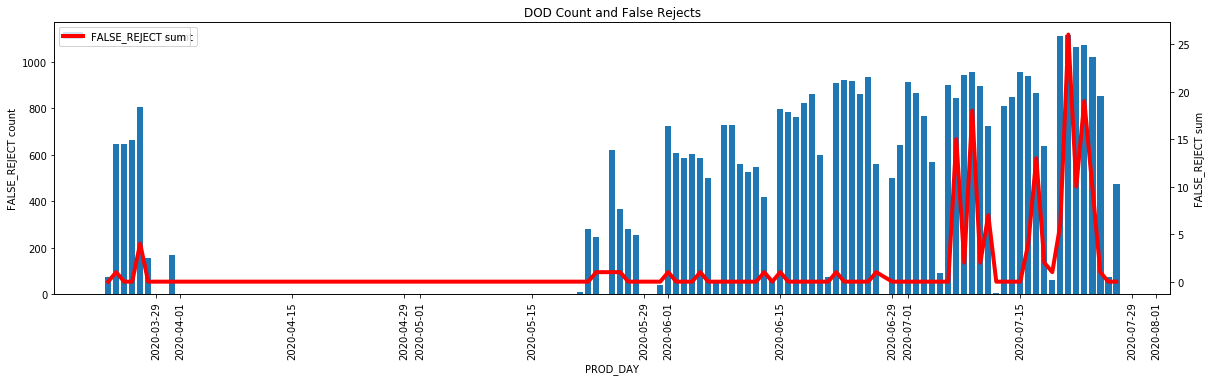

In [7]:
df_dod = df[["PROD_DAY","FALSE_REJECT"]].groupby("PROD_DAY").agg(["sum","count"]).reset_index()
df_dod.columns = [' '.join(col).strip() for col in df_dod.columns.values]

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(df_dod["PROD_DAY"],df_dod["FALSE_REJECT count"], label = 'FALSE_REJECT count')
plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT count')
plt.legend(loc="best")
plt.xticks(rotation = 90,)
ax2 = ax1.twinx()
ax2.plot(df_dod["PROD_DAY"],df_dod["FALSE_REJECT sum"],color='red', linewidth=4, markersize=12, label = 'FALSE_REJECT sum')
plt.title("DOD Count and False Rejects")
plt.legend(loc="best")


plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT sum')

plt.show()
# ax1.plot()

# df_dod.plot(x="PROD_DAY", y = ["FALSE_REJECT sum","FALSE_REJECT count"])

In [8]:
df= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,5,22))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [9]:
df.reset_index(drop=True, inplace = True)

# Feature Engineering

### New Features:
1) Abnormality Flag (For Supervised Approachs) 

2) Mean Shift(Ratio or Difference b/w current 30 obs to baseline obs) (Especially for Pinion Depth) -ve signifies high false rejects (Useful especially for distance based anamoly detection techniques)

3) Decontamination Flag 

4) Throughput rate (might have impact on value of pinion depth maybe)

5) Week day, Hour

6) False reject rate in last 30,60,90 observation (More observations will lead to more stable results, higher(more distinct peaks) but higher time to detect)

7) Benchmark rates for comparison for 2000 data points from past (Both normal and decontaminated)

8) Begining and end point of anomalous behaviour

9) Average of pinion depth over last 30,60 observations. Likewise for LH and RH features

Other Notes:
Recent observations can be assigned higher weihts, especially for statistical approaches
Date time is contextual attribute. Remaining all are behavioural attributes.

In [10]:
df["ABNORMALITY_FLAG"]=np.where(((df.PROD_TIMESTAMP>=pd.datetime(2020,7,7,4)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,11,20)))
                            | ((df.PROD_TIMESTAMP>=pd.datetime(2020,7,16,17)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,18,5)))
                            | ((df.PROD_TIMESTAMP>=pd.datetime(2020,7,20,15)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,24,1)))  
                                ,1,0)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
df["ABNORMALITY_WINDOW"]=np.where(((df.PROD_TIMESTAMP>=pd.datetime(2020,7,7,1)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,11,20))),1,
                            np.where( ((df.PROD_TIMESTAMP>=pd.datetime(2020,7,16,14)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,18,5))),2,
                           np.where( ((df.PROD_TIMESTAMP>=pd.datetime(2020,7,20,12)) & (df.PROD_TIMESTAMP<=pd.datetime(2020,7,24,1))),3,'Others')))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df["FP_500_C"] = df.FALSE_REJECT.rolling(window = 500,min_periods = 1, center = True).mean()

In [13]:
df["PROD_HOUR"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day,math.floor(x.hour/6)*6))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [14]:
df["DECONTAMINATION_FLAG"]=np.where(df["FP_500_C"]>0.002,1,0)

In [15]:
df.groupby("DECONTAMINATION_FLAG")['FALSE_REJECT'].agg(["mean","count","sum"])

mean  count  sum
DECONTAMINATION_FLAG                      
0                     0.000451  31034   14
1                     0.013637   9606  131

In [16]:
df_hour = df[["PROD_HOUR","ABNORMALITY_FLAG","FALSE_REJECT","FP_500_C"]].groupby("PROD_HOUR").agg(["mean"])

df_hour.columns = [' '.join(col).strip() for col in df_hour.columns.values]

df_hour.reset_index(inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\mat

(array([737574., 737577., 737591., 737605., 737607., 737621., 737635.]),
 <a list of 7 Text xticklabel objects>)

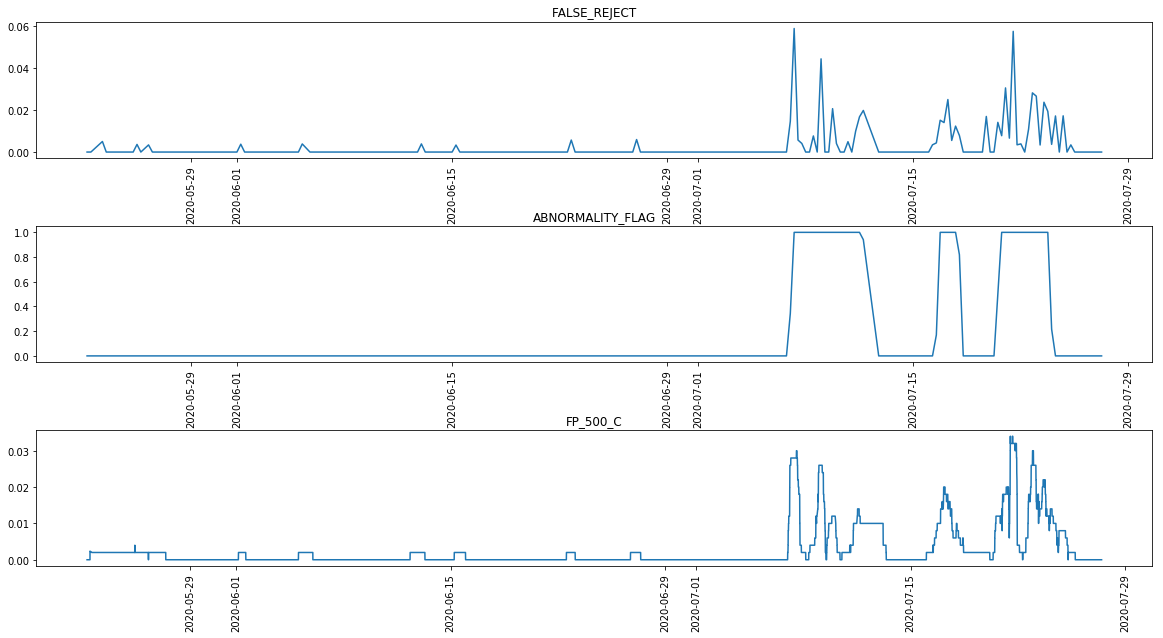

In [17]:
df1= df_hour[df_hour["PROD_HOUR"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,10))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(3,1,1)
ax1.plot(df1["PROD_HOUR"],df1["FALSE_REJECT mean"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(3,1,2)
ax1.plot(df1["PROD_HOUR"],df1["ABNORMALITY_FLAG mean"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(3,1,3)
ax1.plot(df["PROD_TIMESTAMP"],df["FP_500_C"])
plt.title("FP_500_C")
plt.xticks(rotation = 90,)


In [18]:
df["DAY_OF_WEEK"] = df.PROD_TIMESTAMP.dt.dayofweek
df["HOUR"] = df.PROD_TIMESTAMP.dt.hour

In [19]:
df["FP_30_MEAN"] = df.FALSE_REJECT.rolling(window = 30,min_periods = 1, center = False).mean()

df["FP_60_MEAN"] = df.FALSE_REJECT.rolling(window = 60,min_periods = 1, center = False).mean()

df["FP_200_MEAN"] = df.FALSE_REJECT.rolling(window = 200,min_periods = 1, center = False).mean()

df["FP_500_MEAN"] = df.FALSE_REJECT.rolling(window = 500,min_periods = 1, center = False).mean()

df["FP_30_SD"] = df.FALSE_REJECT.rolling(window = 30,min_periods = 1, center = False).std()

df["FP_60_SD"] = df.FALSE_REJECT.rolling(window = 60,min_periods = 1, center = False).std()

df["FP_200_SD"] = df.FALSE_REJECT.rolling(window = 200,min_periods = 1, center = False).std()

df["FP_500_SD"] = df.FALSE_REJECT.rolling(window = 500,min_periods = 1, center = False).std()

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


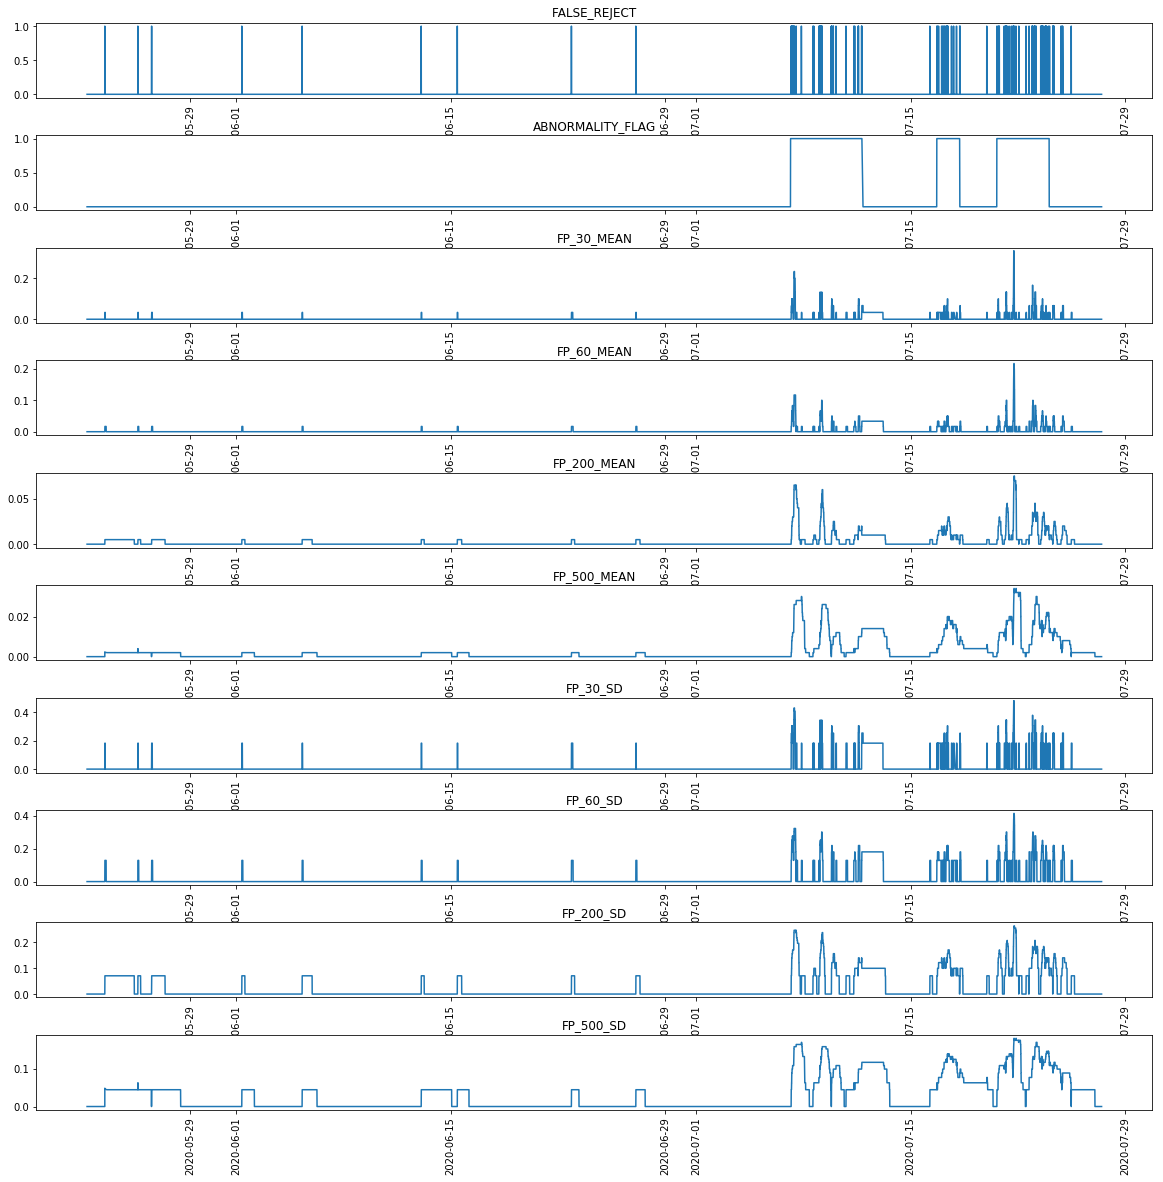

In [20]:
df1= df[df["PROD_TIMESTAMP"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["FP_30_MEAN","FP_60_MEAN","FP_200_MEAN","FP_500_MEAN","FP_30_SD","FP_60_SD","FP_200_SD","FP_500_SD"]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

In [21]:
df["PINION_DEPTH_30_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()

df["PINION_DEPTH_60_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).mean()

df["PINION_DEPTH_200_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).mean()

df["PINION_DEPTH_500_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).mean()

df["PINION_DEPTH_30_SD"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).std()

df["PINION_DEPTH_60_SD"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).std()

df["PINION_DEPTH_200_SD"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).std()

df["PINION_DEPTH_500_SD"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).std()

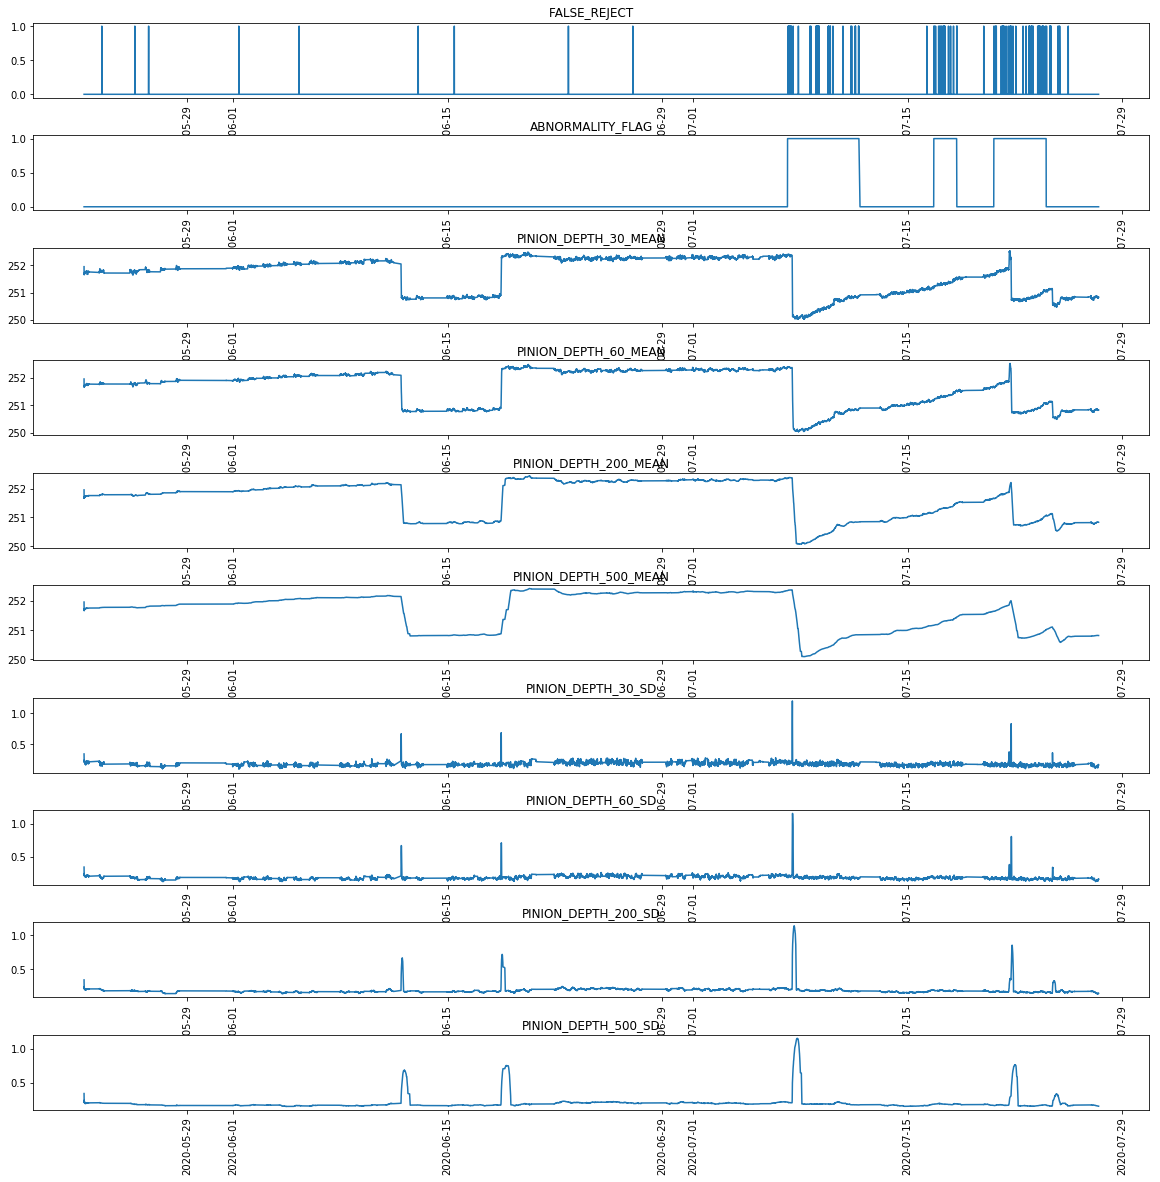

In [22]:
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df["PROD_TIMESTAMP"],df["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df["PROD_TIMESTAMP"],df["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["PINION_DEPTH_30_MEAN","PINION_DEPTH_60_MEAN","PINION_DEPTH_200_MEAN","PINION_DEPTH_500_MEAN","PINION_DEPTH_30_SD","PINION_DEPTH_60_SD","PINION_DEPTH_200_SD","PINION_DEPTH_500_SD"]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

In [23]:
df["LH_30_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()

df["LH_60_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).mean()

df["LH_200_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).mean()

df["LH_500_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).mean()

df["LH_30_SD"] = df["LH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).std()

df["LH_60_SD"] = df["LH Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).std()

df["LH_200_SD"] = df["LH Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).std()

df["LH_500_SD"] = df["LH Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).std()

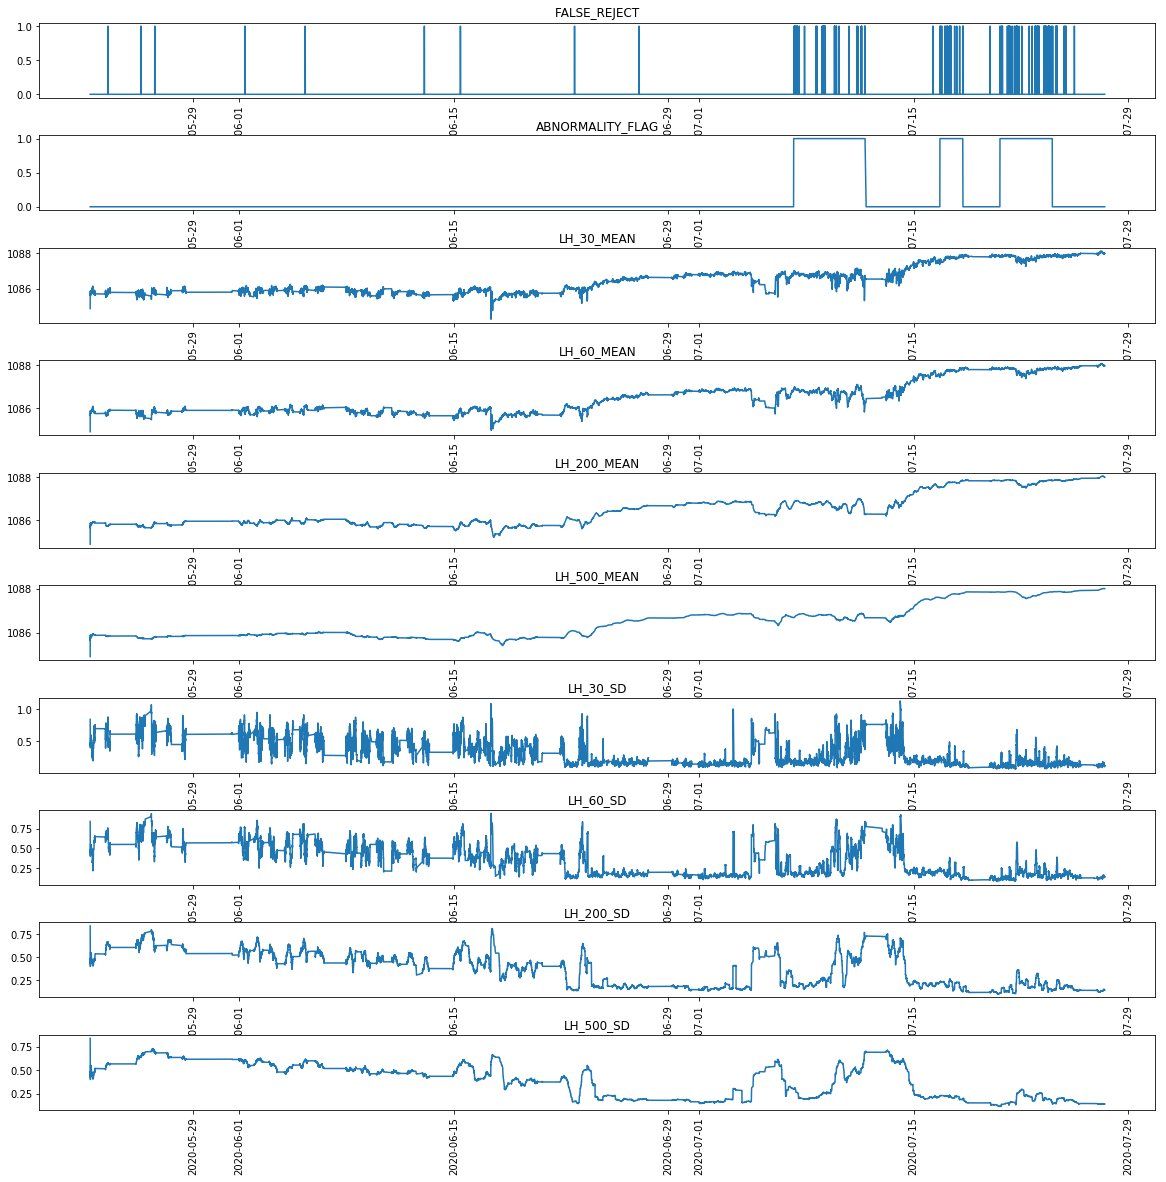

In [24]:
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df["PROD_TIMESTAMP"],df["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df["PROD_TIMESTAMP"],df["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["LH_30_MEAN","LH_60_MEAN","LH_200_MEAN","LH_500_MEAN","LH_30_SD","LH_60_SD","LH_200_SD","LH_500_SD"]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

In [25]:
df["RH_30_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()

df["RH_60_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).mean()

df["RH_200_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).mean()

df["RH_500_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).mean()


df["RH_30_SD"] = df["RH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).std()

df["RH_60_SD"] = df["RH Slide To Full Depth Posn"].rolling(window = 60,min_periods = 1, center = False).std()

df["RH_200_SD"] = df["RH Slide To Full Depth Posn"].rolling(window = 200,min_periods = 1, center = False).std()

df["RH_500_SD"] = df["RH Slide To Full Depth Posn"].rolling(window = 500,min_periods = 1, center = False).std()



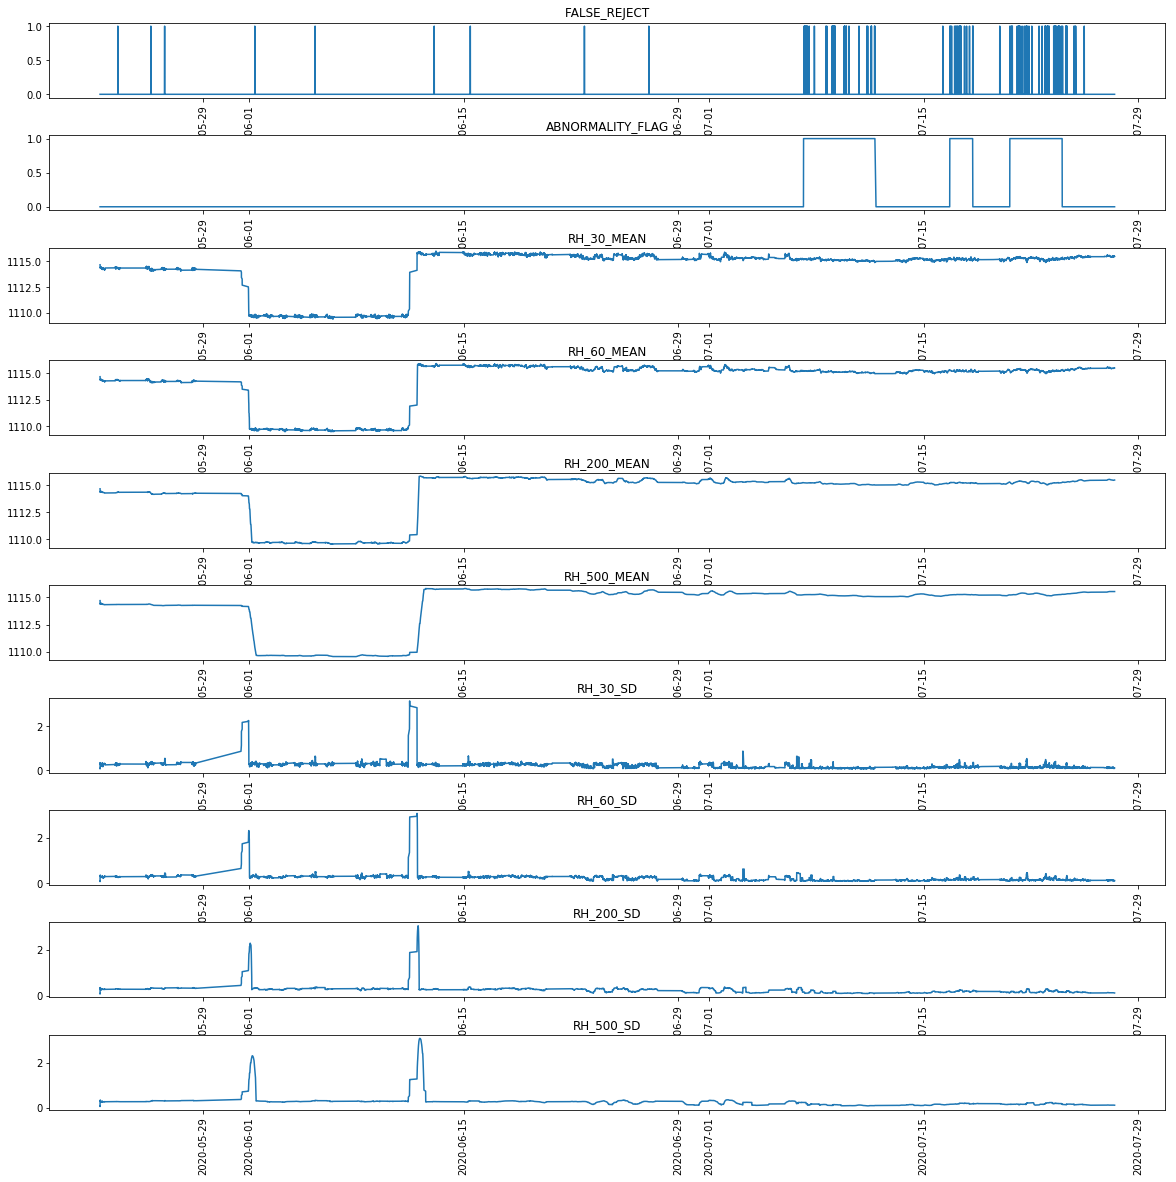

In [26]:
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df["PROD_TIMESTAMP"],df["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df["PROD_TIMESTAMP"],df["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["RH_30_MEAN","RH_60_MEAN","RH_200_MEAN","RH_500_MEAN","RH_30_SD","RH_60_SD","RH_200_SD","RH_500_SD"]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

In [27]:
# Based on 10 observations (Parts/Hour)
df["THROUGHPUT_RATE"] = round(20/(df.PROD_TIMESTAMP-df.PROD_TIMESTAMP.shift(20)).dt.seconds*3600)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


(array([737574., 737577., 737591., 737605., 737607., 737621., 737635.]),
 <a list of 7 Text xticklabel objects>)

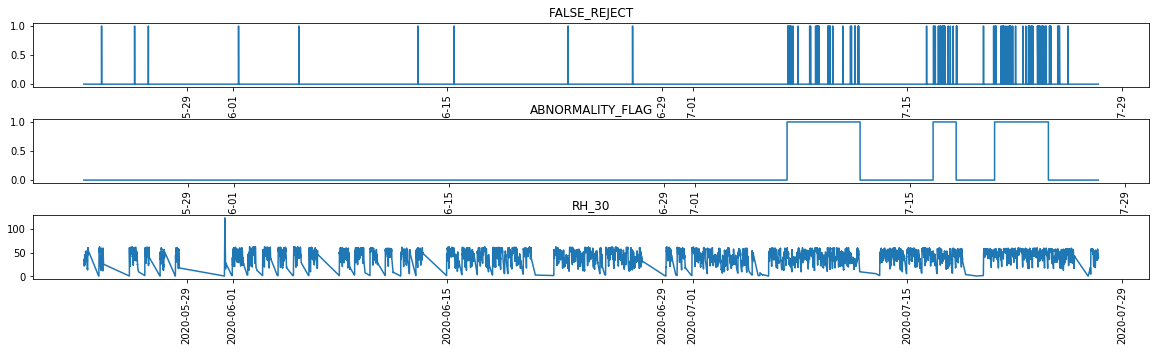

In [28]:
df1= df[df["PROD_TIMESTAMP"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,10))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(6,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(6,1,2)
ax1.plot(df1["PROD_HOUR"],df1["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(6,1,3)
ax1.plot(df["PROD_TIMESTAMP"],df["THROUGHPUT_RATE"])
plt.title("RH_30")
plt.xticks(rotation = 90,)


In [29]:
# df.reset_index(inplace = True, drop = True)

# # x= 20000
# b_window = 2000
# c_window = 30


# # df.shape[0]
# start = time.time()

# for x in range(b_window,df.shape[0]):
    
#     base_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     current_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-c_window):x])
#     ks_value = ks_2samp(base_obs,current_obs)
# #     ks_value = ks_2samp([0] * 10000,current_obs)
#     df.loc[df.index[x],"DIFF_VAR1"] = 1-ks_value.pvalue

# print (time.time()-start)

In [35]:
df.reset_index(inplace = True, drop = True)

# x= 20000
b_window = 4000
c_window = 500

df["FP_30_MEAN"] = df.FALSE_REJECT.rolling(window = 30,min_periods = 1, center = False).mean()
df["PINION_DEPTH_30_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()
df["LH_30_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()
df["RH_30_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = df[["DECONTAMINATION_FLAG","FALSE_REJECT","Pinion Slide To Full Depth Posn",
                        "LH Slide To Full Depth Posn","RH Slide To Full Depth Posn"]][max(0,x-b_window-c_window):max(0,x-c_window)]
    
#     base_obs_FP = list(df["FALSE_REJECT"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_PINION_DEPTH = list(df["Pinion Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_LH = list(df["LH Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_RH = list(df["RH Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
    
    
#     current_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-c_window):x])
#     ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
#     df.loc[df.index[x],"DIFF_VAR1"] = 1-ks_value.pvalue
    df.loc[df.index[x],"FP_BASE_MEAN"] = np.mean(base_obs["FALSE_REJECT"])
    df.loc[df.index[x],"PINION_DEPTH_BASE_MEAN"] = np.mean(base_obs["Pinion Slide To Full Depth Posn"])
    df.loc[df.index[x],"LH_BASE_MEAN"] = np.mean(base_obs["LH Slide To Full Depth Posn"])
    df.loc[df.index[x],"RH_BASE_MEAN"] = np.mean(base_obs["RH Slide To Full Depth Posn"])
    
    df.loc[df.index[x],"FP_BASE_SD"] = np.std(base_obs["FALSE_REJECT"])
    df.loc[df.index[x],"PINION_DEPTH_BASE_SD"] = np.std(base_obs["Pinion Slide To Full Depth Posn"])
    df.loc[df.index[x],"LH_BASE_SD"] = np.std(base_obs["LH Slide To Full Depth Posn"])
    df.loc[df.index[x],"RH_BASE_SD"] = np.std(base_obs["RH Slide To Full Depth Posn"])

print(time.time()-start)

131.74969220161438


In [34]:
df.reset_index(inplace = True, drop = True)

# x= 20000
b_window = 4000
c_window = 500

df["FP_30_MEAN"] = df.FALSE_REJECT.rolling(window = 30,min_periods = 1, center = False).mean()
df["PINION_DEPTH_30_MEAN"] = df["Pinion Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()
df["LH_30_MEAN"] = df["LH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()
df["RH_30_MEAN"] = df["RH Slide To Full Depth Posn"].rolling(window = 30,min_periods = 1, center = False).mean()


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = df[["DECONTAMINATION_FLAG","FALSE_REJECT","Pinion Slide To Full Depth Posn",
                        "LH Slide To Full Depth Posn","RH Slide To Full Depth Posn"]][max(0,x-b_window-c_window):max(0,x-c_window)]
    base_obs = base_obs[base_obs["DECONTAMINATION_FLAG"]==0]
#     base_obs_FP = list(df["FALSE_REJECT"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_PINION_DEPTH = list(df["Pinion Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_LH = list(df["LH Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
#     base_obs_RH = list(df["RH Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
    
    
#     current_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-c_window):x])
#     ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
#     df.loc[df.index[x],"DIFF_VAR1"] = 1-ks_value.pvalue
    df.loc[df.index[x],"FP_BASE_MEAN_DECON"] = np.mean(base_obs["FALSE_REJECT"])
    df.loc[df.index[x],"PINION_DEPTH_BASE_MEAN_DECON"] = np.mean(base_obs["Pinion Slide To Full Depth Posn"])
    df.loc[df.index[x],"LH_BASE_MEAN_DECON"] = np.mean(base_obs["LH Slide To Full Depth Posn"])
    df.loc[df.index[x],"RH_BASE_MEAN_DECON"] = np.mean(base_obs["RH Slide To Full Depth Posn"])
    
    df.loc[df.index[x],"FP_BASE_SD_DECON"] = np.std(base_obs["FALSE_REJECT"])
    df.loc[df.index[x],"PINION_DEPTH_BASE_SD_DECON"] = np.std(base_obs["Pinion Slide To Full Depth Posn"])
    df.loc[df.index[x],"LH_BASE_SD_DECON"] = np.std(base_obs["LH Slide To Full Depth Posn"])
    df.loc[df.index[x],"RH_BASE_SD_DECON"] = np.std(base_obs["RH Slide To Full Depth Posn"])

print(time.time()-start)

145.90052890777588


In [32]:
for x in [30,60,200,500]:
    for var in ["FP","PINION_DEPTH","LH","RH"]:
        df[var+"_"+str(x)+"_MEAN_DIFF"] = df[var+"_"+str(x)+"_MEAN"]-df[var+"_BASE"+"_MEAN"]
        df[var+"_"+str(x)+"_SD_DIFF"] = df[var+"_"+str(x)+"_SD"]-df[var+"_BASE"+"_SD"]
        df[var+"_"+str(x)+"_MEAN_DECON_DIFF"] = df[var+"_"+str(x)+"_MEAN"]-df[var+"_BASE"+"_MEAN_DECON"]
        df[var+"_"+str(x)+"_SD_DECON_DIFF"] = df[var+"_"+str(x)+"_SD"]-df[var+"_BASE"+"_SD_DECON"]
        

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


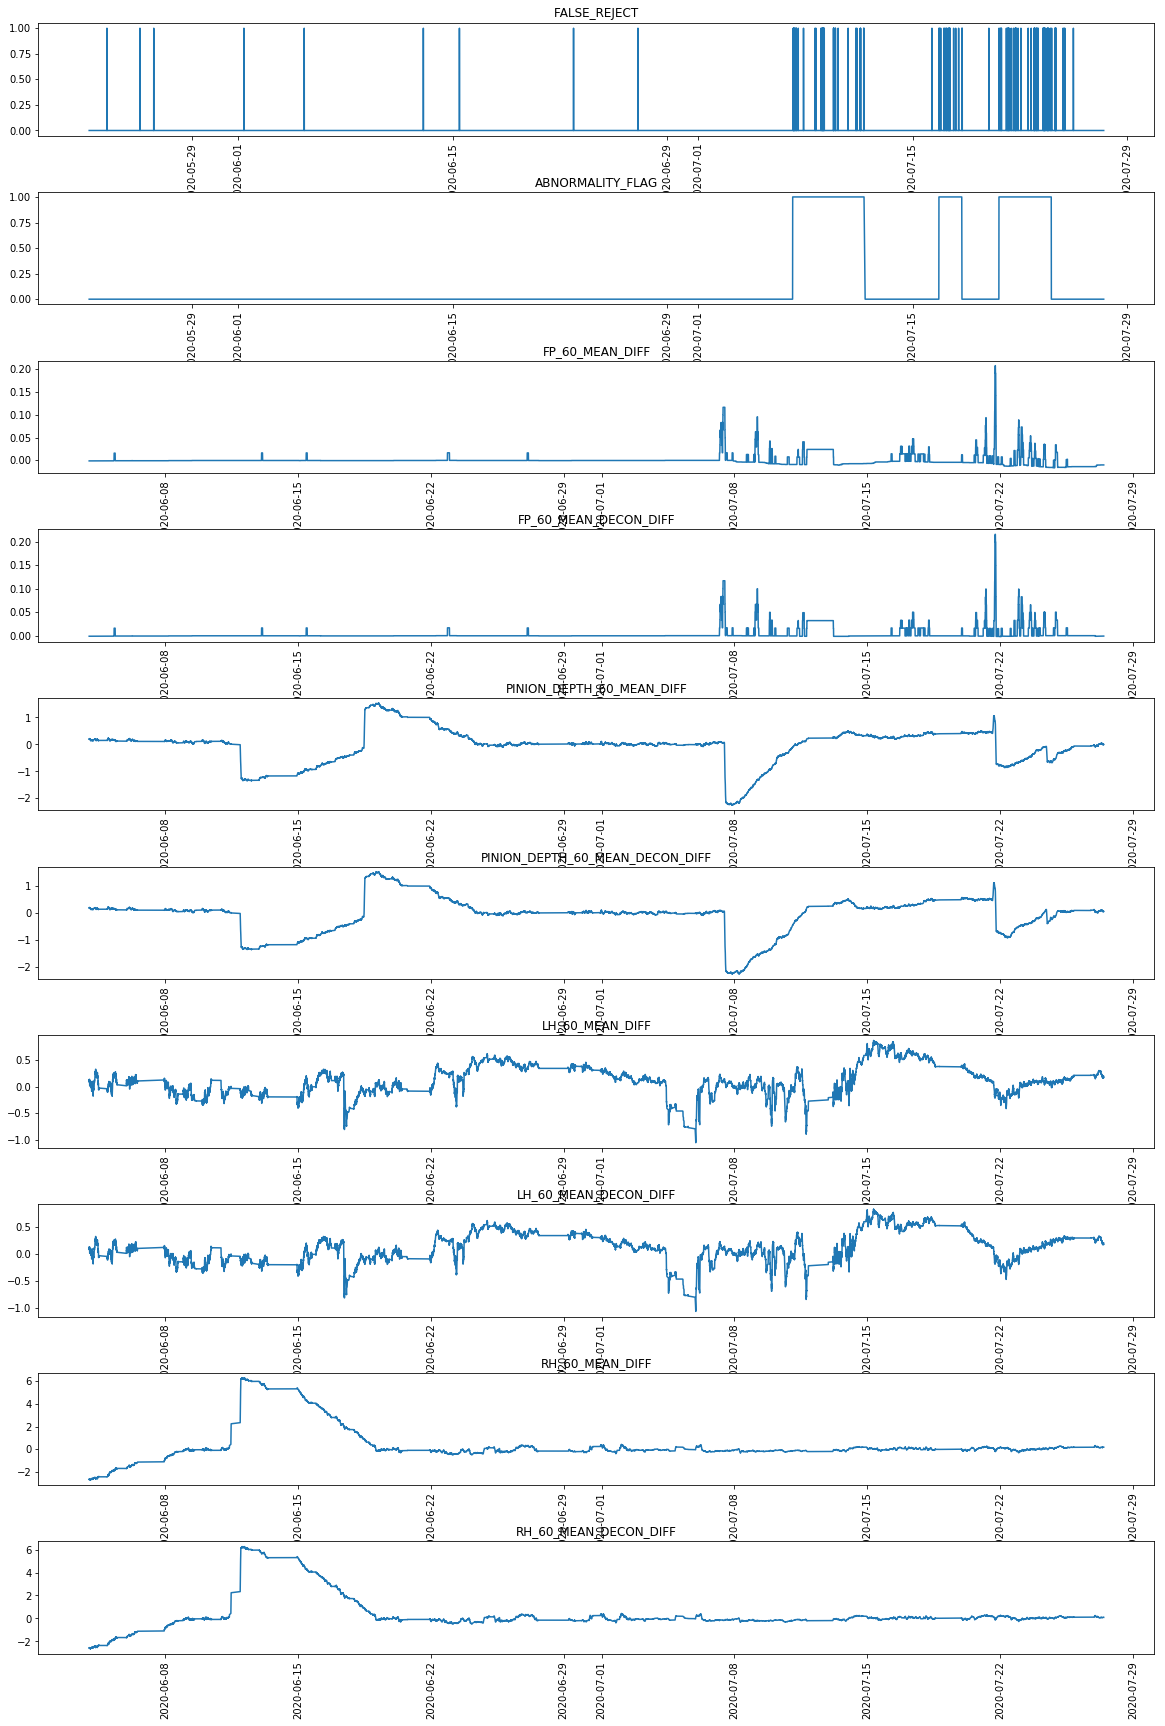

In [33]:
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(10,1,1)
ax1.plot(df["PROD_TIMESTAMP"],df["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(10,1,2)
ax1.plot(df["PROD_TIMESTAMP"],df["ABNORMALITY_FLAG"])
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)

columns = ["FP_60_MEAN_DIFF","FP_60_MEAN_DECON_DIFF","PINION_DEPTH_60_MEAN_DIFF","PINION_DEPTH_60_MEAN_DECON_DIFF",
          "LH_60_MEAN_DIFF","LH_60_MEAN_DECON_DIFF","RH_60_MEAN_DIFF","RH_60_MEAN_DECON_DIFF",]

for x in range(len(columns)):
    
    ax1= fig.add_subplot(10,1,x+3)
    ax1.plot(df["PROD_TIMESTAMP"],df[columns[x]])
    plt.title(columns[x])
    plt.xticks(rotation = 90,)

# Drift Detection

## Pinion Depth

In [34]:
feature = 'Pinion Slide To Full Depth Posn'
feature = 'PINION_DEPTH_30_MEAN'

# feature = 'LH Slide To Full Depth Posn'
# feature = 'RH Slide To Full Depth Posn'


import numpy as np
from skmultiflow.drift_detection.hddm_w import HDDM_W
hddm_w = HDDM_W(drift_confidence=0.001,
    warning_confidence=0.005,
    lambda_option=0.2,
    two_side_option=True)

data_stream = df[feature]
for i in range(len(data_stream)):
    hddm_w.add_element(data_stream[i])
    if hddm_w.detected_change():
        df.loc[df.index[i],"DRIFT"] = 2
    elif hddm_w.detected_warning_zone():
        df.loc[df.index[i],"DRIFT"] = 1
    else:
        df.loc[df.index[i],"DRIFT"] = 0        

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

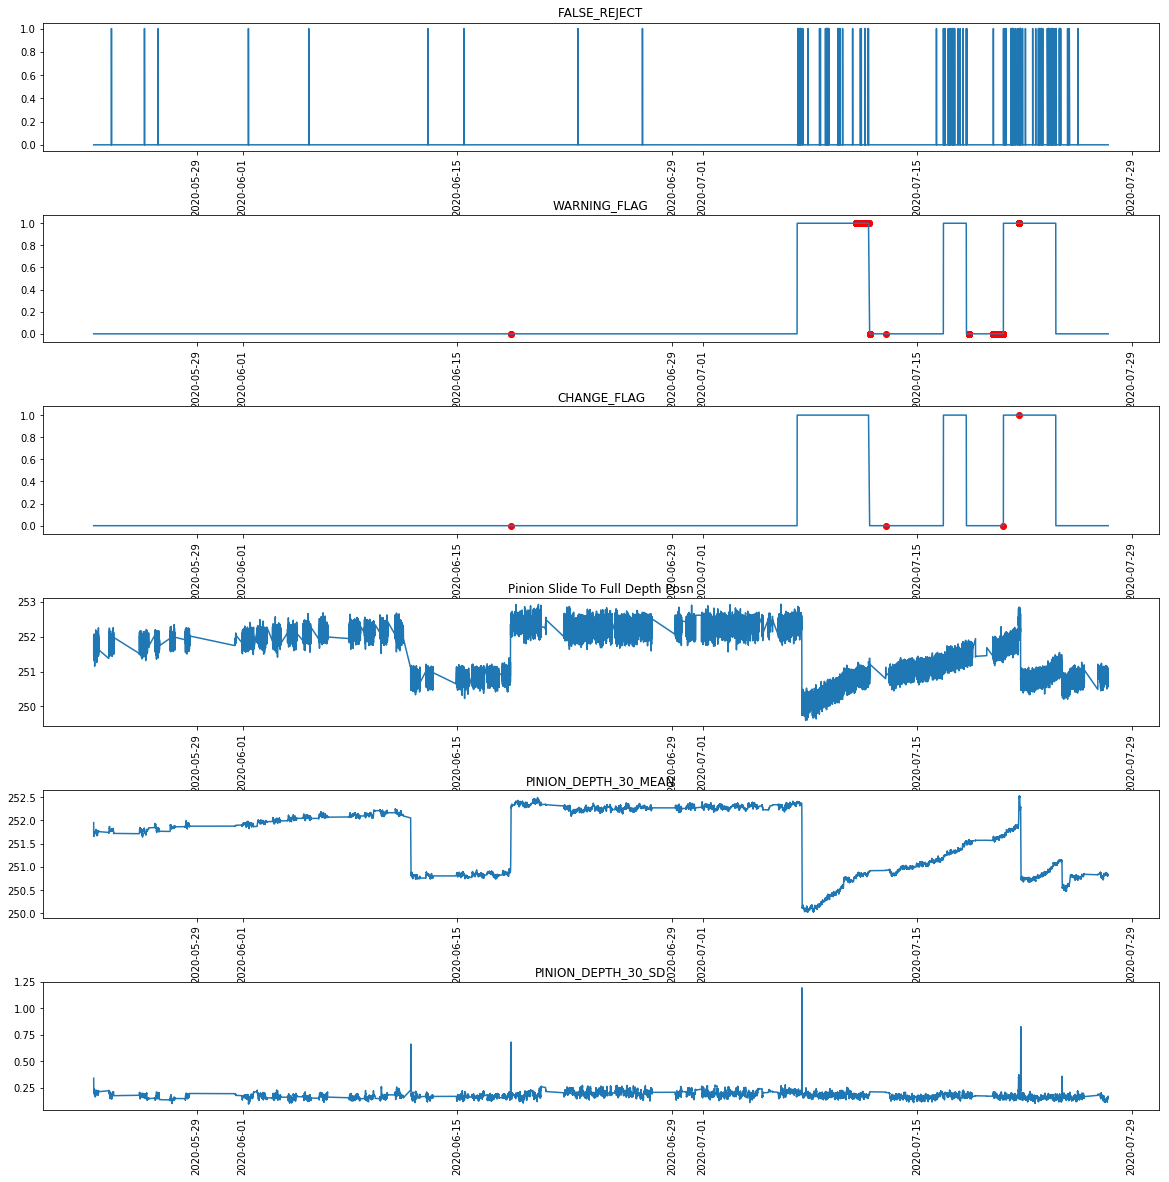

In [35]:
features=['Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

df1=df
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("WARNING_FLAG")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,3)
a = df1.loc[df1['DRIFT'] == 2, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+4)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

In [36]:
feature = 'Pinion Slide To Full Depth Posn'
# feature = 'LH Slide To Full Depth Posn'
# feature = 'RH Slide To Full Depth Posn'


import numpy as np
from skmultiflow.drift_detection.hddm_a import HDDM_A
hddm_a = HDDM_A()

data_stream = df[feature]
for i in range(len(data_stream)):
    hddm_a.add_element(data_stream[i])
    if hddm_a.detected_change():
        df.loc[df.index[i],"DRIFT"] = 2
    elif hddm_a.detected_warning_zone():
        df.loc[df.index[i],"DRIFT"] = 1
    else:
        df.loc[df.index[i],"DRIFT"] = 0
    
        

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

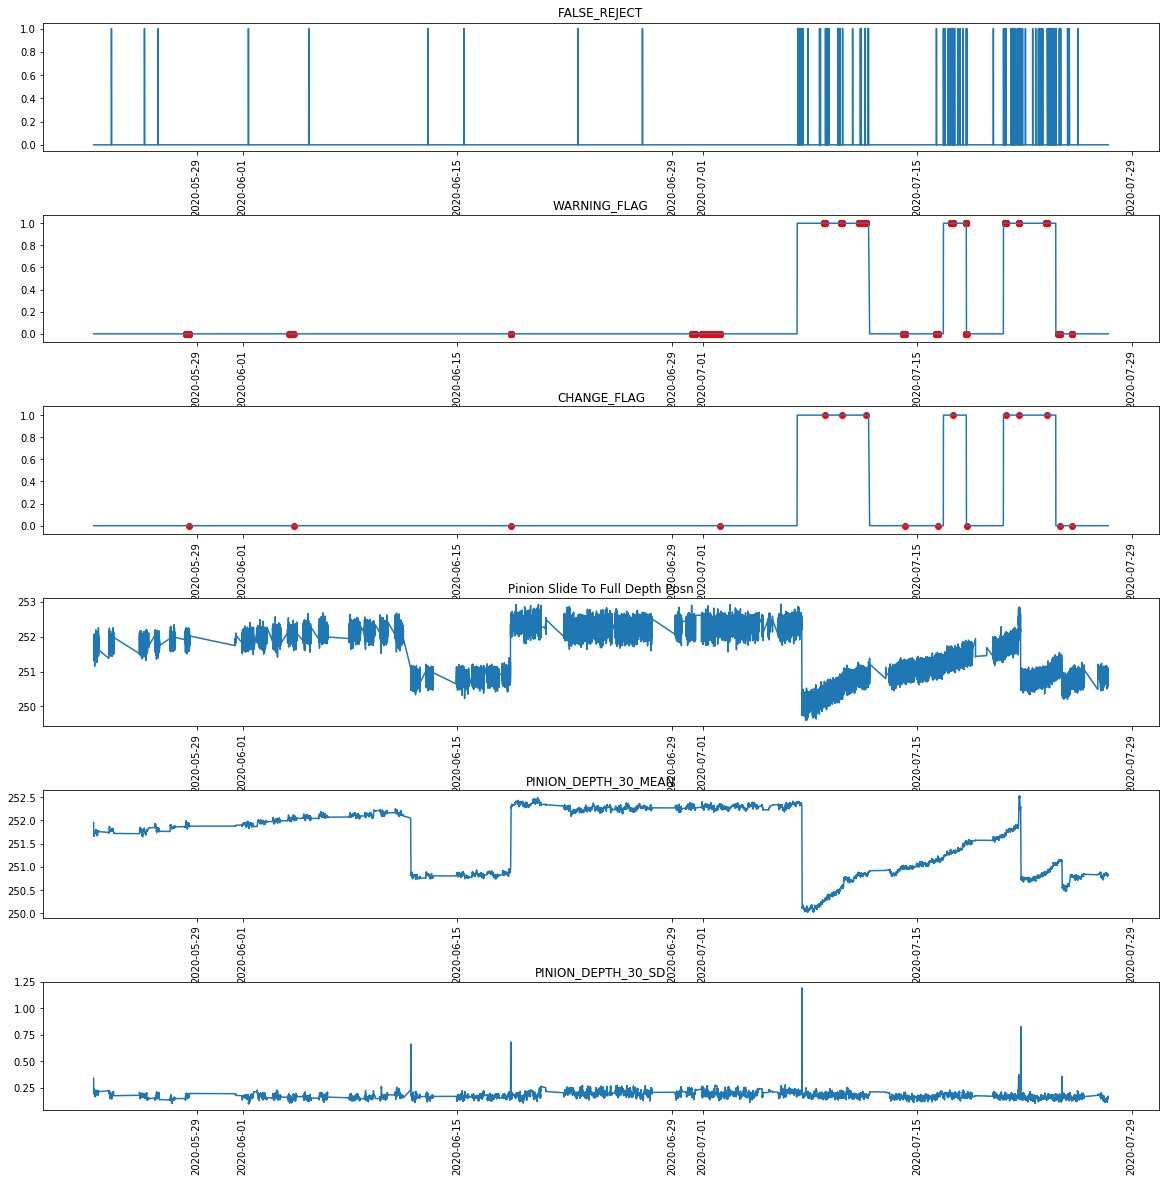

In [37]:
features=['Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

df1=df
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("WARNING_FLAG")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,3)
a = df1.loc[df1['DRIFT'] == 2, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+4)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

In [38]:
feature = 'Pinion Slide To Full Depth Posn'
# feature = 'LH Slide To Full Depth Posn'
# feature = 'RH Slide To Full Depth Posn'


import numpy as np
from skmultiflow.drift_detection.adwin import ADWIN
adwin = ADWIN(delta = 5)

data_stream = df[feature]
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        df.loc[df.index[i],"DRIFT"] = 2
    elif adwin.detected_warning_zone():
        df.loc[df.index[i],"DRIFT"] = 1
    else:
        df.loc[df.index[i],"DRIFT"] = 0
    
        

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

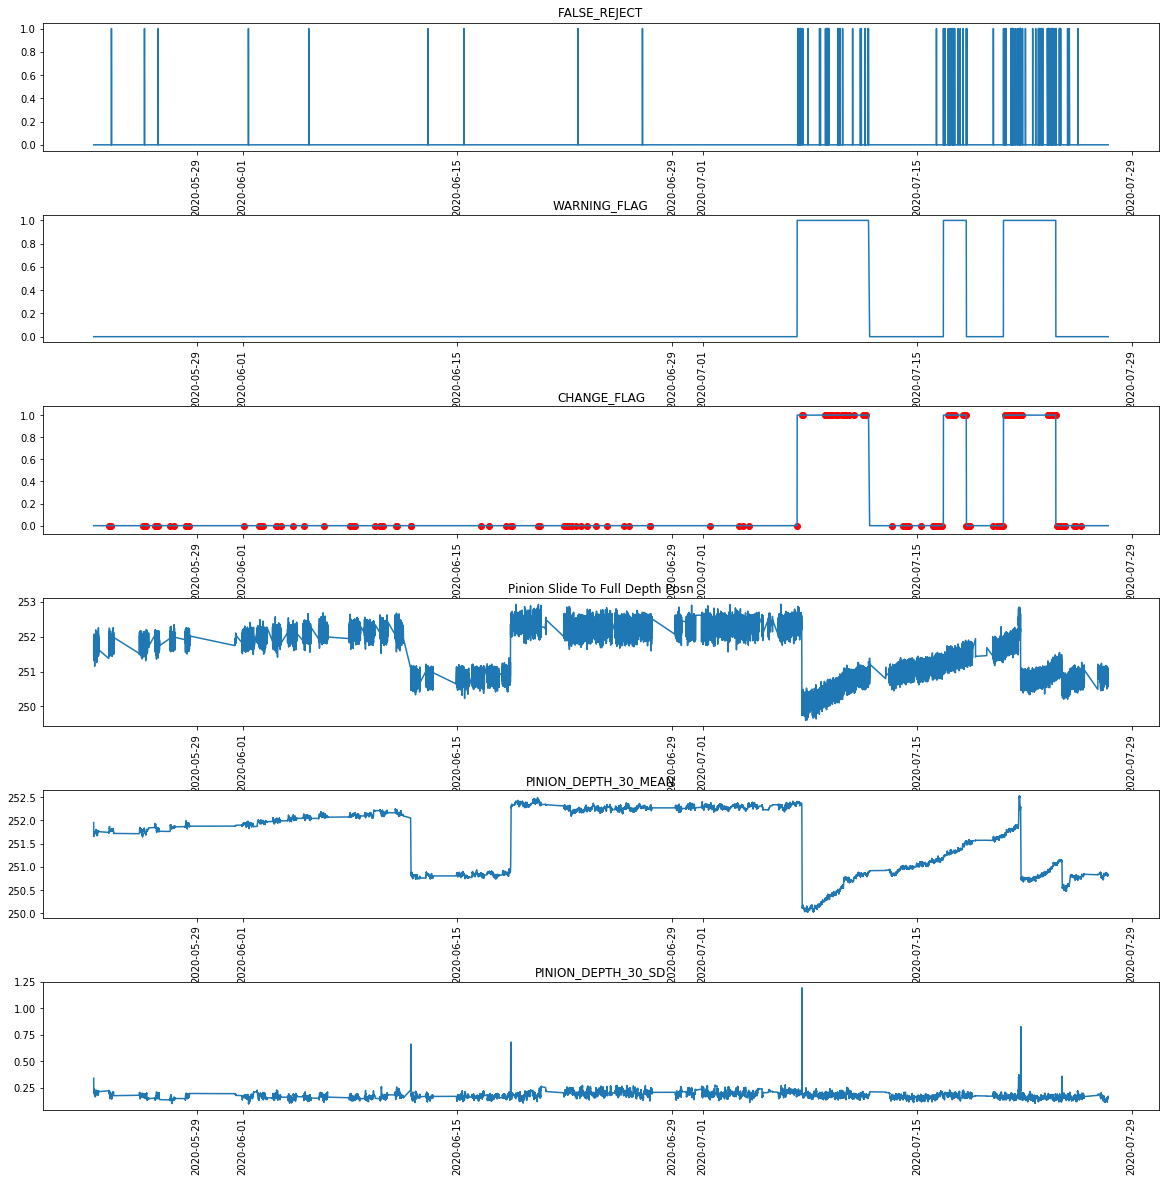

In [39]:
features=['Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

df1=df
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("WARNING_FLAG")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,3)
a = df1.loc[df1['DRIFT'] == 2, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+4)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

In [40]:
feature = 'Pinion Slide To Full Depth Posn'
# feature = 'LH Slide To Full Depth Posn'
# feature = 'RH Slide To Full Depth Posn'


import numpy as np
from skmultiflow.drift_detection import DDM
DDM = DDM()

data_stream = df[feature]
for i in range(len(data_stream)):
    DDM.add_element(data_stream[i])
    if DDM.detected_change():
        df.loc[df.index[i],"DRIFT"] = 2
    elif DDM.detected_warning_zone():
        df.loc[df.index[i],"DRIFT"] = 1
    else:
        df.loc[df.index[i],"DRIFT"] = 0
    
        

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\skmultiflow\drift_detection\ddm.py:126: RuntimeWarning: invalid value encountered in sqrt
  self.miss_std = np.sqrt(self.miss_prob * (1 - self.miss_prob) / float(self.sample_count))


In [43]:
DDM.detected_warning_zone()

False

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

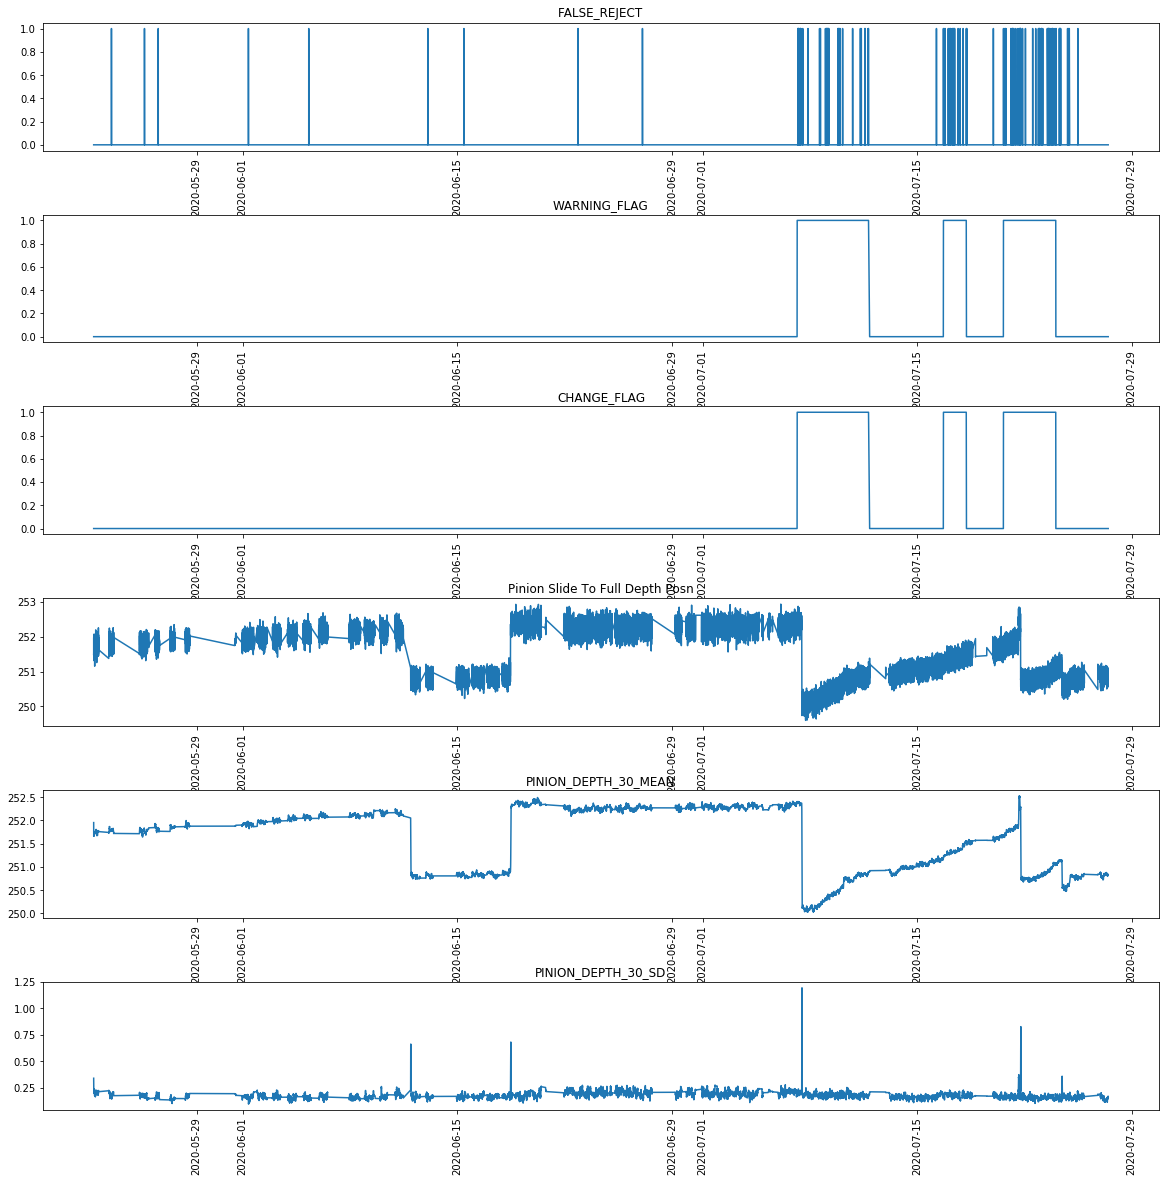

In [41]:
features=['Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

df1=df
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("WARNING_FLAG")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,3)
a = df1.loc[df1['DRIFT'] == 2, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+4)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

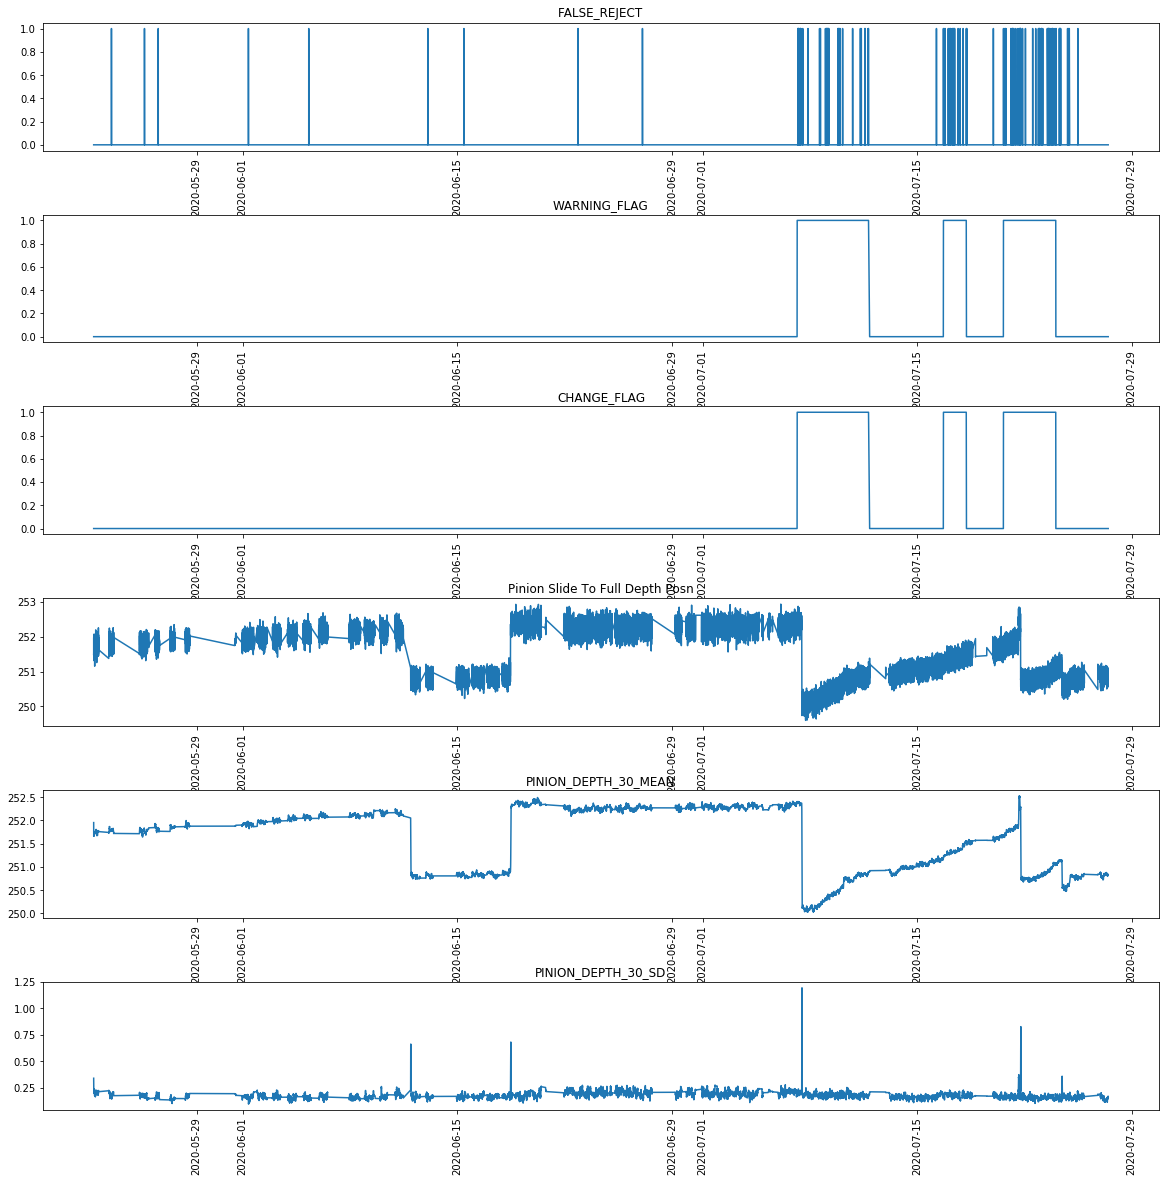

In [48]:
feature = 'Pinion Slide To Full Depth Posn'
# feature = 'LH Slide To Full Depth Posn'
# feature = 'RH Slide To Full Depth Posn'


import numpy as np
from skmultiflow.drift_detection import EDDM
DDM = EDDM()

data_stream = df[feature]
for i in range(len(data_stream)):
    DDM.add_element(data_stream[i])
    if DDM.detected_change():
        df.loc[df.index[i],"DRIFT"] = 2
    elif DDM.detected_warning_zone():
        df.loc[df.index[i],"DRIFT"] = 1
    else:
        df.loc[df.index[i],"DRIFT"] = 0
    
        

DDM.detected_warning_zone()

features=['Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

df1=df
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("WARNING_FLAG")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,3)
a = df1.loc[df1['DRIFT'] == 2, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+4)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

## LH

## RH

# Make your Own Method

### Mean, SD, Median over some values required to convert data into probability

### Try calculating 1 primary (principal) component using PCA and calculating probabilities based on that

In [39]:
df.reset_index(inplace = True, drop = True)

feature = 'Pinion Slide To Full Depth Posn'
# x= 20000
b_window = 10
c_window = 10

start = time.time()

for x in range(b_window,df.shape[0]):
    
    current_obs= df[feature][max(0,x-c_window):max(0,x)]
    base_obs = df[feature][max(0,x-b_window-c_window):max(0,x-c_window)]
    
    df.loc[df.index[x],"PINION_SLIDE_MEAN_10_to_10_DIFF"] = np.mean(base_obs)-np.mean(current_obs)
    df.loc[df.index[x],"PINION_SLIDE_MEDIAN_10_to_10_DIFF"] = np.median(base_obs)-np.median(current_obs)
    df.loc[df.index[x],"PINION_SLIDE_STD_10_to_10_DIFF"] = np.std(base_obs)-np.std(current_obs)

    
print(time.time()-start)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


41.65570688247681


0.00021534931652150992
0.06933837971939309


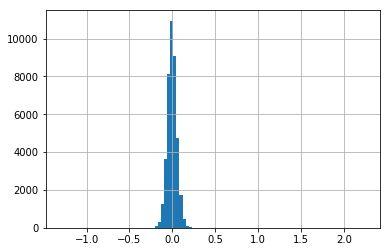

In [75]:
df1 = df.dropna(subset = ['PINION_SLIDE_MEAN_10_to_10_DIFF'])
df1["PINION_SLIDE_MEAN_10_to_10_DIFF"].hist(bins =100)
print(df1["PINION_SLIDE_MEAN_10_to_10_DIFF"].mean())
print(df1["PINION_SLIDE_MEAN_10_to_10_DIFF"].std())

In [92]:
import scipy.stats as st
cutoff = 0.0001
z_high = st.norm.ppf(1-cutoff)
z_low = st.norm.ppf(cutoff)
df1["Z_SCORE"]= st.zscore(df1["PINION_SLIDE_MEAN_10_to_10_DIFF"])
df1["DRIFT"]  = np.where((df1["Z_SCORE"]>= z_high) | (df1["Z_SCORE"]<= z_low),1,0)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

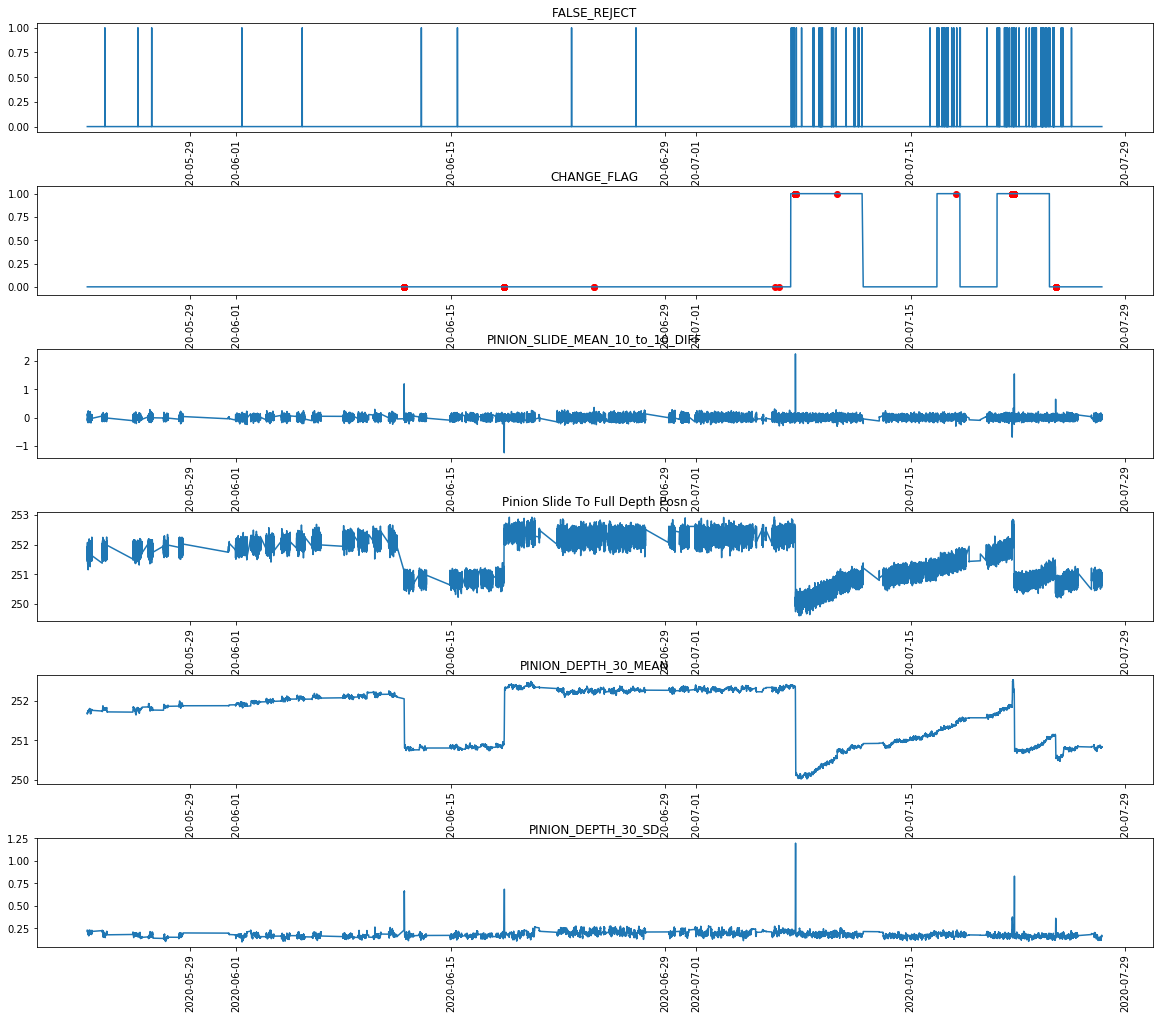

In [93]:
features=['PINION_SLIDE_MEAN_10_to_10_DIFF','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

0.00021991680819119565
0.08749569983994789


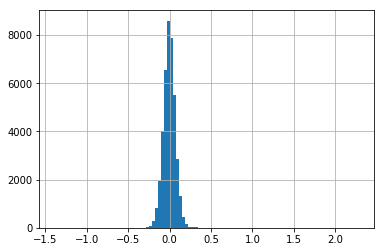

In [76]:
df1 = df.dropna(subset = ['PINION_SLIDE_MEDIAN_10_to_10_DIFF'])
df1["PINION_SLIDE_MEDIAN_10_to_10_DIFF"].hist(bins =100)
print(df1["PINION_SLIDE_MEDIAN_10_to_10_DIFF"].mean())
print(df1["PINION_SLIDE_MEDIAN_10_to_10_DIFF"].std())

In [77]:
import scipy.stats as st
cutoff = 0.00001
z_high = st.norm.ppf(1-cutoff)
z_low = st.norm.ppf(cutoff)
df1["Z_SCORE"]= st.zscore(df1["PINION_SLIDE_MEDIAN_10_to_10_DIFF"])
df1["DRIFT"]  = np.where((df1["Z_SCORE"]>= z_high) | (df1["Z_SCORE"]<= z_low),1,0)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

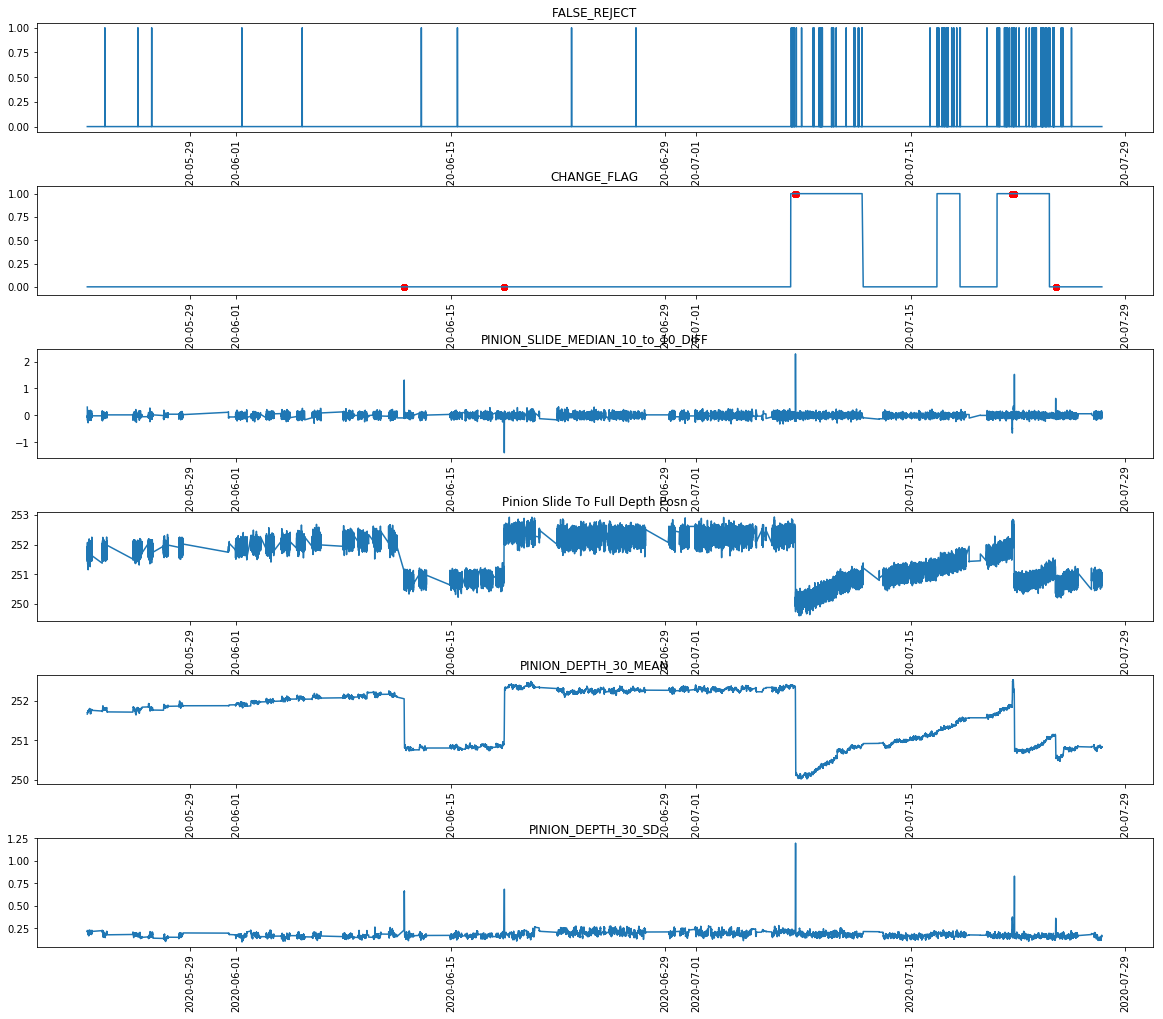

In [78]:
features=['PINION_SLIDE_MEDIAN_10_to_10_DIFF','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

9.510235545361287e-06
0.049872237480565886


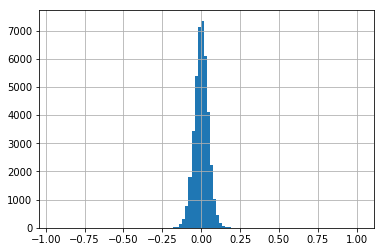

In [79]:
df1 = df.dropna(subset = ['PINION_SLIDE_STD_10_to_10_DIFF'])
df1["PINION_SLIDE_STD_10_to_10_DIFF"].hist(bins =100)
print(df1["PINION_SLIDE_STD_10_to_10_DIFF"].mean())
print(df1["PINION_SLIDE_STD_10_to_10_DIFF"].std())

In [80]:
import scipy.stats as st
cutoff = 0.00001
z_high = st.norm.ppf(1-cutoff)
z_low = st.norm.ppf(cutoff)
df1["Z_SCORE"]= st.zscore(df1["PINION_SLIDE_STD_10_to_10_DIFF"])
df1["DRIFT"]  = np.where((df1["Z_SCORE"]>= z_high) | (df1["Z_SCORE"]<= z_low),1,0)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

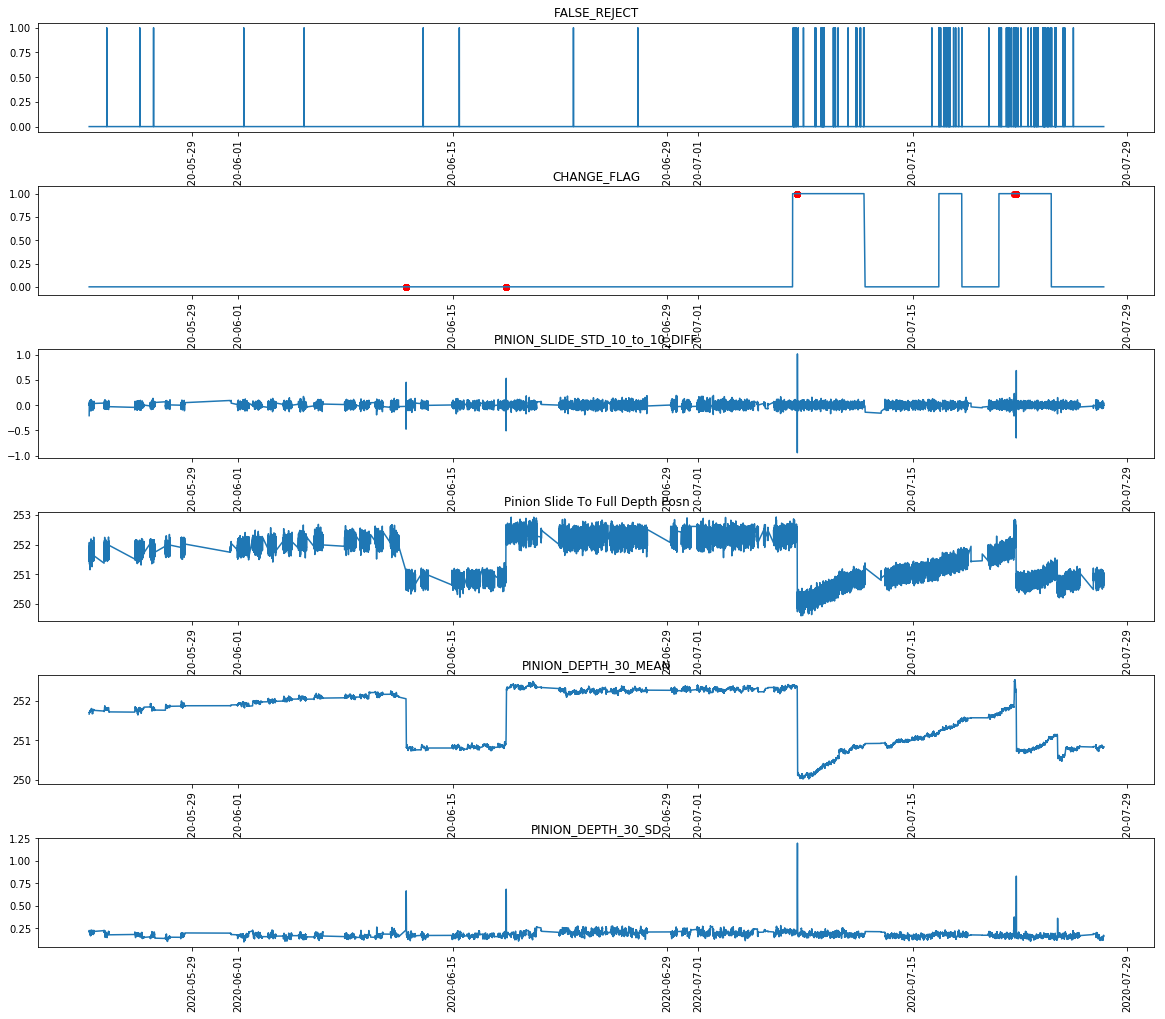

In [81]:
features=['PINION_SLIDE_STD_10_to_10_DIFF','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

In [82]:
df.reset_index(inplace = True, drop = True)

feature = 'Pinion Slide To Full Depth Posn'
# x= 20000
b_window = 10
c_window = 5

start = time.time()

for x in range(b_window,df.shape[0]):
    
    current_obs= df[feature][max(0,x-c_window):max(0,x)]
    base_obs = df[feature][max(0,x-b_window-c_window):max(0,x-c_window)]
    
    df.loc[df.index[x],"PINION_SLIDE_MEAN_10_to_10_DIFF"] = np.mean(base_obs)-np.mean(current_obs)
    df.loc[df.index[x],"PINION_SLIDE_MEDIAN_10_to_10_DIFF"] = np.median(base_obs)-np.median(current_obs)
    df.loc[df.index[x],"PINION_SLIDE_STD_10_to_10_DIFF"] = np.std(base_obs)-np.std(current_obs)

    
print(time.time()-start)

46.82827091217041


0.00016150777047215366
0.07815721210208361


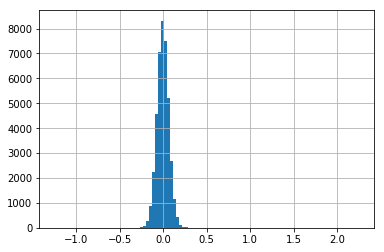

In [83]:
df1 = df.dropna(subset = ['PINION_SLIDE_MEAN_10_to_10_DIFF'])
df1["PINION_SLIDE_MEAN_10_to_10_DIFF"].hist(bins =100)
print(df1["PINION_SLIDE_MEAN_10_to_10_DIFF"].mean())
print(df1["PINION_SLIDE_MEAN_10_to_10_DIFF"].std())

In [84]:
import scipy.stats as st
cutoff = 0.00001
z_high = st.norm.ppf(1-cutoff)
z_low = st.norm.ppf(cutoff)
df1["Z_SCORE"]= st.zscore(df1["PINION_SLIDE_MEAN_10_to_10_DIFF"])
df1["DRIFT"]  = np.where((df1["Z_SCORE"]>= z_high) | (df1["Z_SCORE"]<= z_low),1,0)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

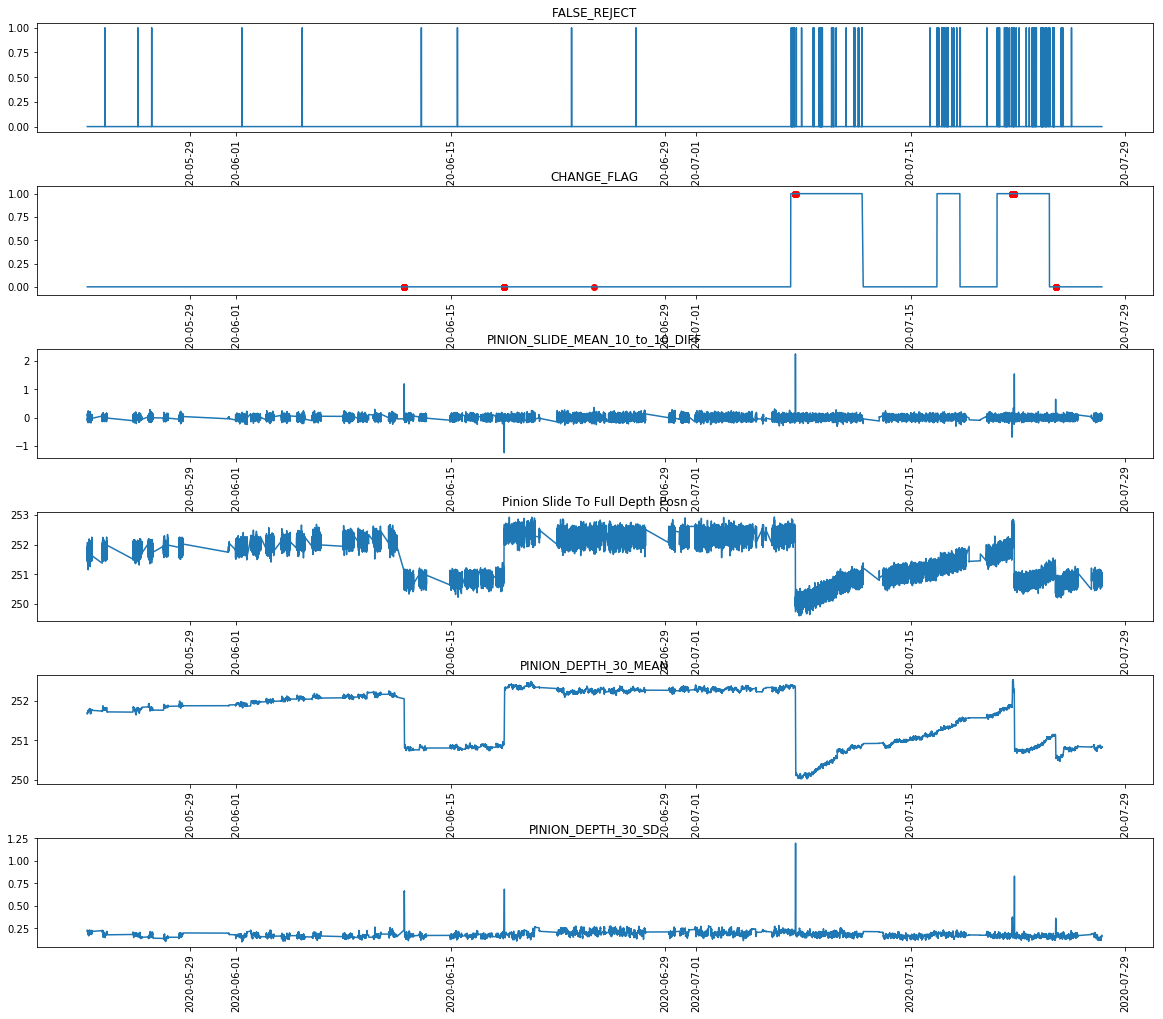

In [85]:
features=['PINION_SLIDE_MEAN_10_to_10_DIFF','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

-0.00291294609894165
0.12598213407870548


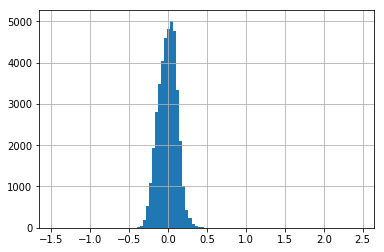

In [86]:
df1 = df.dropna(subset = ['PINION_SLIDE_MEDIAN_10_to_10_DIFF'])
df1["PINION_SLIDE_MEDIAN_10_to_10_DIFF"].hist(bins =100)
print(df1["PINION_SLIDE_MEDIAN_10_to_10_DIFF"].mean())
print(df1["PINION_SLIDE_MEDIAN_10_to_10_DIFF"].std())

In [87]:
import scipy.stats as st
cutoff = 0.00001
z_high = st.norm.ppf(1-cutoff)
z_low = st.norm.ppf(cutoff)
df1["Z_SCORE"]= st.zscore(df1["PINION_SLIDE_MEDIAN_10_to_10_DIFF"])
df1["DRIFT"]  = np.where((df1["Z_SCORE"]>= z_high) | (df1["Z_SCORE"]<= z_low),1,0)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

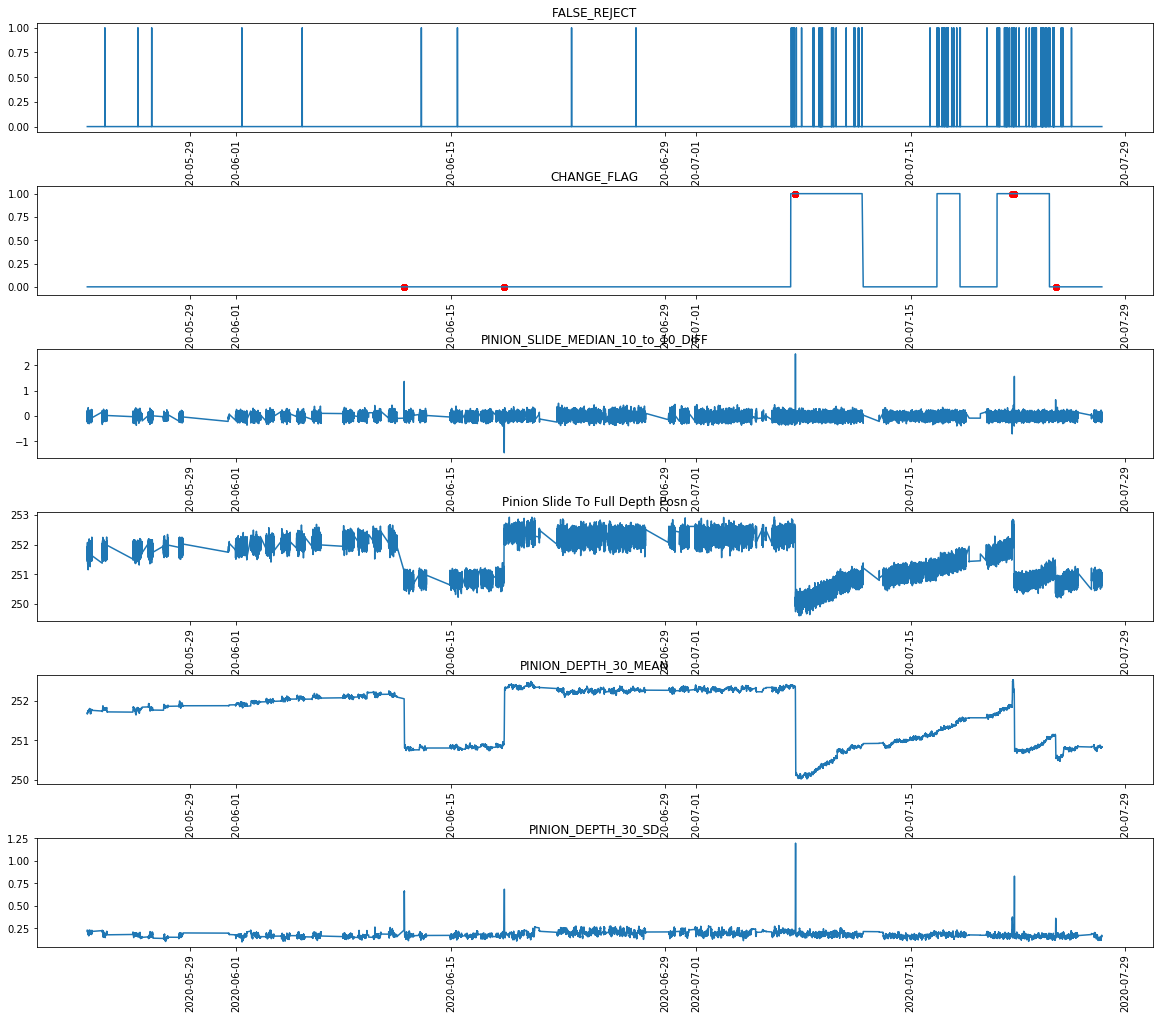

In [88]:
features=['PINION_SLIDE_MEDIAN_10_to_10_DIFF','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

0.008785400009727346
0.056244533786975255


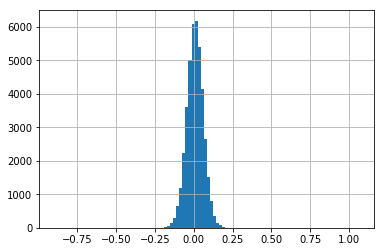

In [89]:
df1 = df.dropna(subset = ['PINION_SLIDE_STD_10_to_10_DIFF'])
df1["PINION_SLIDE_STD_10_to_10_DIFF"].hist(bins =100)
print(df1["PINION_SLIDE_STD_10_to_10_DIFF"].mean())
print(df1["PINION_SLIDE_STD_10_to_10_DIFF"].std())

In [90]:
import scipy.stats as st
cutoff = 0.00001
z_high = st.norm.ppf(1-cutoff)
z_low = st.norm.ppf(cutoff)
df1["Z_SCORE"]= st.zscore(df1["PINION_SLIDE_STD_10_to_10_DIFF"])
df1["DRIFT"]  = np.where((df1["Z_SCORE"]>= z_high) | (df1["Z_SCORE"]<= z_low),1,0)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\si

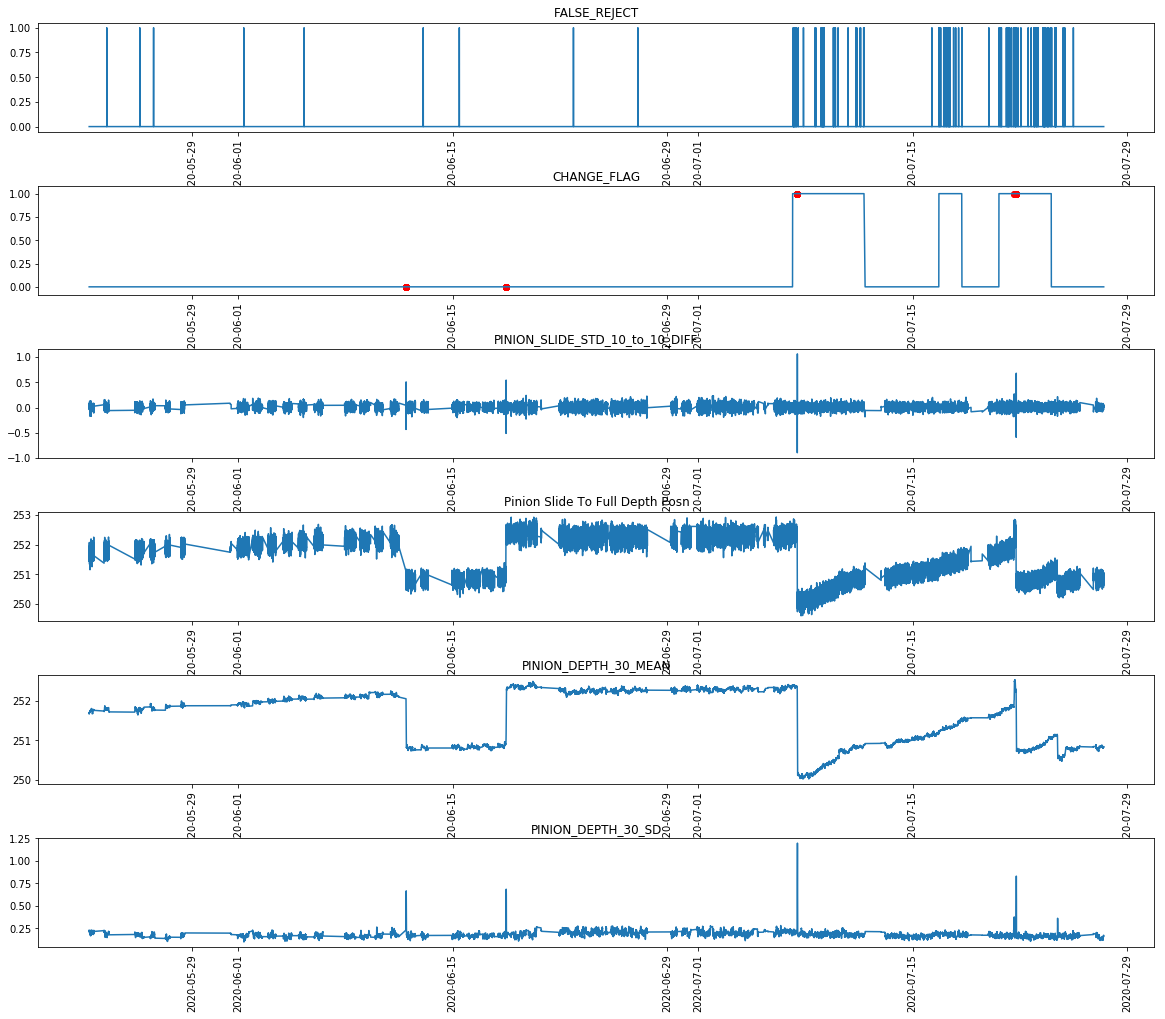

In [91]:
features=['PINION_SLIDE_STD_10_to_10_DIFF','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN','PINION_DEPTH_30_SD']

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['DRIFT'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("CHANGE_FLAG")
plt.xticks(rotation = 90,)


for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

# Statistical Methods

## Gaussian Model Based

## Box Plot Rule

## Grubbs rule (z score) Univariate

## Student's t-test Univariate

## Hotelling t square test Multivariate

# Machine Learning Based Methods (Density Based)

### Try PCA as well

## K-Nearest Neighbour

## Local Outlier Factor(LOF)

In [596]:
from sklearn.neighbors import LocalOutlierFactor


outliers_fraction = 0.01
# Take useful feature and standardize them 
# features = ['FALSE_REJECT','FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
#           'PINION_DEPTH_30_SD','DAY_OF_WEEK','HOUR','THROUGHPUT_RATE','FP_30_MEAN_DECON_DIFF',
#              'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
#              'PINION_DEPTH_30_SD_DECON_DIFF']
features = ['FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
          'PINION_DEPTH_30_SD','THROUGHPUT_RATE','FP_30_MEAN_DECON_DIFF',
             'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
             'PINION_DEPTH_30_SD_DECON_DIFF']


df1 = df.dropna(subset = features)
df1.reset_index(inplace=True, drop = True)
data = df1[features]

data.dropna(inplace = True)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

clf = LocalOutlierFactor(n_neighbors=50, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outliers_fraction)
y_pred = clf.fit_predict(data)
scores_prediction = clf.negative_outlier_factor_
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
df1['anomaly27'] = y_pred

print(df1['anomaly27'].value_counts())
# n_errors = (y_pred != Y).sum()
#     # Run Classification Metrics
# print("{}: {}".format(clf_name,n_errors))
# print("Accuracy Score :")
# print(accuracy_score(Y,y_pred))
# print("Classification Report :")
# print(classification_report(Y,y_pred))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    36273
1      367
Name: anomaly27, dtype: int64


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


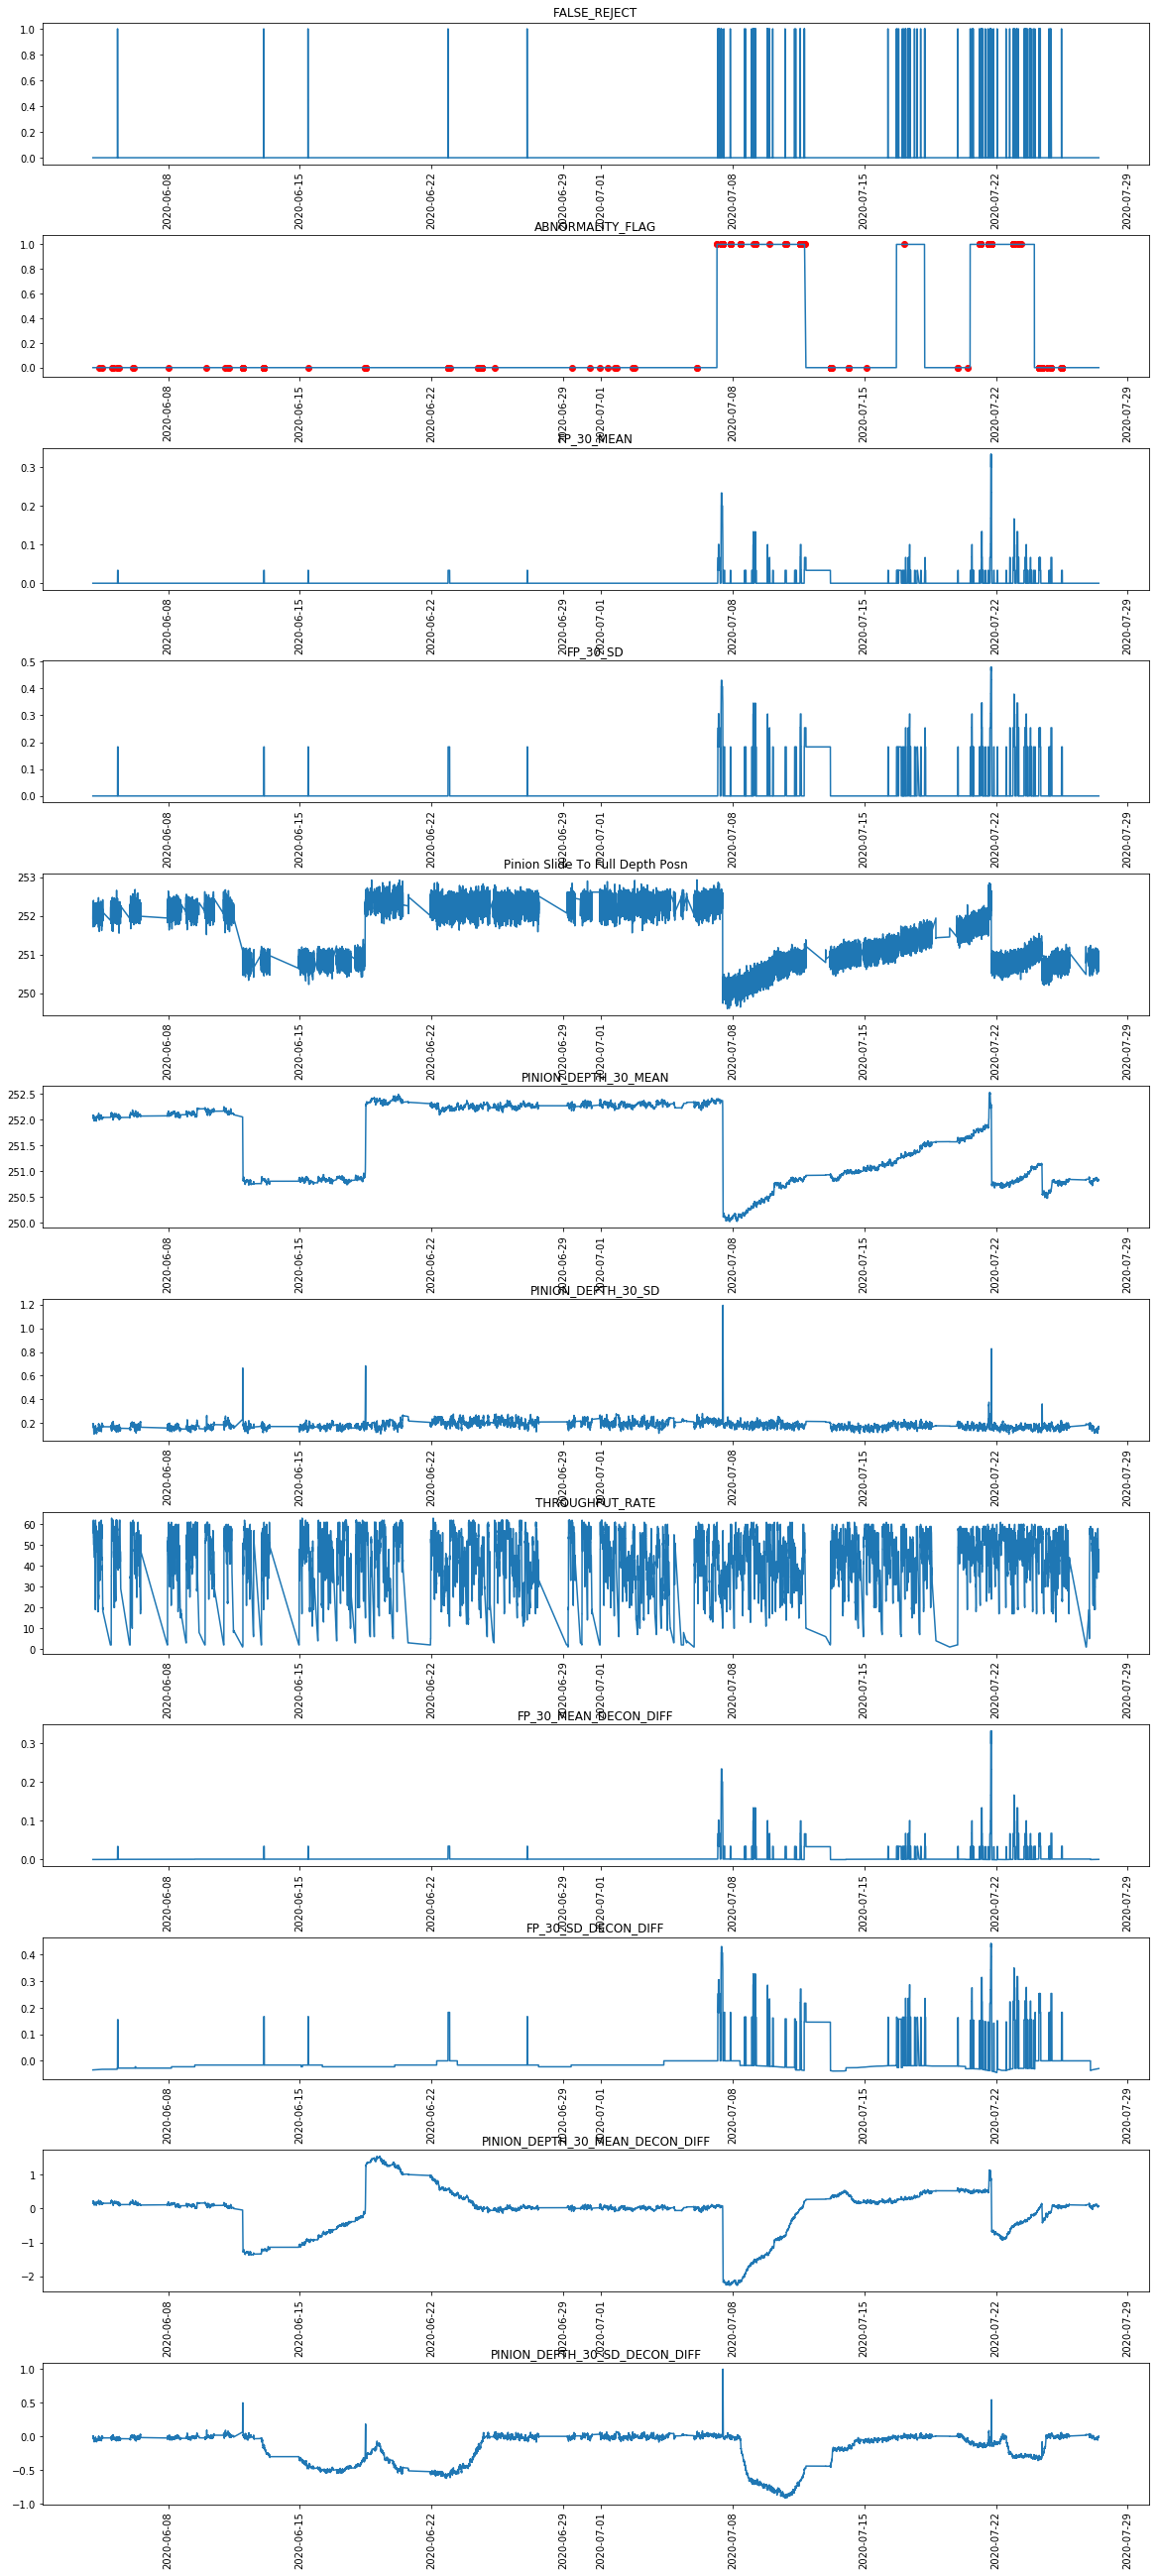

In [300]:
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,50))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['anomaly27'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)



for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

## Isolation Forest

In [580]:
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
outliers_fraction = 0.02
# Take useful feature and standardize them 
# features = ['FALSE_REJECT','FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
#           'PINION_DEPTH_30_SD','DAY_OF_WEEK','HOUR','THROUGHPUT_RATE','FP_30_MEAN_DECON_DIFF',
#              'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
#              'PINION_DEPTH_30_SD_DECON_DIFF']
features = ['FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
          'PINION_DEPTH_30_SD','FP_30_MEAN_DECON_DIFF',
             'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
             'PINION_DEPTH_30_SD_DECON_DIFF']


df1 = df.dropna(subset = features)
df1.reset_index(inplace=True, drop = True)
data = df1[features]



data.dropna(inplace = True)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df1['anomaly25'] = pd.Series(model.predict(data))
df1['anomaly25'] = df1['anomaly25'].map( {1: 0, -1: 1} )
print(df1['anomaly25'].value_counts())

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

0    35908
1      732
Name: anomaly25, dtype: int64


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


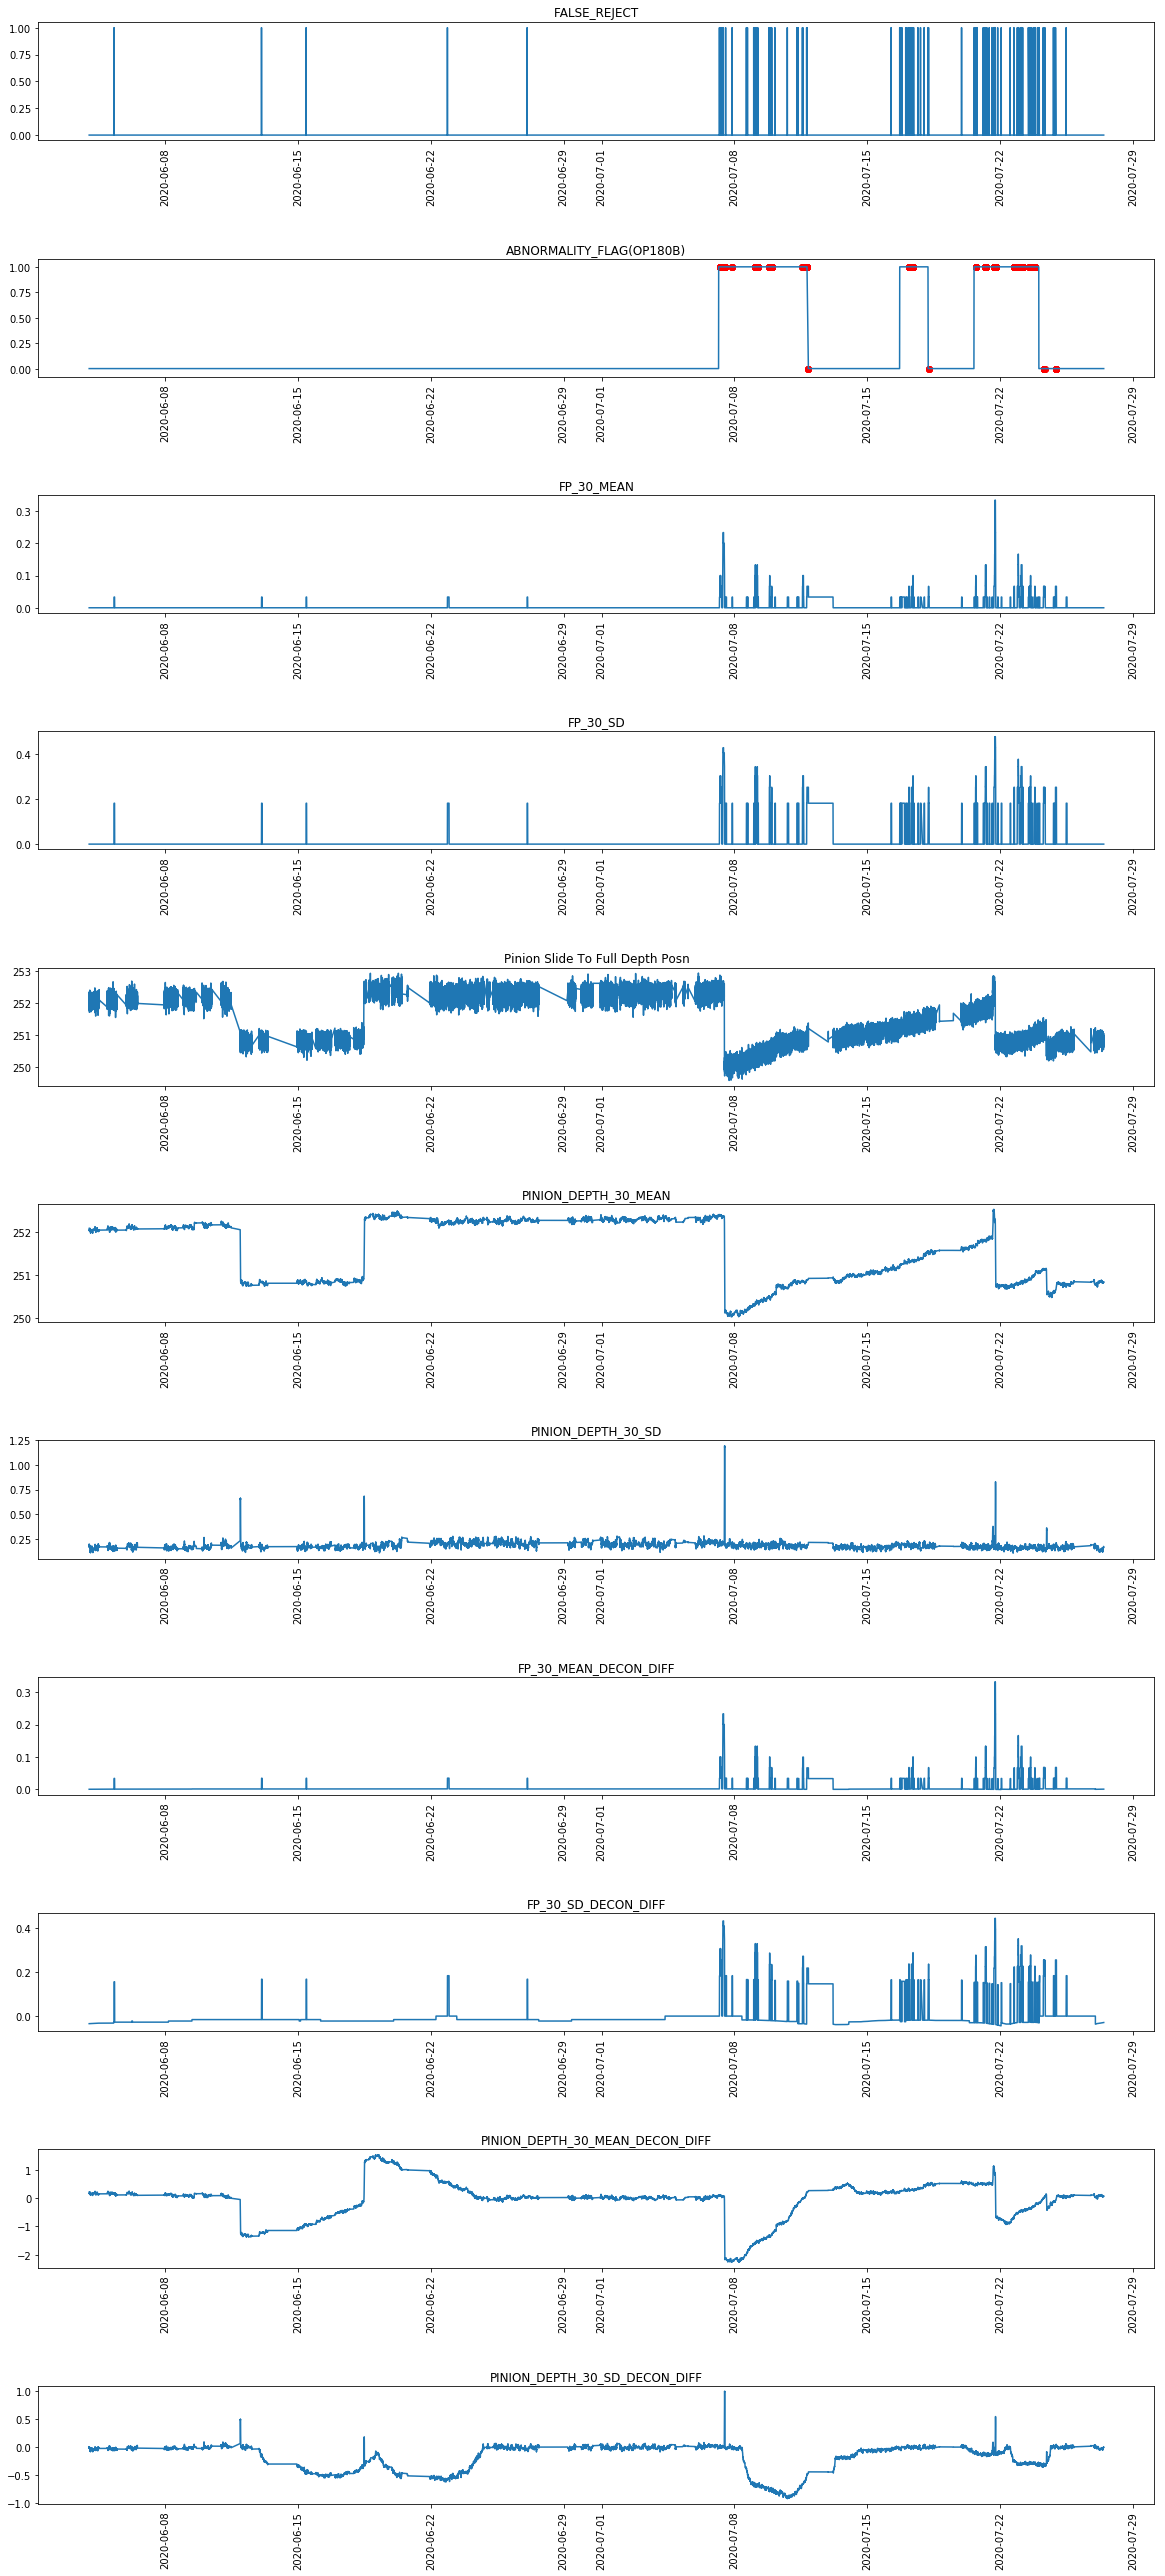

In [581]:
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,50))
plt.subplots_adjust(hspace = 1)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['anomaly25'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("ABNORMALITY_FLAG(OP180B)")
plt.xticks(rotation = 90,)



for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

### Tune Hyperparameters

In [648]:
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
outliers_fraction = 0.025
# Take useful feature and standardize them 
# features = ['FALSE_REJECT','FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
#           'PINION_DEPTH_30_SD','DAY_OF_WEEK','HOUR','THROUGHPUT_RATE','FP_30_MEAN_DECON_DIFF',
#              'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
#              'PINION_DEPTH_30_SD_DECON_DIFF']
features = ['FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
          'PINION_DEPTH_30_SD','FP_30_MEAN_DECON_DIFF',
             'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
             'PINION_DEPTH_30_SD_DECON_DIFF']


df1 = df.dropna(subset = features)
df1.reset_index(inplace=True, drop = True)
data = df1[features]



data.dropna(inplace = True)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df1['anomaly25'] = pd.Series(model.predict(data))
df1['anomaly25'] = df1['anomaly25'].map( {1: 0, -1: 1} )
print(df1['anomaly25'].value_counts())

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

0    35726
1      914
Name: anomaly25, dtype: int64


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


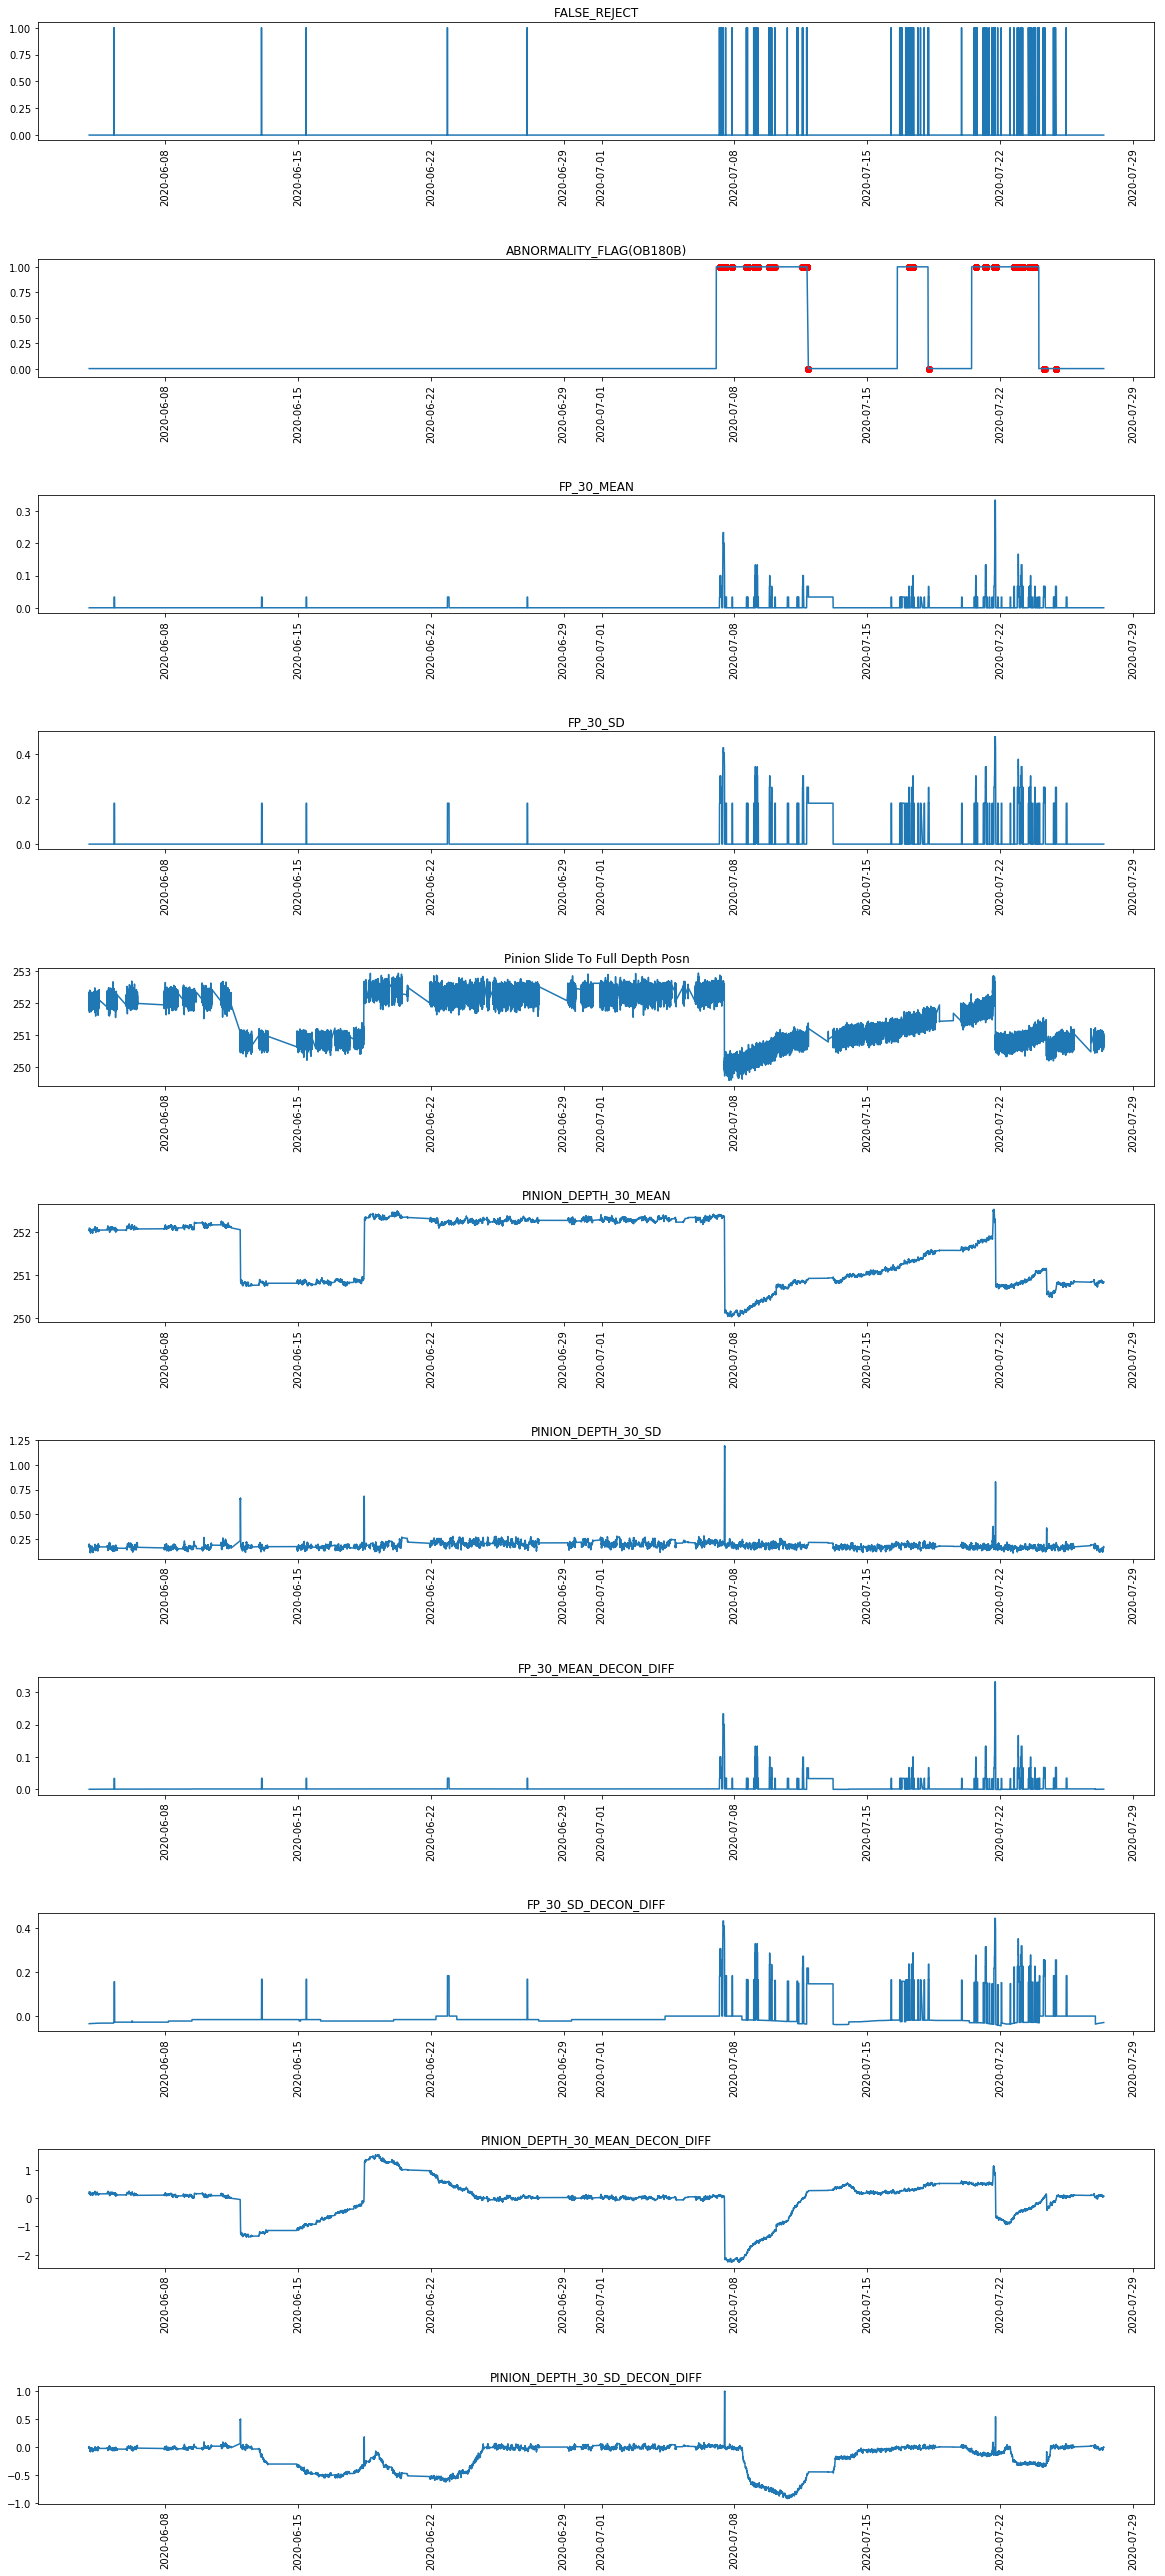

In [649]:
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,50))
plt.subplots_adjust(hspace = 1)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['anomaly25'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("ABNORMALITY_FLAG(OB180B)")
plt.xticks(rotation = 90,)

for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

In [650]:
x=0

windows_name = ['1','2','3']
for y in windows_name:
    index_model = df1[(df1["ABNORMALITY_WINDOW"]==y) & (df1["anomaly25"]==1)].index.min()
    index_actual = df1[(df1["ABNORMALITY_WINDOW"]==y) & (df1["ABNORMALITY_FLAG"]==1)].index.min()
    if index_model >= index_actual:
        x=x+df1.loc[index_actual:index_model,"FALSE_REJECT"].sum()
        print(x)
print("AVG count of False Reject till Detect :" + str(x/len(windows_name)))

2
9
12
AVG count of False Reject till Detect :4.0


# Machine Learning Based Methods (Clustering Based)

## K Means Clustering
Giving varying result due the random selection of initial point during clustering 

In [352]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

outliers_fraction = 0.03
# Take useful feature and standardize them
features = ['FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
          'PINION_DEPTH_30_SD','THROUGHPUT_RATE','FP_30_MEAN_DECON_DIFF',
             'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
             'PINION_DEPTH_30_SD_DECON_DIFF']


df1 = df.dropna(subset = features)
df1.reset_index(inplace=True, drop = True)
data = df1[features]

data.dropna(inplace = True)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [353]:
pca.components_

array([[ 0.4813278 ,  0.48510448, -0.15920511, -0.15483777,  0.04455608,
        -0.03697147,  0.48143537,  0.48061068, -0.11290846, -0.06934763],
       [ 0.13414133,  0.10417658,  0.54413472,  0.55437562,  0.19709314,
        -0.00469128,  0.13620949,  0.11456701,  0.4606001 ,  0.29161557]])

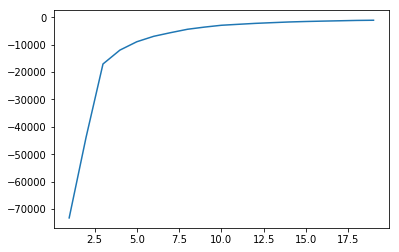

In [370]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i, random_state=3).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [371]:
# I choose 7 centroids arbitrarily and add these data to the central dataframe
df1['cluster'] = kmeans[7].predict(data)
df1['principal_feature1'] = data[0]
df1['principal_feature2'] = data[1]
df1['cluster'].value_counts()

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy o

6    18790
2     6852
0     5871
5     2320
7     1140
3      977
1      628
4       62
Name: cluster, dtype: int64

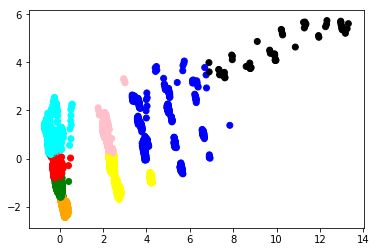

In [372]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow'
#           , 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'
         }
ax.scatter(df1['principal_feature1'], df1['principal_feature2'], c=df1["cluster"].apply(lambda x: colors[x]))
plt.show()

In [373]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance


# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df1['anomaly21'] = (distance >= threshold).astype(int)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


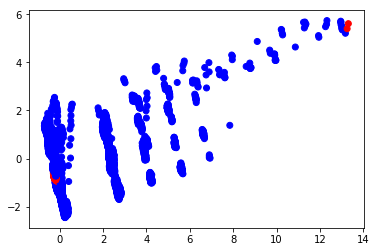

In [374]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df1['principal_feature1'], df1['principal_feature2'], c=df1["anomaly21"].apply(lambda x: colors[x]))
plt.show()

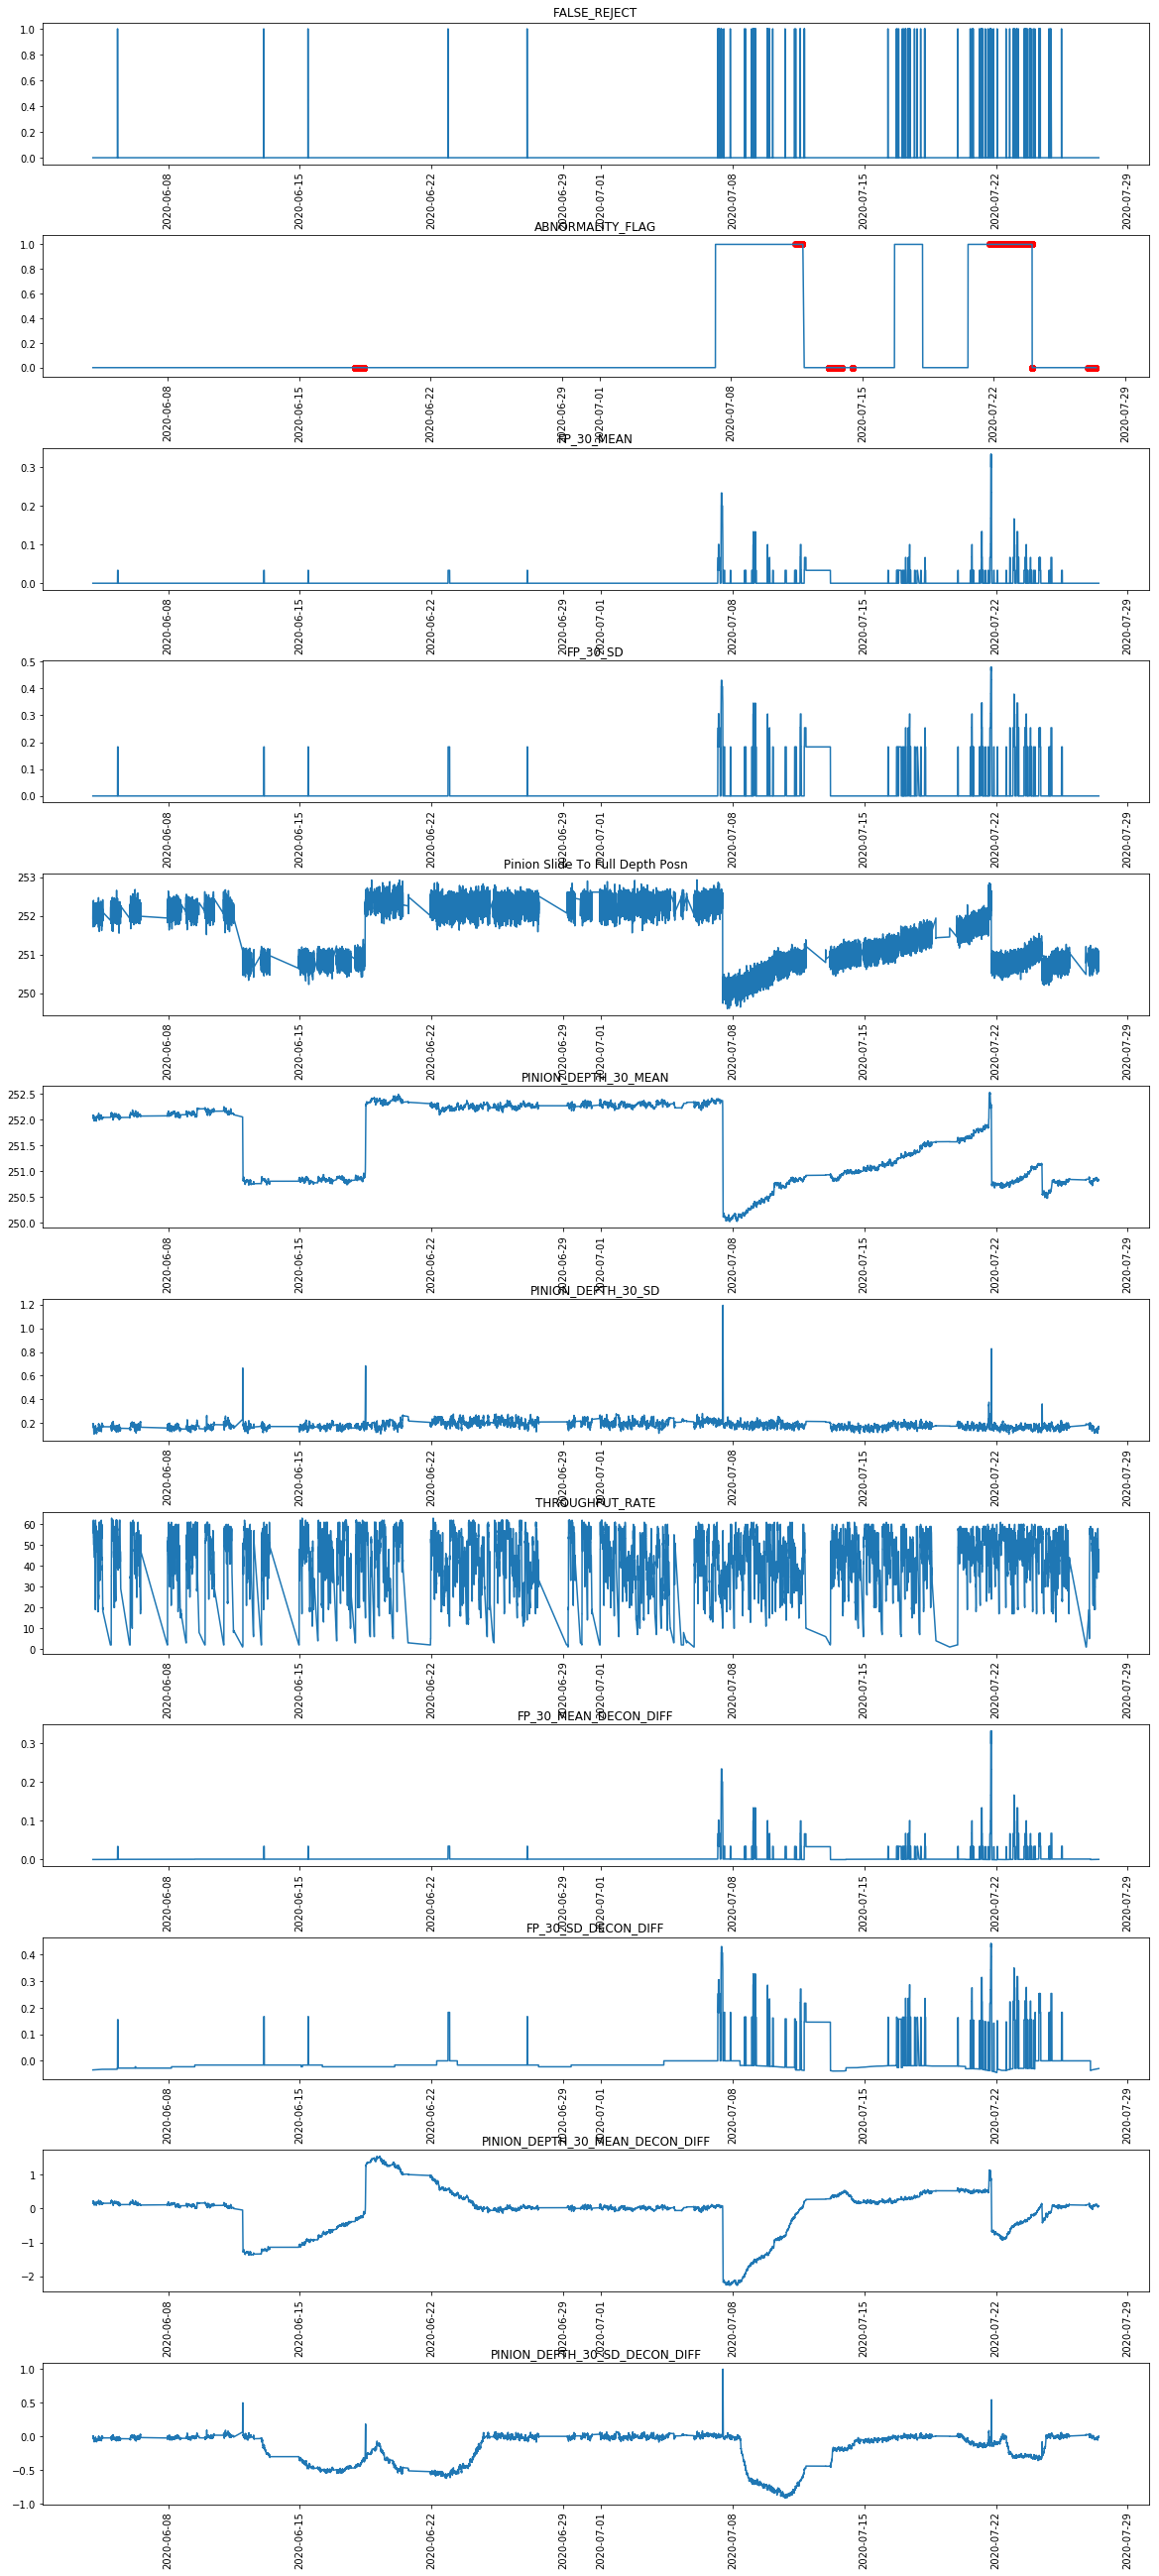

In [375]:
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,50))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['anomaly21'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)



for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

# Machine Learning Based Methods (Support Vector Based)

## OneClassCVM

In [288]:
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
outliers_fraction = 0.015
# Take useful feature and standardize them 
# features = ['FALSE_REJECT','FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
#           'PINION_DEPTH_30_SD','DAY_OF_WEEK','HOUR','THROUGHPUT_RATE','FP_30_MEAN_DECON_DIFF',
#              'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
#              'PINION_DEPTH_30_SD_DECON_DIFF']
features = ['FP_30_MEAN','FP_30_SD','Pinion Slide To Full Depth Posn','PINION_DEPTH_30_MEAN',
          'PINION_DEPTH_30_SD','FP_30_MEAN_DECON_DIFF',
             'FP_30_SD_DECON_DIFF','PINION_DEPTH_30_MEAN_DECON_DIFF',
             'PINION_DEPTH_30_SD_DECON_DIFF']


df1 = df.dropna(subset = features)
df1.reset_index(inplace=True, drop = True)
data = df1[features]


min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df1['anomaly26'] = pd.Series(model.predict(data))
df1['anomaly26'] = df1['anomaly26'].map( {1: 0, -1: 1} )
print(df1['anomaly26'].value_counts())

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    36119
1      521
Name: anomaly26, dtype: int64


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


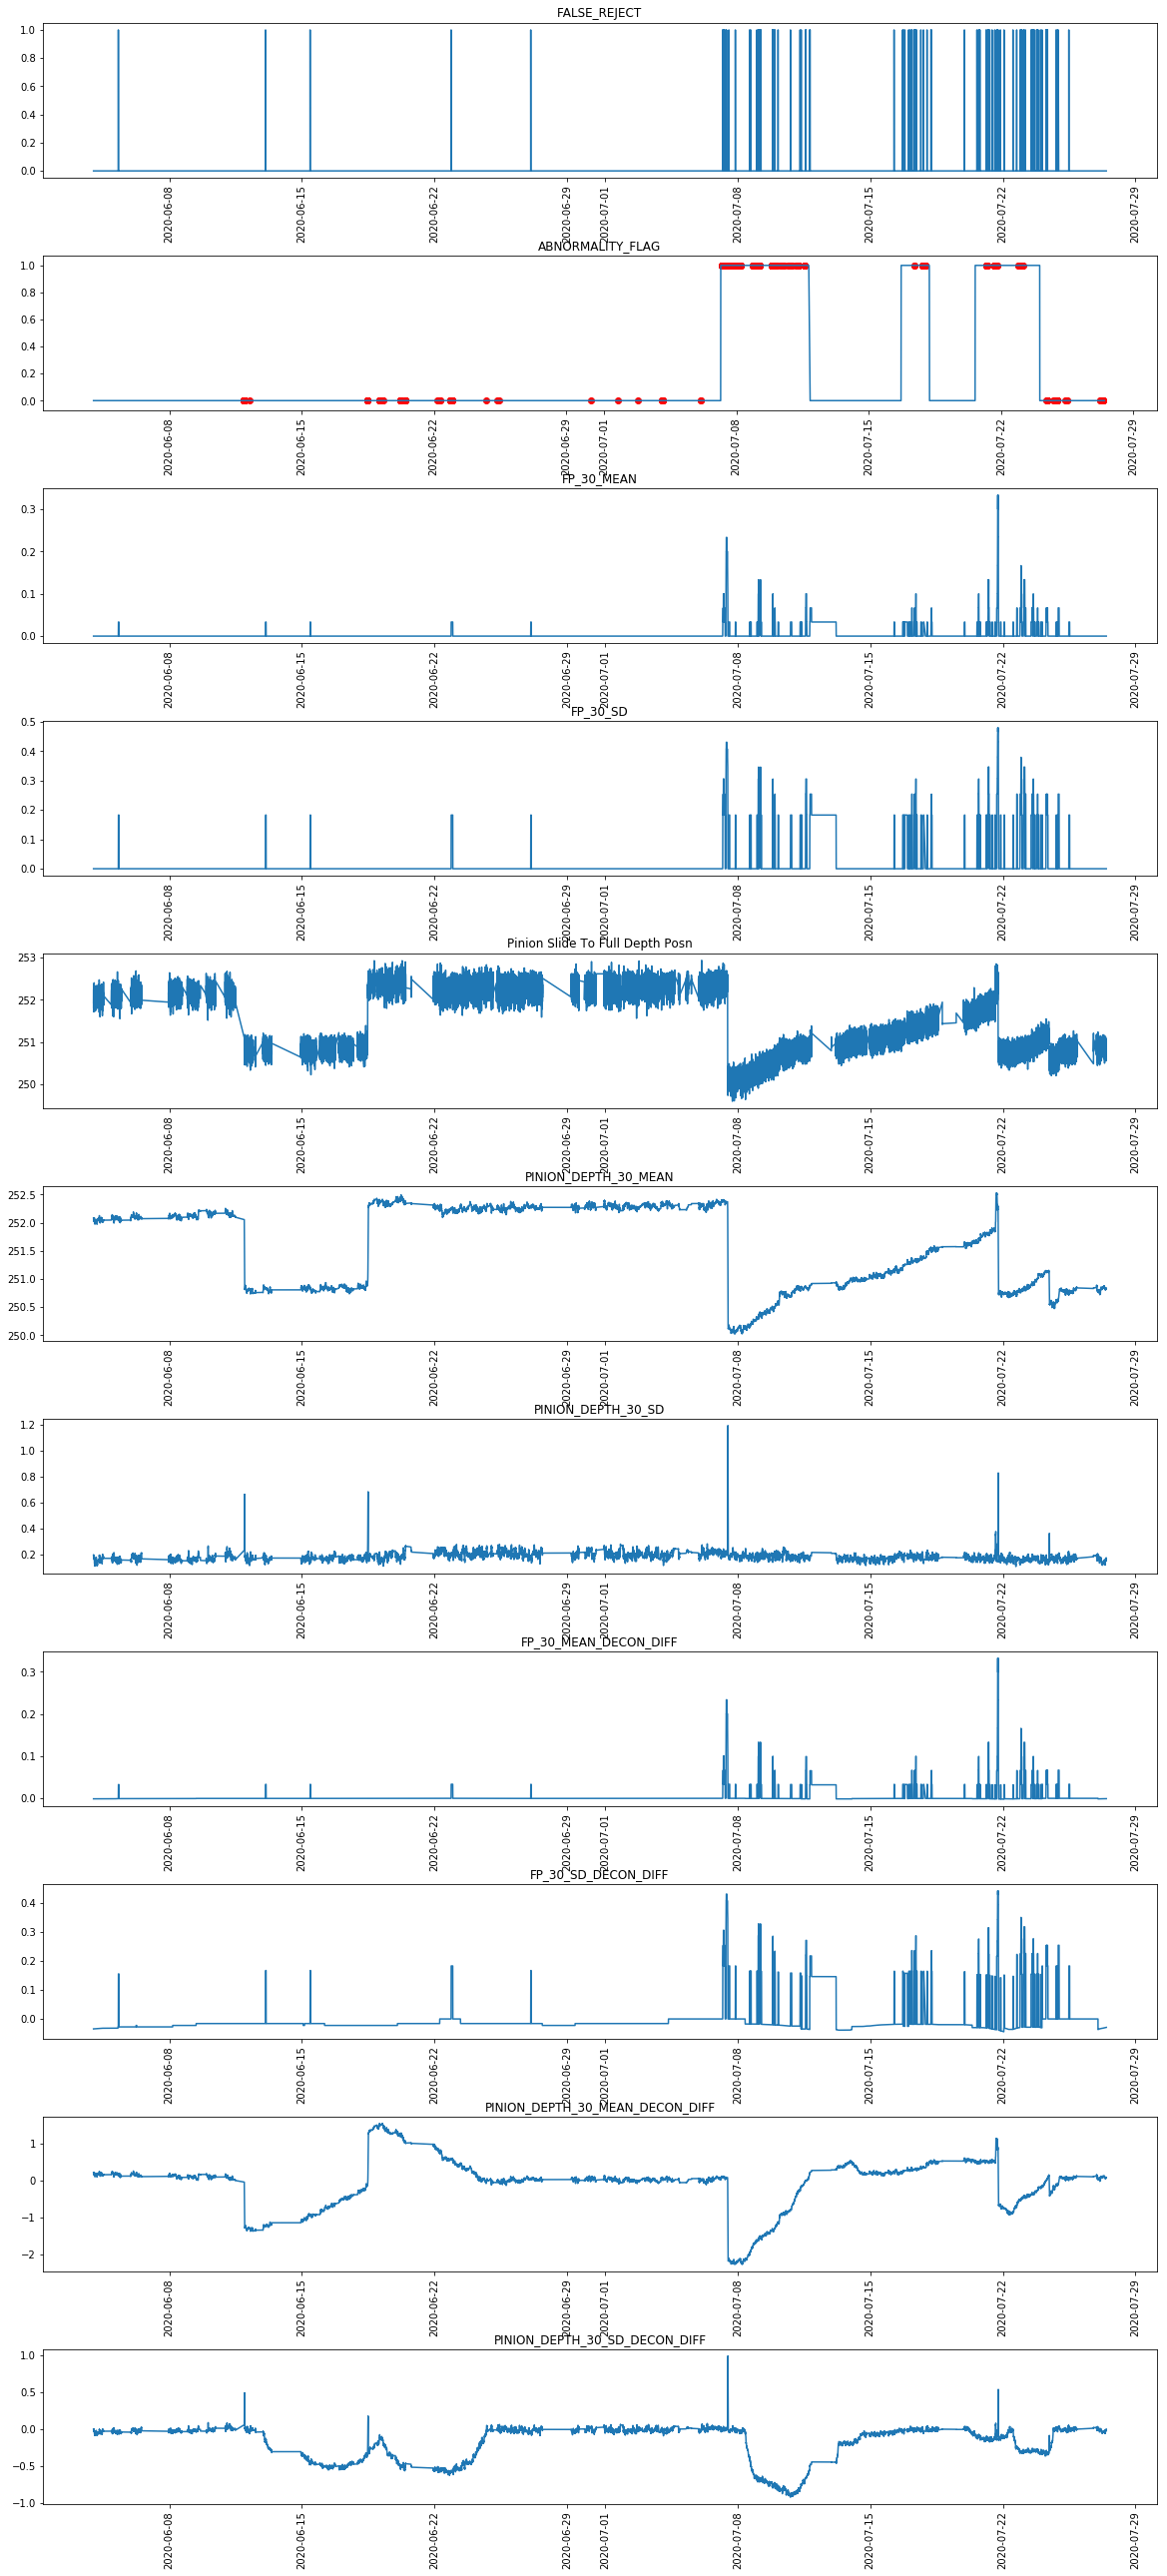

In [289]:
n_graphs = len(features)+3
fig = plt.figure(figsize = (20,50))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['anomaly26'] == 1, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)



for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

# Time Series Forcasting and Deviation based

## LSTM

## ARIMA

## PEWMA

## RNN

# Supervised Learning

## Xgboost

In [544]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

In [545]:
## Variable importance
def fimportances(xc, predictors):
    importances = pd.DataFrame({'predictor': predictors, 'importance': xc.feature_importances_})
    importances = importances[importances['importance'] > 0]
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.reset_index(inplace=True, drop=True)
    importances = importances[['predictor', 'importance']]
    return importances

In [559]:
x_column = ['FP_30_MEAN',
 'FP_60_MEAN',
 'FP_200_MEAN',
'FP_30_SD',
 'FP_60_SD',
 'FP_200_SD',
'FP_30_MEAN_DECON_DIFF',
'FP_30_SD_DECON_DIFF'
           ]

# x_column = [
#  'LH Slide To Full Depth Posn',
#  'NVH Torque Sweep Test Cycle Count',
#  'Pinion Slide To Full Depth Posn',
#  'RH Slide To Full Depth Posn',
#  'FALSE_REJECT',
#  'FP_500_C',
#  'DAY_OF_WEEK',
#  'HOUR',
#  'FP_30_MEAN',
#  'FP_60_MEAN',
#  'FP_200_MEAN',
#  'FP_500_MEAN',
#  'PINION_DEPTH_30_MEAN',
#  'PINION_DEPTH_60_MEAN',
#  'PINION_DEPTH_200_MEAN',
#  'PINION_DEPTH_500_MEAN',
#  'LH_30_MEAN',
#  'LH_60_MEAN',
#  'LH_200_MEAN',
#  'LH_500_MEAN',
#  'RH_30_MEAN',
#  'RH_60_MEAN',
#  'RH_200_MEAN',
#  'RH_500_MEAN',
#  'THROUGHPUT_RATE',
#  'RH_30_SD',
#  'RH_60_SD',
#  'RH_200_SD',
#  'RH_500_SD',
#  'LH_30_SD',
#  'LH_60_SD',
#  'LH_200_SD',
#  'LH_500_SD',
#  'PINION_DEPTH_30_SD',
#  'PINION_DEPTH_60_SD',
#  'PINION_DEPTH_200_SD',
#  'PINION_DEPTH_500_SD',
#  'FP_30_SD',
#  'FP_60_SD',
#  'FP_200_SD',
#  'FP_500_SD',
#  'FP_30_MEAN_DIFF',
#  'FP_30_SD_DIFF',
#  'FP_30_MEAN_DECON_DIFF',
#  'FP_30_SD_DECON_DIFF',
#  'PINION_DEPTH_30_MEAN_DIFF',
#  'PINION_DEPTH_30_SD_DIFF',
#  'PINION_DEPTH_30_MEAN_DECON_DIFF',
#  'PINION_DEPTH_30_SD_DECON_DIFF',
#  'LH_30_MEAN_DIFF',
#  'LH_30_SD_DIFF',
#  'LH_30_MEAN_DECON_DIFF',
#  'LH_30_SD_DECON_DIFF',
#  'RH_30_MEAN_DIFF',
#  'RH_30_SD_DIFF',
#  'RH_30_MEAN_DECON_DIFF',
#  'RH_30_SD_DECON_DIFF',
#  'FP_60_MEAN_DIFF',
#  'FP_60_SD_DIFF',
#  'FP_60_MEAN_DECON_DIFF',
#  'FP_60_SD_DECON_DIFF',
#  'PINION_DEPTH_60_MEAN_DIFF',
#  'PINION_DEPTH_60_SD_DIFF',
#  'PINION_DEPTH_60_MEAN_DECON_DIFF',
#  'PINION_DEPTH_60_SD_DECON_DIFF',
#  'LH_60_MEAN_DIFF',
#  'LH_60_SD_DIFF',
#  'LH_60_MEAN_DECON_DIFF',
#  'LH_60_SD_DECON_DIFF',
#  'RH_60_MEAN_DIFF',
#  'RH_60_SD_DIFF',
#  'RH_60_MEAN_DECON_DIFF',
#  'RH_60_SD_DECON_DIFF',
#  'FP_200_MEAN_DIFF',
#  'FP_200_SD_DIFF',
#  'FP_200_MEAN_DECON_DIFF',
#  'FP_200_SD_DECON_DIFF',
#  'PINION_DEPTH_200_MEAN_DIFF',
#  'PINION_DEPTH_200_SD_DIFF',
#  'PINION_DEPTH_200_MEAN_DECON_DIFF',
#  'PINION_DEPTH_200_SD_DECON_DIFF',
#  'LH_200_MEAN_DIFF',
#  'LH_200_SD_DIFF',
#  'LH_200_MEAN_DECON_DIFF',
#  'LH_200_SD_DECON_DIFF',
#  'RH_200_MEAN_DIFF',
#  'RH_200_SD_DIFF',
#  'RH_200_MEAN_DECON_DIFF',
#  'RH_200_SD_DECON_DIFF',
#  'FP_500_MEAN_DIFF',
#  'FP_500_SD_DIFF',
#  'FP_500_MEAN_DECON_DIFF',
#  'FP_500_SD_DECON_DIFF',
#  'PINION_DEPTH_500_MEAN_DIFF',
#  'PINION_DEPTH_500_SD_DIFF',
#  'PINION_DEPTH_500_MEAN_DECON_DIFF',
#  'PINION_DEPTH_500_SD_DECON_DIFF',
#  'LH_500_MEAN_DIFF',
#  'LH_500_SD_DIFF',
#  'LH_500_MEAN_DECON_DIFF',
#  'LH_500_SD_DECON_DIFF',
#  'RH_500_MEAN_DIFF',
#  'RH_500_SD_DIFF',
#  'RH_500_MEAN_DECON_DIFF',
#  'RH_500_SD_DECON_DIFF']
y_column = 'ABNORMALITY_FLAG'
seed = 1

In [560]:
df_train = df[df["PROD_TIMESTAMP"]< pd.datetime(2020,7,13)]
df_valid = df[(df["PROD_TIMESTAMP"]>= pd.datetime(2020,7,13)) &  (df["PROD_TIMESTAMP"]< pd.datetime(2020,7,18)) ]
df_test = df[df["PROD_TIMESTAMP"]>= pd.datetime(2020,7,18)]

df_train.dropna(inplace = True)
df_test.dropna(inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [561]:
X_test = df_test[x_column]
y_test = df_test[y_column]
X_train = df_train[x_column]
y_train = df_train[y_column]
X_valid = df_valid[x_column]
y_valid = df_valid[y_column]



# X_train, X_valid, y_train, y_valid = train_test_split(df_train[x_column], df_train[y_column], test_size=0.2, random_state=seed)
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)


Event rate in train set : 16.89%

 Train set shape: (24735, 8)

Event rate in test set : 65.38%

 Test set shape: (3481, 8)

Event rate in validation set : 23.49%

 validation set shape: (4424, 8)


In [562]:
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

evals=[(X_train, np.ravel(y_train)),(X_valid, np.ravel(y_valid))]

bst = xgb_model.fit(X_train, np.ravel(y_train), eval_metric="auc", eval_set=evals,
                    early_stopping_rounds=40   ,  verbose=False)

In [563]:
imp = fimportances(bst,X_train.columns)

In [564]:
bst1 = bst
X_train_1 = X_train
X_valid_1 = X_valid
select_X_train = X_train_1

dic_imp = {"n":[imp.shape[0]],"Gini Train":[0],"Gini Test":[0],"Predictors":[list(imp['predictor'])]}

while(select_X_train.shape[1] > 2):
    select_X_train = X_train_1[list(imp['predictor'])[:-1]]
    select_X_valid = X_valid_1[list(imp['predictor'])[:-1]]
    xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

    evals=[(select_X_train, np.ravel(y_train)),(select_X_valid, np.ravel(y_valid))]

    bst = xgb_model.fit(select_X_train, np.ravel(y_train), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=40   ,  verbose=False)
    
    ypred_train = bst.predict_proba(select_X_train)[:, 1]
    ypred_test  = bst.predict_proba(select_X_valid)[:, 1]
    
    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_valid, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1
    
    print("Columns Remaining : %d , gini_train: %f,gini_test: %f "%(select_X_train.shape[1],gini_train,gini_test))
    
    dic_imp['n'].append(imp.shape[0])
    dic_imp['Gini Train'].append(gini_train)
    dic_imp['Gini Test'].append(gini_test)
    dic_imp['Predictors'].append(list(imp['predictor']))
    
    imp = fimportances(bst,select_X_train.columns)

Columns Remaining : 7 , gini_train: 0.995074,gini_test: 0.964404 
Columns Remaining : 5 , gini_train: 0.832231,gini_test: 0.929613 
Columns Remaining : 4 , gini_train: 0.994385,gini_test: 0.966335 
Columns Remaining : 3 , gini_train: 0.935522,gini_test: 0.969401 
Columns Remaining : 2 , gini_train: 0.963830,gini_test: 0.309262 


In [565]:
df_imp =pd.DataFrame(dic_imp)

In [567]:
selected_vars = list(df_imp[df_imp['n']==3]["Predictors"])

In [568]:
selected_vars

[['FP_30_SD_DECON_DIFF', 'FP_30_MEAN_DECON_DIFF', 'FP_200_MEAN']]

In [569]:
X_train_2=X_train[selected_vars[0]]
X_test_2=X_test[selected_vars[0]]
X_valid_2=X_valid[selected_vars[0]]

print("\n Train shape:",X_train_2.shape,"\n Test shape:",X_test_2.shape,"\n Validation shape:",X_valid_2.shape)


 Train shape: (24735, 3) 
 Test shape: (3481, 3) 
 Validation shape: (4424, 3)


In [570]:
# set model parameters 
missing_value=None; cpu=-1; early_stopping_round=40; split_random_state=None
kfolds = StratifiedKFold(4, random_state=1)

In [571]:
## XGB model## The model is pretty stable with default parameters(after variable selection), hence not tuning any more
param_grid = {'max_depth': list(range(1, 6)),
              'learning_rate': np.arange(0.001, 0.02, 0.001),
              'subsample': np.arange(0.4, 0.7,0.05),
              'min_child_weight': np.arange(1, 25, 3),
              'colsample_bytree': np.arange(0.5, 0.75, 0.05),
              'scale_pos_weight' :np.arange(5, 40, 5)
            }

if X_train_2.shape[1] == 1:
    param_grid['colsample_bytree'] = [1]
    
param_dist = {'objective': 'binary:logistic', 'nthread': cpu, 'n_estimators': 200}
xgb_model = xgb.XGBClassifier(**param_dist)

##random search XGB    
clf = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring=['roc_auc'], n_iter=20,
                         random_state=40, cv=kfolds.split(X_train_2, y_train), refit='roc_auc',error_score=0, return_train_score =True)
print("Randomized search..")
search_time_start = time.time()
clf.fit(X_train_2, np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)
params = clf.best_params_

dic=clf.cv_results_

params_bst = params
params_tbl = pd.DataFrame(columns=list(params_bst.keys()))  
params_tbl.loc['0'] = [params_bst[k] for k in params_tbl.columns]

print("Best score: {}".format(clf.best_score_))
print("Best params: ")
for param_name in sorted(params_bst.keys()):
    print('%s: %r' % (param_name, params_bst[param_name]))

params.update(param_dist)
xgb_model = xgb.XGBClassifier(**params)

Randomized search..
Randomized search time: 34.97208786010742
Best score: 0.8579825715668824
Best params: 
colsample_bytree: 0.5
learning_rate: 0.010000000000000002
max_depth: 2
min_child_weight: 13
scale_pos_weight: 10
subsample: 0.4


In [450]:
#First Run
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200
             )
#GINI TRAIN: 

#GINI Validation: 

#GINI CV: 

#Gini Test 

In [451]:
# cross validation gini
def xgboost(X_tr,X_ts,y_tr,y_ts):
    auc_cv = cross_val_score(xgb_model, X_tr, np.ravel(y_tr), scoring='roc_auc', cv=kfolds.split(X_tr, np.ravel(y_tr)),
                             n_jobs=1)
    gini_cv = (2 * np.array(auc_cv) - 1).mean()
    evals=[(X_tr, np.ravel(y_tr)),(X_ts, np.ravel(y_ts))]

    bst = xgb_model.fit(X_tr, np.ravel(y_tr), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=early_stopping_round   ,  verbose=False)

    if early_stopping_round is None:
        ypred_train = bst.predict_proba(X_tr)[:, 1]
        ypred_test = bst.predict_proba(X_ts)[:, 1]
    else:
        ypred_train = bst.predict_proba(X_tr, ntree_limit=bst.best_ntree_limit)[:, 1]
        ypred_test = bst.predict_proba(X_ts, ntree_limit=bst.best_ntree_limit)[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_tr, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_ts, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    return bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test

In [452]:
## run xgboost
bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test=xgboost(X_train_2, X_valid_2, y_train, y_valid)
##Model performance on sample
print("GINI TRAIN:",gini_train )
print("\nGINI Validation:",gini_test )
print("\nGINI CV:",gini_cv )

GINI TRAIN: 0.9999418772164115

GINI Validation: 0.8656676187050667

GINI CV: 0.8843044436649191


In [453]:
X_train_2.columns

Index(['PINION_DEPTH_30_MEAN_DECON_DIFF', 'PINION_DEPTH_500_SD',
       'PINION_DEPTH_30_MEAN', 'FP_30_SD', 'PINION_DEPTH_200_MEAN',
       'PINION_DEPTH_200_SD', 'PINION_DEPTH_500_MEAN', 'PINION_DEPTH_60_MEAN',
       'FP_500_MEAN', 'FP_60_MEAN', 'FP_30_MEAN_DECON_DIFF',
       'Pinion Slide To Full Depth Posn', 'FP_30_SD_DECON_DIFF',
       'PINION_DEPTH_60_SD', 'FP_500_SD', 'FP_200_SD', 'FP_60_SD'],
      dtype='object', name='CHARDESC')

In [454]:
#ypred_test = bst.predict_proba(X_test_2.drop(columns=['act','pred']), ntree_limit=bst.best_ntree_limit)[:, 1]
ypred_test = bst.predict_proba(X_test_2, ntree_limit=bst.best_ntree_limit)[:, 1]
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
print("Gini Test",metric_auc_test*2-1)

Gini Test -0.03721860437981761


In [455]:
df1 = df.dropna()
df1["XGB_SCORE"] = bst.predict_proba(df1[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


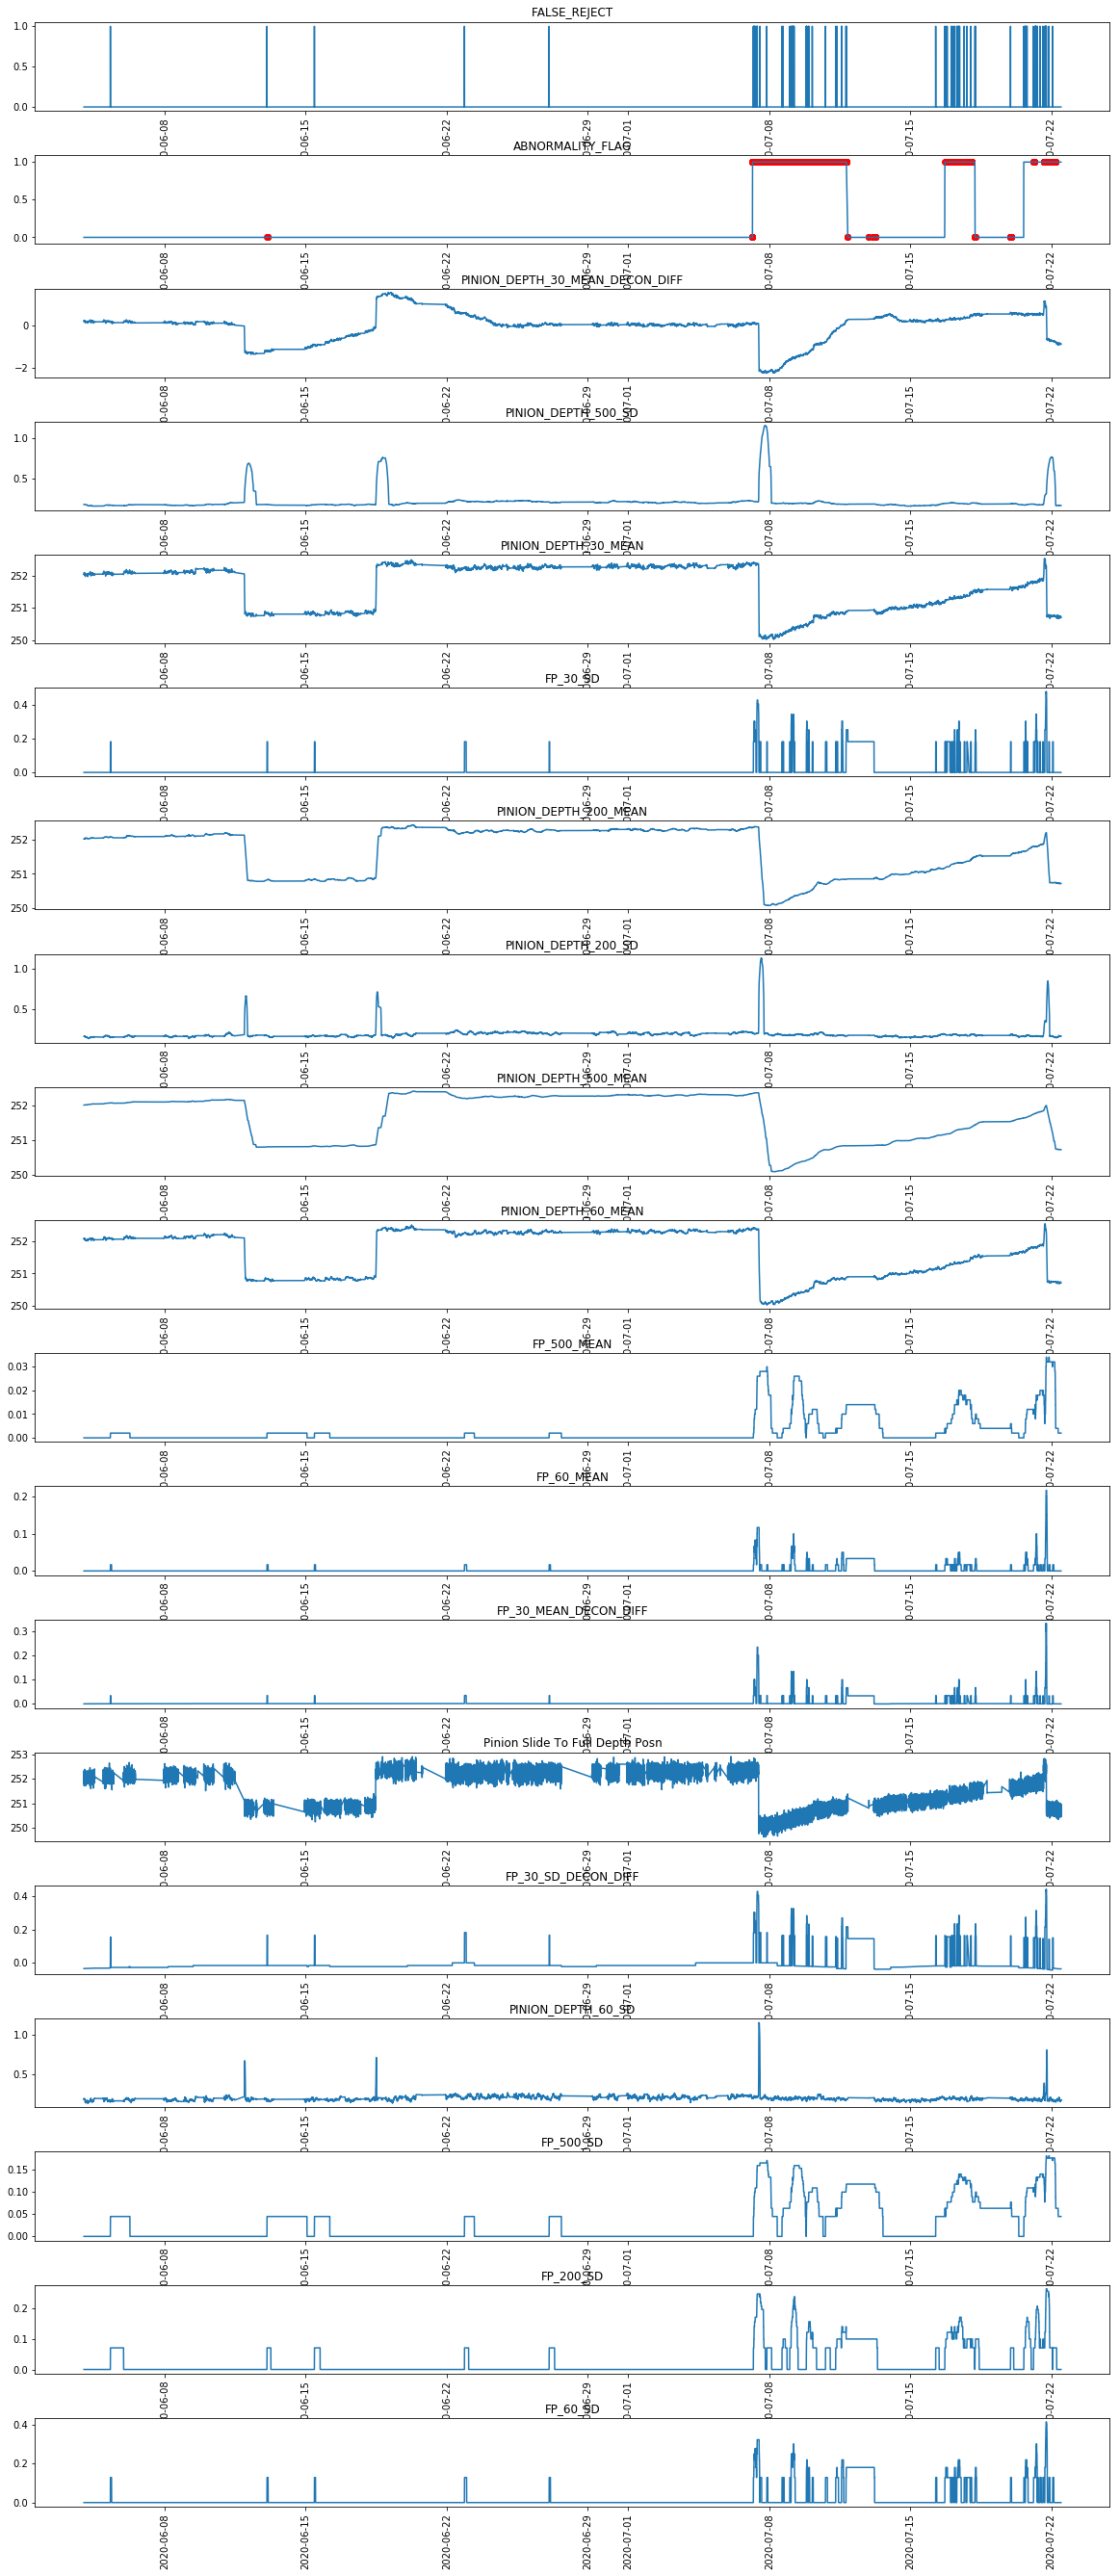

In [462]:
features = selected_vars[0]
cutoff = 0.51

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,50))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['XGB_SCORE'] >= cutoff, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)



for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

# Logistic Regression

In [531]:
x_column = ['FP_30_MEAN',
 'FP_60_MEAN',
 'FP_200_MEAN',
'FP_30_SD',
 'FP_60_SD',
 'FP_200_SD','FP_30_MEAN_DECON_DIFF',
             'FP_30_SD_DECON_DIFF']

# x_column = [
#  'LH Slide To Full Depth Posn',
#  'NVH Torque Sweep Test Cycle Count',
#  'Pinion Slide To Full Depth Posn',
#  'RH Slide To Full Depth Posn',
#  'FALSE_REJECT',
#  'FP_500_C',
#  'DAY_OF_WEEK',
#  'HOUR',
#  'FP_30_MEAN',
#  'FP_60_MEAN',
#  'FP_200_MEAN',
#  'FP_500_MEAN',
#  'PINION_DEPTH_30_MEAN',
#  'PINION_DEPTH_60_MEAN',
#  'PINION_DEPTH_200_MEAN',
#  'PINION_DEPTH_500_MEAN',
#  'LH_30_MEAN',
#  'LH_60_MEAN',
#  'LH_200_MEAN',
#  'LH_500_MEAN',
#  'RH_30_MEAN',
#  'RH_60_MEAN',
#  'RH_200_MEAN',
#  'RH_500_MEAN',
#  'THROUGHPUT_RATE',
#  'RH_30_SD',
#  'RH_60_SD',
#  'RH_200_SD',
#  'RH_500_SD',
#  'LH_30_SD',
#  'LH_60_SD',
#  'LH_200_SD',
#  'LH_500_SD',
#  'PINION_DEPTH_30_SD',
#  'PINION_DEPTH_60_SD',
#  'PINION_DEPTH_200_SD',
#  'PINION_DEPTH_500_SD',
#  'FP_30_SD',
#  'FP_60_SD',
#  'FP_200_SD',
#  'FP_500_SD',
#  'FP_30_MEAN_DIFF',
#  'FP_30_SD_DIFF',
#  'FP_30_MEAN_DECON_DIFF',
#  'FP_30_SD_DECON_DIFF',
#  'PINION_DEPTH_30_MEAN_DIFF',
#  'PINION_DEPTH_30_SD_DIFF',
#  'PINION_DEPTH_30_MEAN_DECON_DIFF',
#  'PINION_DEPTH_30_SD_DECON_DIFF',
#  'LH_30_MEAN_DIFF',
#  'LH_30_SD_DIFF',
#  'LH_30_MEAN_DECON_DIFF',
#  'LH_30_SD_DECON_DIFF',
#  'RH_30_MEAN_DIFF',
#  'RH_30_SD_DIFF',
#  'RH_30_MEAN_DECON_DIFF',
#  'RH_30_SD_DECON_DIFF',
#  'FP_60_MEAN_DIFF',
#  'FP_60_SD_DIFF',
#  'FP_60_MEAN_DECON_DIFF',
#  'FP_60_SD_DECON_DIFF',
#  'PINION_DEPTH_60_MEAN_DIFF',
#  'PINION_DEPTH_60_SD_DIFF',
#  'PINION_DEPTH_60_MEAN_DECON_DIFF',
#  'PINION_DEPTH_60_SD_DECON_DIFF',
#  'LH_60_MEAN_DIFF',
#  'LH_60_SD_DIFF',
#  'LH_60_MEAN_DECON_DIFF',
#  'LH_60_SD_DECON_DIFF',
#  'RH_60_MEAN_DIFF',
#  'RH_60_SD_DIFF',
#  'RH_60_MEAN_DECON_DIFF',
#  'RH_60_SD_DECON_DIFF',
#  'FP_200_MEAN_DIFF',
#  'FP_200_SD_DIFF',
#  'FP_200_MEAN_DECON_DIFF',
#  'FP_200_SD_DECON_DIFF',
#  'PINION_DEPTH_200_MEAN_DIFF',
#  'PINION_DEPTH_200_SD_DIFF',
#  'PINION_DEPTH_200_MEAN_DECON_DIFF',
#  'PINION_DEPTH_200_SD_DECON_DIFF',
#  'LH_200_MEAN_DIFF',
#  'LH_200_SD_DIFF',
#  'LH_200_MEAN_DECON_DIFF',
#  'LH_200_SD_DECON_DIFF',
#  'RH_200_MEAN_DIFF',
#  'RH_200_SD_DIFF',
#  'RH_200_MEAN_DECON_DIFF',
#  'RH_200_SD_DECON_DIFF',
#  'FP_500_MEAN_DIFF',
#  'FP_500_SD_DIFF',
#  'FP_500_MEAN_DECON_DIFF',
#  'FP_500_SD_DECON_DIFF',
#  'PINION_DEPTH_500_MEAN_DIFF',
#  'PINION_DEPTH_500_SD_DIFF',
#  'PINION_DEPTH_500_MEAN_DECON_DIFF',
#  'PINION_DEPTH_500_SD_DECON_DIFF',
#  'LH_500_MEAN_DIFF',
#  'LH_500_SD_DIFF',
#  'LH_500_MEAN_DECON_DIFF',
#  'LH_500_SD_DECON_DIFF',
#  'RH_500_MEAN_DIFF',
#  'RH_500_SD_DIFF',
#  'RH_500_MEAN_DECON_DIFF',
#  'RH_500_SD_DECON_DIFF']
y_column = 'ABNORMALITY_FLAG'
seed = 1

In [532]:
df_train = df[df["PROD_TIMESTAMP"]< pd.datetime(2020,7,13)]
df_valid = df[(df["PROD_TIMESTAMP"]>= pd.datetime(2020,7,13)) &  (df["PROD_TIMESTAMP"]< pd.datetime(2020,7,18)) ]
df_test = df[df["PROD_TIMESTAMP"]>= pd.datetime(2020,7,18)]

df_train.dropna(inplace = True)
df_test.dropna(inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [533]:
X_test = df_test[x_column]
y_test = df_test[y_column]
X_train = df_train[x_column]
y_train = df_train[y_column]
X_valid = df_valid[x_column]
y_valid = df_valid[y_column]



# X_train, X_valid, y_train, y_valid = train_test_split(df_train[x_column], df_train[y_column], test_size=0.2, random_state=seed)
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)


Event rate in train set : 16.89%

 Train set shape: (24735, 8)

Event rate in test set : 65.38%

 Test set shape: (3481, 8)

Event rate in validation set : 23.49%

 validation set shape: (4424, 8)


In [534]:
param_grid = {'C':np.exp(np.arange(-5,2,0.01))}

In [535]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l2')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['accuracy'], n_iter = 50,
    cv=kfolds.split(X_train,y_train), verbose=0, random_state=1,
    refit = 'accuracy', return_train_score=True, error_score = 0)

In [536]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

Randomized search time: 2.4618122577667236


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 1.3364274880253213}

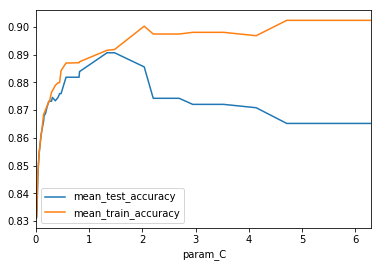

In [537]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_accuracy","mean_train_accuracy"]].sort_values(by = 'param_C')
tmp1.plot(x="param_C")
params

In [538]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty = 'l2', C=1.3364274880253213)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)


print("Train Accuracy %.3f" % classifier.score(X_train, y_train))
print("Valid Accuracy %.3f" % classifier.score(X_valid, y_valid))
print("Test Accuracy %.3f" % classifier.score(X_test, y_test))

Train Accuracy 0.891
Valid Accuracy 0.927
Test Accuracy 0.615


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [539]:
ypred_test = classifier.predict_proba(X_test)[:, 1]
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
print("Gini Test",metric_auc_test*2-1)

Gini Test 0.37225750935250757


In [540]:
df1 = df.dropna()
df1["LOG_SCORE"] = classifier.predict_proba(df1[x_column])[:, 1]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


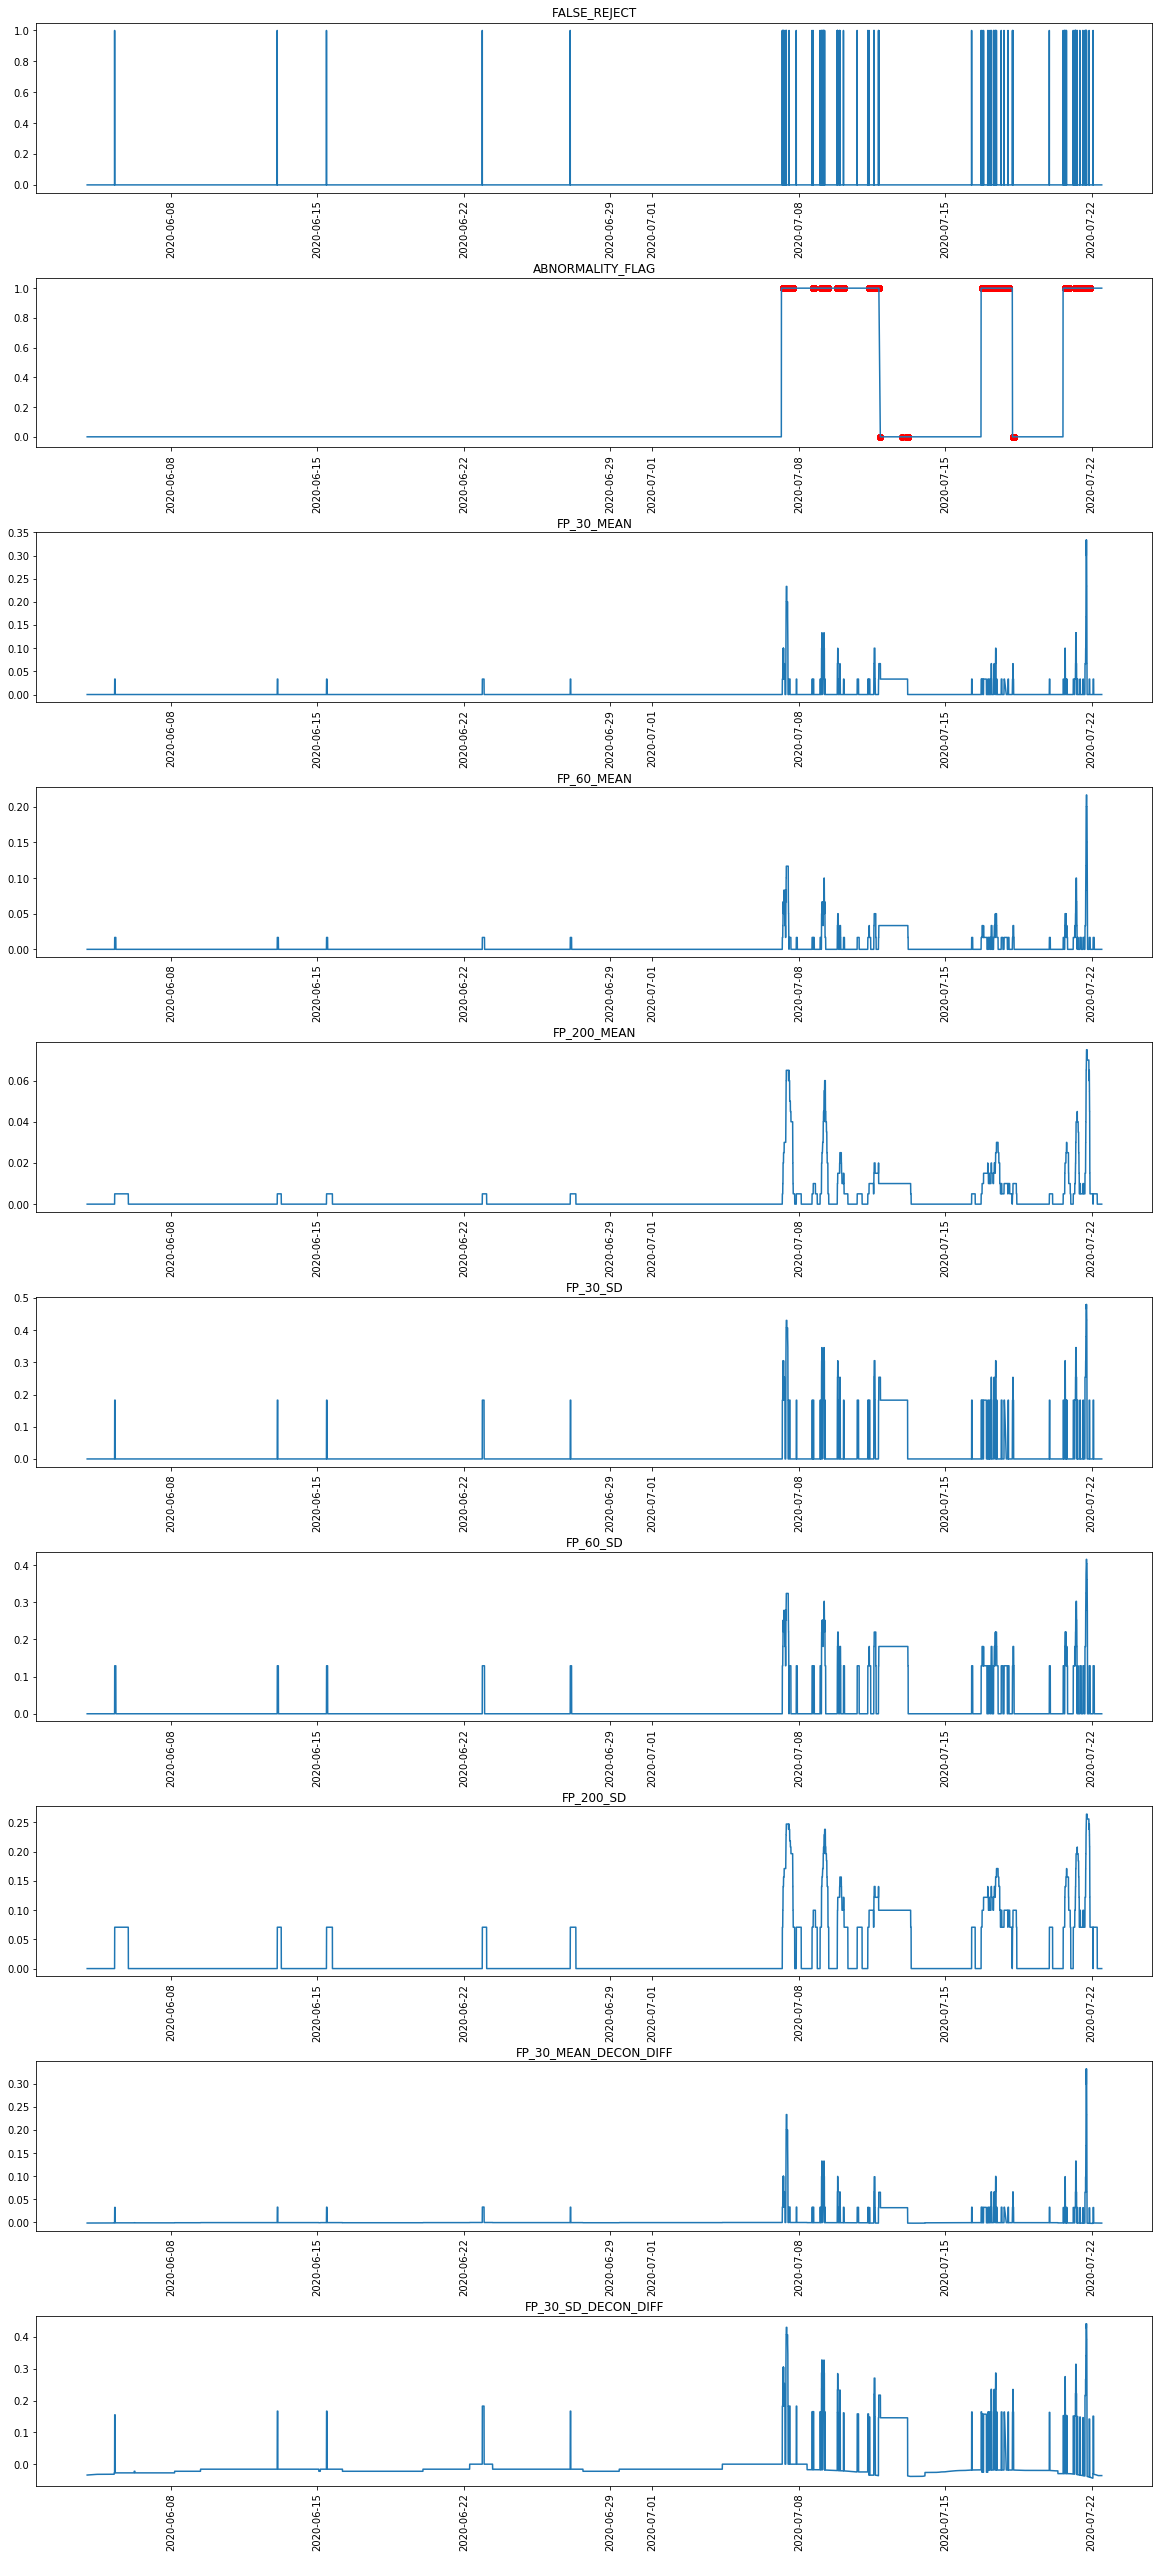

In [543]:
features = x_column
cutoff = 0.65

n_graphs = len(features)+3
fig = plt.figure(figsize = (20,50))
plt.subplots_adjust(hspace = 0.5)

ax1= fig.add_subplot(n_graphs,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(n_graphs,1,2)
a = df1.loc[df1['LOG_SCORE'] >= cutoff, ['PROD_TIMESTAMP', 'ABNORMALITY_FLAG']] #anomaly
ax1.plot(df1["PROD_TIMESTAMP"],df1["ABNORMALITY_FLAG"])
ax1.scatter(a['PROD_TIMESTAMP'],a['ABNORMALITY_FLAG'], color='red')
plt.title("ABNORMALITY_FLAG")
plt.xticks(rotation = 90,)



for x in range(len(features)):
    ax1= fig.add_subplot(n_graphs,1,x+3)
    ax1.plot(df1["PROD_TIMESTAMP"],df1[features[x]])
    plt.title(features[x])
    plt.xticks(rotation = 90,)

# Archieve

## Raw Plots

(array([737577., 737584., 737591., 737598., 737605., 737607., 737614.,
        737621., 737628., 737635.]), <a list of 10 Text xticklabel objects>)

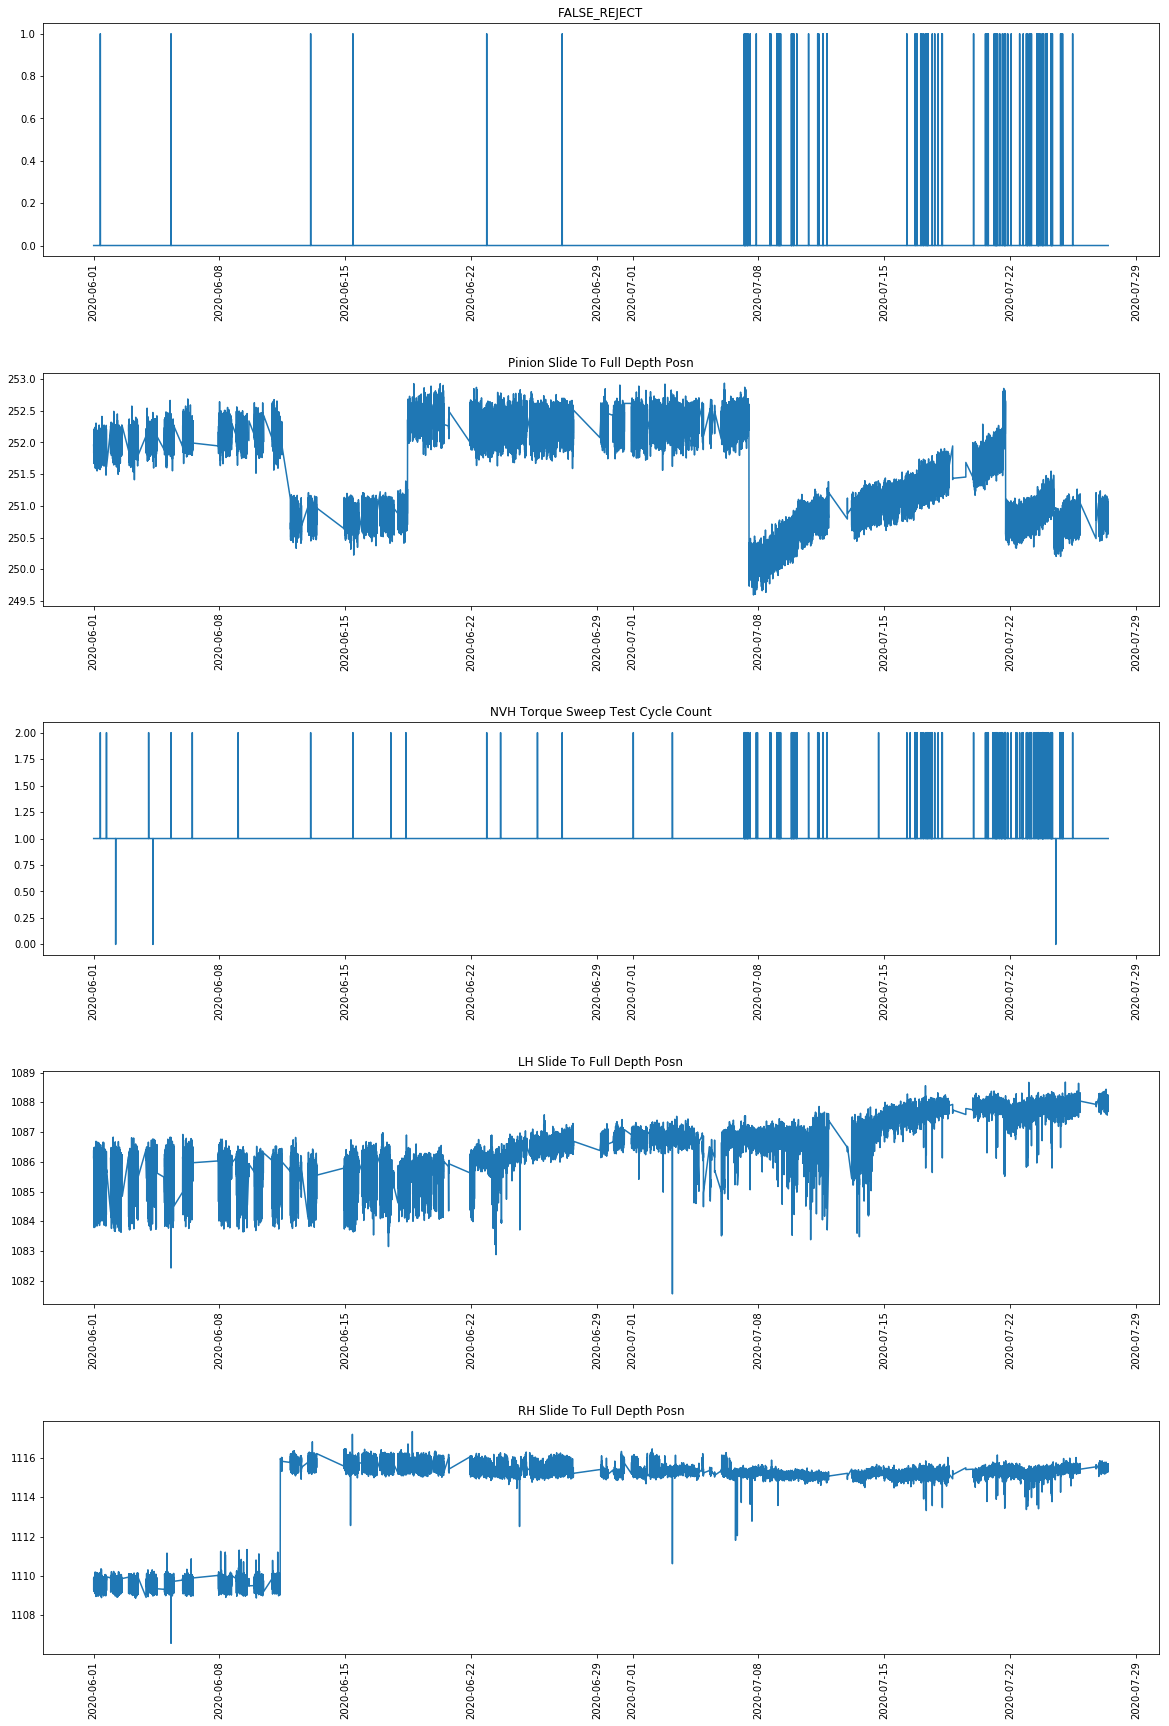

In [21]:
df1= df
# df1= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,22))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,6,25))]
df1= df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,1))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))]

fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["Pinion Slide To Full Depth Posn"])
plt.title("Pinion Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,3)
ax1.plot(df1["PROD_TIMESTAMP"],df1["NVH Torque Sweep Test Cycle Count"])
plt.title("NVH Torque Sweep Test Cycle Count")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,4)
ax1.plot(df1["PROD_TIMESTAMP"],df1["LH Slide To Full Depth Posn"])
plt.title("LH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,5)
ax1.plot(df1["PROD_TIMESTAMP"],df1["RH Slide To Full Depth Posn"])
plt.title("RH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


#OPEN
# df_tmp = pd.DataFrame(df_account[df_account.DATE_CLOSED.isna()][list1].count()/len(df_account[df_account.DATE_CLOSED.isna()])).reset_index()
# df_tmp.columns = ["COLUMN_NAME","FILL_RATE"]
# ax2= fig.add_subplot(4,1,2)
# ax2.bar(df_tmp.COLUMN_NAME,df_tmp.FILL_RATE)
# plt.title("FILL Rate:OPEN")
# for i, txt in enumerate(df_tmp.FILL_RATE):
#     plt.annotate("{:.0f}".format(txt*100), ((i-0.25, df_tmp.FILL_RATE[i]+0.01)))
# plt.xticks(rotation = 90)
# plt.ylim(0,1.1)


### Group on hourly level and plot

In [22]:
df["PROD_HOUR"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day,x.hour))

In [23]:
df_hour = df[["PROD_HOUR","LH Slide To Full Depth Posn","NVH Torque Sweep Test Cycle Count","Pinion Slide To Full Depth Posn","RH Slide To Full Depth Posn","FALSE_REJECT"]].groupby("PROD_HOUR").agg(["mean"])

df_hour.columns = [' '.join(col).strip() for col in df_hour.columns.values]

df_hour.reset_index(inplace = True)

(array([737574., 737577., 737591., 737605., 737607., 737621., 737635.]),
 <a list of 7 Text xticklabel objects>)

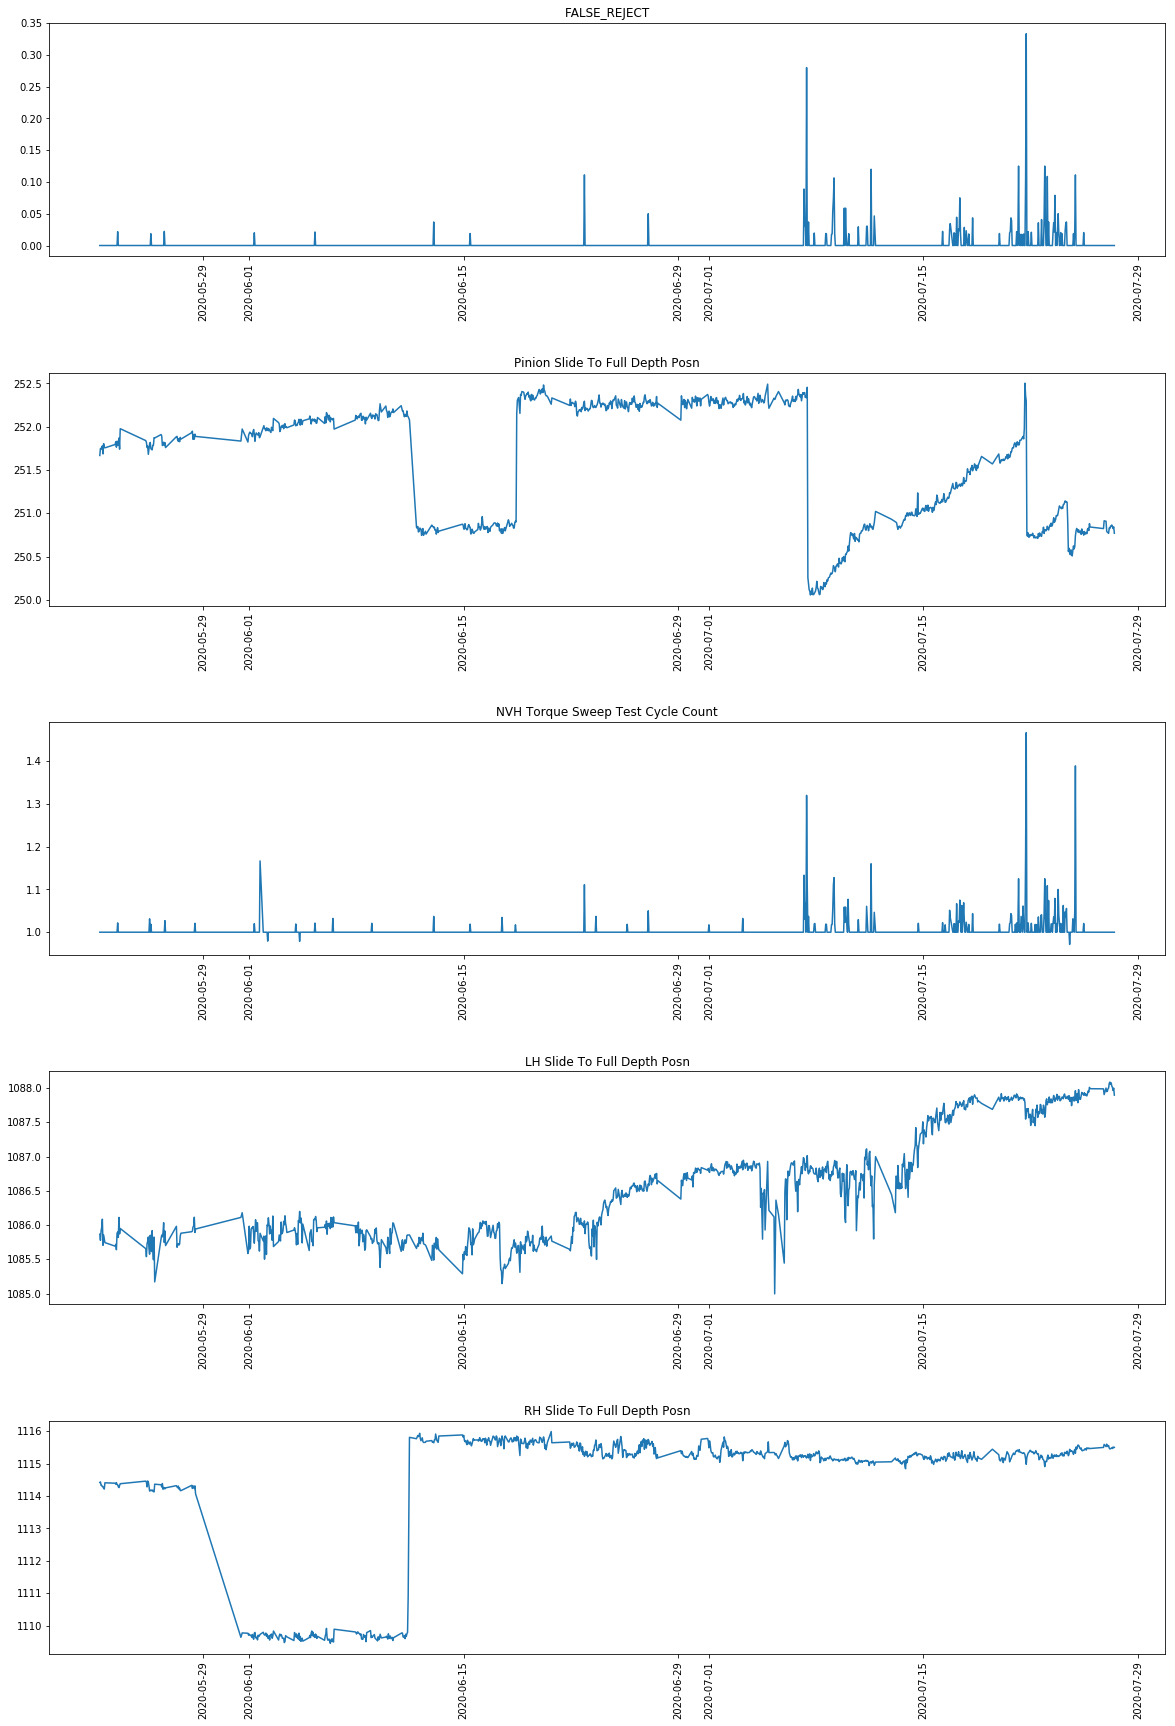

In [24]:
df1= df_hour[df_hour["PROD_HOUR"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_HOUR"],df1["FALSE_REJECT mean"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_HOUR"],df1["Pinion Slide To Full Depth Posn mean"])
plt.title("Pinion Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,3)
ax1.plot(df1["PROD_HOUR"],df1["NVH Torque Sweep Test Cycle Count mean"])
plt.title("NVH Torque Sweep Test Cycle Count")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,4)
ax1.plot(df1["PROD_HOUR"],df1["LH Slide To Full Depth Posn mean"])
plt.title("LH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,5)
ax1.plot(df1["PROD_HOUR"],df1["RH Slide To Full Depth Posn mean"])
plt.title("RH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


#OPEN
# df_tmp = pd.DataFrame(df_account[df_account.DATE_CLOSED.isna()][list1].count()/len(df_account[df_account.DATE_CLOSED.isna()])).reset_index()
# df_tmp.columns = ["COLUMN_NAME","FILL_RATE"]
# ax2= fig.add_subplot(4,1,2)
# ax2.bar(df_tmp.COLUMN_NAME,df_tmp.FILL_RATE)
# plt.title("FILL Rate:OPEN")
# for i, txt in enumerate(df_tmp.FILL_RATE):
#     plt.annotate("{:.0f}".format(txt*100), ((i-0.25, df_tmp.FILL_RATE[i]+0.01)))
# plt.xticks(rotation = 90)
# plt.ylim(0,1.1)


### Group on 6 hourly level and plot

In [25]:
df["PROD_HOUR"]=df["PROD_TIMESTAMP"].apply(lambda x: pd.datetime(x.year,x.month,x.day,math.floor(x.hour/6)*6))

In [26]:
df_hour = df[["PROD_HOUR","LH Slide To Full Depth Posn","NVH Torque Sweep Test Cycle Count","Pinion Slide To Full Depth Posn","RH Slide To Full Depth Posn","FALSE_REJECT"]].groupby("PROD_HOUR").agg(["mean"])

df_hour.columns = [' '.join(col).strip() for col in df_hour.columns.values]

df_hour.reset_index(inplace = True)

(array([737574., 737577., 737591., 737605., 737607., 737621., 737635.]),
 <a list of 7 Text xticklabel objects>)

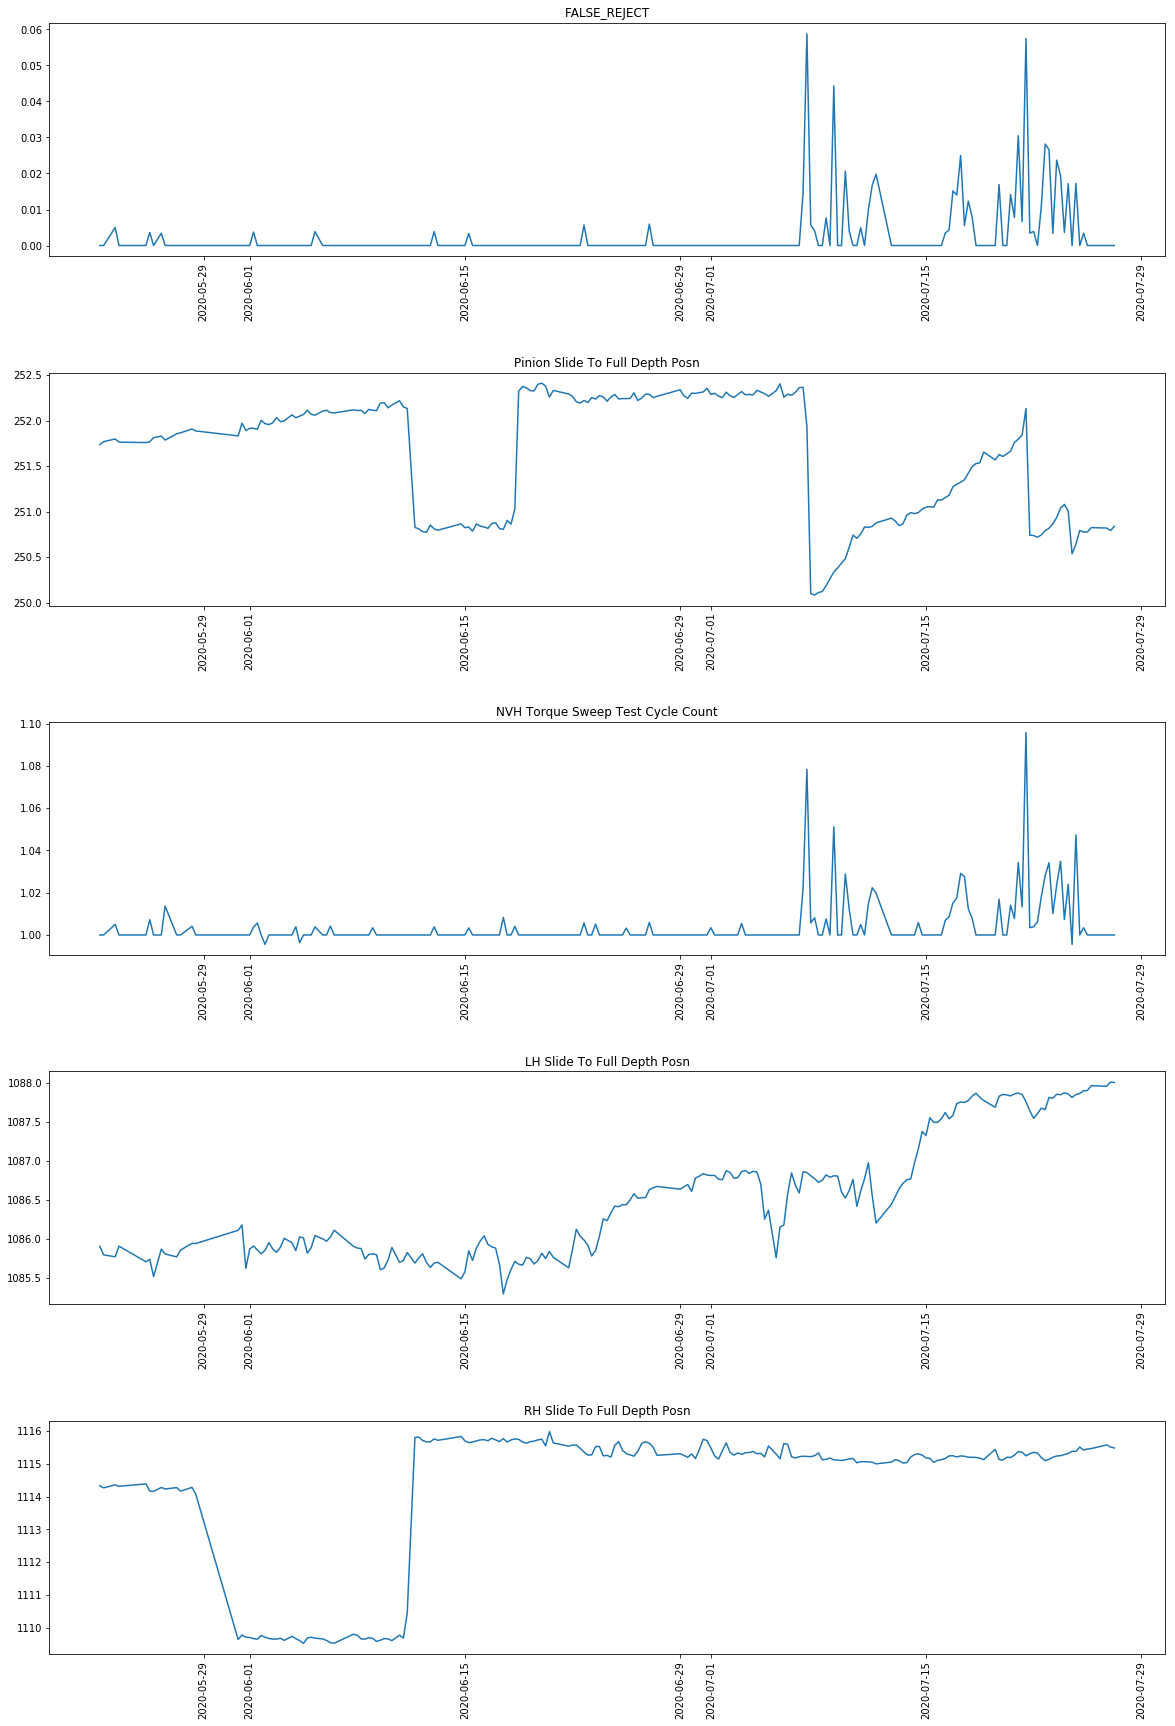

In [27]:
df1= df_hour[df_hour["PROD_HOUR"]>=pd.datetime(2020,5,20)]


fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_HOUR"],df1["FALSE_REJECT mean"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_HOUR"],df1["Pinion Slide To Full Depth Posn mean"])
plt.title("Pinion Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,3)
ax1.plot(df1["PROD_HOUR"],df1["NVH Torque Sweep Test Cycle Count mean"])
plt.title("NVH Torque Sweep Test Cycle Count")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,4)
ax1.plot(df1["PROD_HOUR"],df1["LH Slide To Full Depth Posn mean"])
plt.title("LH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,5)
ax1.plot(df1["PROD_HOUR"],df1["RH Slide To Full Depth Posn mean"])
plt.title("RH Slide To Full Depth Posn")
plt.xticks(rotation = 90,)


#OPEN
# df_tmp = pd.DataFrame(df_account[df_account.DATE_CLOSED.isna()][list1].count()/len(df_account[df_account.DATE_CLOSED.isna()])).reset_index()
# df_tmp.columns = ["COLUMN_NAME","FILL_RATE"]
# ax2= fig.add_subplot(4,1,2)
# ax2.bar(df_tmp.COLUMN_NAME,df_tmp.FILL_RATE)
# plt.title("FILL Rate:OPEN")
# for i, txt in enumerate(df_tmp.FILL_RATE):
#     plt.annotate("{:.0f}".format(txt*100), ((i-0.25, df_tmp.FILL_RATE[i]+0.01)))
# plt.xticks(rotation = 90)
# plt.ylim(0,1.1)


## Anamoly Score implementation

### Using Robust Random cut Forest

In [28]:
sin = df[(df["PROD_TIMESTAMP"]>=pd.datetime(2020,6,1))&(df["PROD_TIMESTAMP"]<=pd.datetime(2020,7,30))][["PROD_TIMESTAMP","FALSE_REJECT"]]

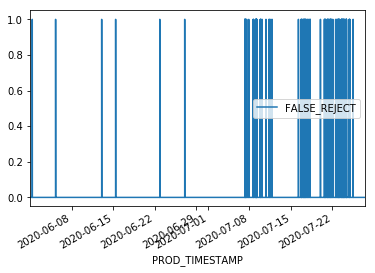

In [29]:
sin.plot(x="PROD_TIMESTAMP",y="FALSE_REJECT")

In [30]:
import rrcf

num_trees = 40
shingle_size =1500
tree_size = 256

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

In [31]:
points = rrcf.shingle(sin["FALSE_REJECT"], size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size...
        if len(tree.leaves) > tree_size:
            # Drop the oldest point (FIFO)
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point...
        new_codisp = tree.codisp(index)
        # And take the average over all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees

KeyboardInterrupt: 

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax1 = plt.subplots(figsize=(10, 5))


# color = 'tab:red'
# ax1.set_ylabel('Data', color=color, size=14)
# ax1.plot(sin, color=color)
# ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
# ax1.set_ylim(0,5)
# ax2 = ax1.twinx()
# color = 'tab:blue'
# ax2.set_ylabel('CoDisp', color=color, size=14)
# ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
# ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
# ax2.grid('off')
# ax2.set_ylim(0, 500)
# plt.title('False Reject (red) and anomaly score (blue)', size=14)

In [ ]:

fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(sin["PROD_TIMESTAMP"],sin["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)


ax1= fig.add_subplot(5,1,2)
ax1.plot(sin["PROD_TIMESTAMP"][0:len(sin)-shingle_size+1],pd.Series(avg_codisp))
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


## Using distribution comparison 2 Sample KS Statistics

### False Reject

In [ ]:
# df.reset_index(inplace = True)
df["DIFF"] = ""

# x= 20000
b_window = 6000  #Remove identified anamolies
c_window = 30


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = list(df["FALSE_REJECT"][max(0,x-b_window-c_window):max(0,x-c_window)])
    current_obs = list(df["FALSE_REJECT"][max(0,x-c_window):x])
    ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
    df.loc[df.index[x],"DIFF"] = 1-ks_value.pvalue

print (time.time()-start)

In [ ]:
df1 = df.dropna(subset = ['DIFF'])
df1 = df[df["DIFF"]!=""]
# df1=df1[(df1["PROD_TIMESTAMP"] >= pd.datetime(2020,6,22))&(df1["PROD_TIMESTAMP"] <= pd.datetime(2020,6,30))]
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["DIFF"])
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


### Pinion Slide To Full Depth Posn

In [ ]:
# df.reset_index(inplace = True)
df["DIFF_VAR1"] = ""

# x= 20000
b_window = 6000
c_window = 30


# df.shape[0]
start = time.time()

for x in range(b_window,df.shape[0]):
    
    base_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-b_window-c_window):max(0,x-c_window)])
    current_obs = list(df["Pinion Slide To Full Depth Posn"][max(0,x-c_window):x])
    ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
    df.loc[df.index[x],"DIFF_VAR1"] = 1-ks_value.pvalue

print (time.time()-start)

In [ ]:
df1 = df.dropna(subset = ['DIFF_VAR1'])
df1 = df[df["DIFF_VAR1"]!=""]
df1=df1[(df1["PROD_TIMESTAMP"] >= pd.datetime(2020,6,22))&(df1["PROD_TIMESTAMP"] <= pd.datetime(2020,6,30))]
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["DIFF_VAR1"])
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


## Using distribution comparison Chi Square

### False Reject

In [ ]:
# df.reset_index(inplace = True)

# x= 20000
b_window = 6000
c_window = 500
gap = 6000


start = time.time()

for x in range(b_window+gap,df.shape[0]):
    base_obs = list(df["FALSE_REJECT"][max(0,x-b_window-c_window-gap):max(0,x-c_window-gap)])
    current_obs = list(df["FALSE_REJECT"][max(0,x-c_window):x])
#     table = [[base_obs.count(0), base_obs.count(1)],
#         [current_obs.count(0),current_obs.count(1)]]

    table = [[2000, 60],
        [current_obs.count(0),current_obs.count(1)]]

    
    try:

        stat, p, dof, expected = chi2_contingency(table)
#     ks_value = ks_2samp(base_obs,current_obs)
#     ks_value = ks_2samp([0] * 10000,current_obs)
        df.loc[df.index[x],"CHI_SQ_1"] = 1-p
    except:
        df.loc[df.index[x],"CHI_SQ_1"] = 0
        
print (time.time()-start)

In [ ]:
df1 = df.dropna(subset = ['CHI_SQ_1'])
df1 = df[df["CHI_SQ_1"]!=""]
# df1=df1[(df1["PROD_TIMESTAMP"] >= pd.datetime(2020,6,22))&(df1["PROD_TIMESTAMP"] <= pd.datetime(2020,6,30))]
fig = plt.figure(figsize = (20,30))
plt.subplots_adjust(hspace = 0.5)
ax1= fig.add_subplot(5,1,1)
ax1.plot(df1["PROD_TIMESTAMP"],df1["FALSE_REJECT"])
plt.title("FALSE_REJECT")
plt.xticks(rotation = 90,)

ax1= fig.add_subplot(5,1,2)
ax1.plot(df1["PROD_TIMESTAMP"],df1["CHI_SQ_1"])
plt.title("Anamoly Index")
plt.xticks(rotation = 90,)


In [ ]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(df_dod["PROD_DAY"],df_dod["FALSE_REJECT count"], label = 'FALSE_REJECT count')
plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT count')
plt.legend(loc="best")
plt.xticks(rotation = 90,)
ax2 = ax1.twinx()
ax2.plot(df_dod["PROD_DAY"],df_dod["FALSE_REJECT sum"],color='red', linewidth=4, markersize=12, label = 'FALSE_REJECT sum')
plt.title("DOD Count and False Rejects")
plt.legend(loc="best")


plt.xlabel('PROD_DAY')
plt.ylabel('FALSE_REJECT sum')

plt.show()
# ax1.plot()

# df_dod.plot(x="PROD_DAY", y = ["FALSE_REJECT sum","FALSE_REJECT count"])